This jupyter notebook contains a number of functions to perform an in-depth identification of a reaction coordinate from a set of trajectories sampling a chemical reaction.
The Notebook contains a minimal running example on two trajectories (supplied in the github repository). For access to the full dataset, please contact the authors.

The notebook is associated with the following publication:

https://doi.org/10.26434/chemrxiv-2024-nd20j

# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import decomposition, datasets
import pandas as pd
import copy
import seaborn as sns
import os
import glob
from sklearn.feature_selection import r_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, KernelPCA
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import gc
from mpl_toolkits.mplot3d import Axes3D
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LassoCV
import pandas as pd
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler 
import numpy as np
from pyemma.coordinates import tica
from sklearn.decomposition import FastICA
import pyemma
np.bool = np.bool_ #np.bool is deprecated
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import collections.abc
import six
import sys
import sklearn
sys.modules['sklearn.externals.six'] = six
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
from skrules import SkopeRules
# from collections.abc import Iterable
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.stats import norm
import matplotlib.mlab as mlab
import dtreeviz
import warnings
import statsmodels
import MDAnalysis as mda
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


## Package Versions

In [2]:
print('Scikit {}'.format(sklearn.__version__))
print('Scipy {}'.format(sp.__version__))
print('Numpy {}'.format(np.__version__))
print('Pandas {}'.format(pd.__version__))
# print('SkopeRules {}'.format(SkopeRules.__version__))
print('Pyemma {}'.format(pyemma.__version__))
print('Matplotlib {}'.format(matplotlib.__version__))
print('dtreeviz {}'.format(dtreeviz.__version__))
print('statsmodels {}'.format(statsmodels.__version__))
print('seaborn {}'.format(sns.__version__))
print('mdanalysis {}'.format(mda.__version__))

Scikit 1.4.1.post1
Scipy 1.12.0
Numpy 1.26.4
Pandas 2.2.1
Pyemma 2.5.12
Matplotlib 3.8.3
dtreeviz 2.2.2
statsmodels 0.14.1
seaborn 0.13.2
mdanalysis 2.7.0


# Functions

### Data processing

In [3]:
def sigmoid(x, L ,x0, k, b):
    """
    Sigmoid function to fit the energy graph
    """
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def findTS( array,criteria = 50):
    """
    Function to locate transition state in a graph. All values before the criterium are chosen as pre-reaction energies.
    The function works backwards until a maximum is reached
    :param array: 1-D array containing the energy values
    :param criteria = energy cutoff criterium, default value set to 50 energy units (kcal/mol or kJ/mol, depending on the simulation data)
    """
    ts = -1
    if len(np.argwhere(array<criteria)) > 0:
        ts = np.argwhere(array<criteria)[0][0]
        test=True
        while test:
            if array[ts-1]>=array[ts]:
                ts=ts-1
            else:
                test=False
        # print(ts)
    else:
        print('No TS found for {}'.format(i))
    return ts

def get_top_perc(array,labels, perc = 10):
    """
    Return a top % of values from an array
    :param array: numpy array with values
    :param labels: array containing the labels
    :param perc: float representing the top X%, default is 10%
    """
    values = int(array.size//(100/perc))
    ind = np.argpartition(np.abs(array), -values)[-values:]
    return array[ind], labels[ind], ind

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    :param x, y : 1-D arrays, input data.
    :param ax : matplotlib.axes.Axes, the axes object to draw the ellipse into.
    :param n_std : float, the number of standard deviations to determine the ellipse's radiuses.
    :param **kwargs Forwarded to `~matplotlib.patches.Ellipse`

    returns: matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    if n_std == 1:
        conf = 68.7
    if n_std == 2:
        conf = 95
    if n_std == 3:
        conf = 99.7
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    print(ellipse.get_patch_transform().transform((0,0)))
    print('Ellipse: ctr:{} , width:{}, height:{}, angle:{}'.format(ellipse.get_center(),ellipse.get_width(),ellipse.get_height(), ellipse.get_angle()))
    return ax.add_patch(ellipse)

def myplotAX(ax, dataArray, coeff, labels=None, colors = None, coeff_limit = 50, scale_coeff = 1, lw = 3, n_std = 3, alpha = [0.02,1,0.02],
             class_names = ['Educt', 'Transition State Range', 'Product'], loadings = True):
    """
    Create a 2D plot and label ensembles.

    :param ax: matplotlib.axes.Axes object.
    :param dataArray: 2D array, containing the x and y values of the datapoints, projected in the PCA/LDA space.
    :param coeff : array containing the loadings/contributions to the PC.
    :param labels : array containing the class labels, used to separate the ensembles.
    :param colors : array containing the colors, used to color the ensembles. Size should be the same as number of classes.
    :param coeff_limit : limit of coeff. Only coeff above this threshold are shown.
    :param scale_coeff : scale coefficients to better represent them in the plot.
    :param lw : ellipse line width.
    :param n_std : number of standard deviations used to plot the confidence ellipse.
    :param alpha : transparency of the data points.
    :param class_names : labels of the ensembles, should be equal to the number of classes.
    :param loadings : plot loadings.
    :param **kwargs Forwarded to `~matplotlib.patches.Ellipse`

    returns: matplotlib.patches.Ellipse
    """
    xs = dataArray[:,0]
    ys = dataArray[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    ellipses = []
    for lbl in np.unique(class_labels):
        ax.scatter(xs[np.argwhere(class_labels==int(lbl))] ,ys[np.argwhere(class_labels==int(lbl))], c = colors[int(lbl)], s=10,alpha =  alpha[int(lbl)],label =  class_names[int(lbl)]) #without scaling
        ellipses.append(confidence_ellipse(xs[np.argwhere(class_labels==int(lbl))].flatten(), ys[np.argwhere(class_labels==int(lbl))].flatten(), ax, edgecolor='#BBCC33', lw = lw, n_std=n_std))
    if loadings is not None:
        for i in range(n):
            if np.abs(coeff[i,0]) >=coeff_limit or np.abs(coeff[i,1]) >= coeff_limit:
                ax.arrow(0, 0, coeff[i,0]*scale_coeff, coeff[i,1]*scale_coeff,color = 'black',alpha = 0.5, lw = 2)
                if labels is None:
                    ax.text(coeff[i,0]*scale_coeff* 1.1, coeff[i,1]*scale_coeff * 1.05, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center', fontsize = 16)
                else:
                    ax.text(coeff[i,0]*scale_coeff* 1.1, coeff[i,1]*scale_coeff * 1.05, labels[i], color = 'black', ha = 'center', va = 'center', fontsize = 16)
    return ellipses

def readtraj(path, moleculesize = 276, H=True):
    """
    Read xyz trajectory file, used for reading a single large file, containing multiple trajectories
    :param path: path to xyz file
    :param moleculesize: number of atoms in molecule, default 276 (size of calixarene used in the original publication)
    :param H: bool, ignore hydrogens
    """
    data = []
    tmp = []
    labels = []
    with open(path, 'r') as f:
        next(f)
        next(f)
        counter = 0
        for line in f:
            if H:
                if 'H' in line:
                    counter += 1
                    continue
            if counter < moleculesize:
                tmp.append(np.array(line.split()[1:], dtype = float))
                labels.append(np.array(line.split()[0]))
            else:
                data.append(np.array(tmp))
                tmp = []
                try:
                    next(f)
                except:
                    break
                counter = 0 
                continue
            counter += 1
        data.append(np.array(tmp))
    return np.array(data), labels
    
def readtraj_one(path, moleculesize = 133):
    """
    Read single xyz trajectory file
    :param path: path to xyz file
    :param moleculesize: number of atoms in molecule, default 276 (size of calixarene used in the original publication)
    :param H: bool, ignore hydrogens
    """
    data = []
    tmp = []
    progress = 1
    with open(path, 'r') as f:
        next(f)
        next(f)
        counter = 0
        for line in f:
            
            if counter < moleculesize:
                tmp.append(np.array(line.split()[1:], dtype = float))
            else:
                data.append(np.array(tmp))
                tmp = []
                progress += 1
                if progress % 10000 == 0:
                    print(progress/10000)
                try:
                    next(f)
                except:
                    break
                counter = 0 
                continue
            counter += 1
        data.append(np.array(tmp))
    return np.array(data)

def centre(path, box = 57.31353145):
    """
    Re-image a trajectory
    :param path: path to trajectory
    :param box: size of simulation box, default  57.31353145 (size of ssimulation box used in the original publication)

    returns: numpy array of trajectory
    """
    data, labels = readtraj(path)
    size = data[0].shape[0]
    reference = copy.deepcopy(data[0][0])
    data = data -reference
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                if data[i][j][k] >= box/2:
                    try:
                        data[i][j][k] =data[i][j][k] - box
                    except:
                        print(i,j,k)
                if data[i][j][k] <= -box/2:
                    try:
                        data[i][j][k] =data[i][j][k] + box
                    except:
                        print(i,j,k)
    return data

def readenergy(filepath):
    """
    Read energy file to numpy array
    """
    energy = np.loadtxt(filepath)
    return energy

def get_data(pathdata,pathqm):
    """
    Get data from trajectories and energy files
    :param pathdata: list of paths that point to the trajectory files
    :param pathqm:  list of paths that point to the energy files
    """
    data = []
    energy = []
    for i in range(len(pathdata)):
        tmpd = centre(pathdata[i])
        if tmpd.shape == (10000, 133, 3):
            data.append(tmpd)
        else:
            print(i)
        tmpe = readenergy(pathqm[i])
        if tmpe.shape == (10000,):
            energy.append(tmpe)
        else:
            print(i)
    return np.array(data), np.array(energy)

def calculateCOM(data):
    """
    Calculate center of mass
    """
    return np.average(data, axis=0)

def calculateDistance(a,b):
    return np.linalg.norm(a-b)

def calculateAngle(a,b,c):
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

def calculateDihedral(a,b,c,d):
    """
    Calculate dihecral angle using numpy
    :param a,b,c,d: XYZ coordinates of 4 atoms
    returns: angle in degrees
    """
    p0 = a
    p1 = b
    p2 = c
    p3 = d

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2

    b1 /= np.linalg.norm(b1)

    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1

    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.degrees(np.arctan2(y, x))

def calculateInternals(combinations, data):
    """
    Calculate internal coordinates
    :param combinations: array containing lists of atoms (2,3 or 4)
    :param data: trajectories in XYZ format

    returns: numpy array of internal coordinates
    """
    tmp = []
    for element in combinations:
        if len(element)==2:
            tmp.append(calculateDistance(*data[element]))
        if len(element)==3:
            tmp.append(calculateAngle(*data[element]))
        if len(element)==4:
            tmp.append(calculateDihedral(*data[element])) 
    return np.array(tmp)

def clean_dataset(df):
    """
    Sanitize pandas DataFrame
    """
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

### Data Analysis

In [4]:
def calcLDA(array, target, colors, borders = (2,2), energy=None, elev=30, azim=-70):
    """
    Calculate LDA

    :param array: numpy data array
    :param target: labels for each point
    :param borders: (x,y) tuple containing border min and max
    :param energy: energy array used as 3rd dimension for 3D plot
    :param elev, azim: elevation and azimuth for 3D plot
    
    returns: LDA object
    """
    lda = LinearDiscriminantAnalysis(n_components=2)
    lda.fit(array,target)
    x = lda.transform(array)
    print(
    "explained variance ratio (first two components): %s"
    % str(lda.explained_variance_ratio_)
    )
    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()

    if energy is not None:
        ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
        ax.set_position([0, 0, 0.95, 1])
        plt.cla()
        ax.scatter(x[:, 0], x[:, 1], energy, c=colors, cmap=plt.cm.nipy_spectral, edgecolor="k")
        plt.show()
    plt.scatter(x[:, 0], x[:, 1], s =1,c =colors)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()
    return lda

def calcPCA(array, colors, borders = (2,2), energy=None, elev=30, azim=-70):
    """
    Calculate PCA

    :param array: numpy data array
    :param colors: 1D array for color of each point
    :param borders: (x,y) tuple containing border min and max
    :param energy: energy array used as 3rd dimension for 3D plot
    :param elev, azim: elevation and azimuth for 3D plot
    
    returns: PCA object, loadings, correlations
    """
    pca = decomposition.PCA(n_components=3)
    pca.fit(array)
    x = pca.transform(array)
    print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
    )
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    print(pca.explained_variance_)
    correlations = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'])

    # %matplotlib widget
    # fig = plt.figure(1, figsize=(8, 8))
    # ax = Axes3D(fig) 
    # plt.clf()
    
    # ax = fig.add_subplot(111, projection="3d", elev=elev, azim=azim)
    # ax.set_position([0, 0, 0.95, 1])
    # plt.cla()
    # if energy is None:
    #     ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=colors, cmap=plt.cm.nipy_spectral, edgecolor="k")
    # else:
    #     ax.scatter(x[:, 0], x[:, 1], energy, c=colors, cmap=plt.cm.nipy_spectral, edgecolor="k")

    # # %matplotlib inline
    
    # plt.show()
    plt.scatter(x[:, 0], x[:, 1], s =1,c =colors)
    plt.xlim(borders)
    plt.ylim(borders)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()
    plt.scatter(x[:, 1], x[:, 2], s =1,c =colors)
    plt.xlim(borders)
    plt.ylim(borders)
    plt.xlabel("PC 2")
    plt.ylabel("PC 3")
    plt.show()
    return pca, loadings, correlations

def calcKPCA(array, colors, borders = (2,2), kernel = 'linear'):
    """
    Calculate Kernel PCa

    :param array: numpy data array
    :param colors: 1D array for color of each point
    :param borders: (x,y) tuple containing border min and max
    :param kernel: pca kernel function (can be used to perform non-linear PCA)
    
    returns: PCA object
    """
    pca = KernelPCA(
    n_components=3, kernel=kernel, gamma=None, fit_inverse_transform=True, alpha=1
    )
    pca.fit(array)
    x = pca.transform(array)
    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    borders = (np.min(x),np.max(x))
    
    ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
    ax.set_position([0, 0, 0.95, 1])
    plt.cla()
    ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=colors, cmap=plt.cm.nipy_spectral, edgecolor="k")
    plt.show()
    plt.scatter(x[:, 0], x[:, 1], s =1,c =colors)
    plt.xlim(borders)
    plt.ylim(borders)
    plt.show()
    plt.scatter(x[:, 1], x[:, 0], s =1,c =colors)
    plt.xlim(borders)
    plt.ylim(borders)
    plt.show()
    return pca

def calcTree(array, labels, leaf = 8, random_state=0,class_weight='balanced'):
    """
    Calculate Kernel PCA

    :param array: numpy data array
    :param labels: labels for each point
    :param leaf: number of leaves, default 8
    :param random state: lock random state of tree
    :param class_weight: weighting of tree
    
    returns: classifier object
    """
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=leaf, random_state=random_state,class_weight=class_weight)
    clf = clf.fit(array, labels)
    plt.figure(figsize=(20,16))
    plot_tree(clf, filled=True)
    plt.title("Decision tree trained on all features")
    plt.show()
    return clf

def reduceData(classes,data, size):
    """
    Reduce a dataset though random sampling

    :param classes : 1D array containing the class labels
    :param data : array of datapoints
    :param size : number of samples
    """
    rng=np.random.default_rng()
    reduced_data = []
    reduced_classes = []
    for elem in np.unique(classes):
        d = data[np.argwhere(classes==elem).flatten()]
        if d.shape[0] < size:
            size_elem = d.shape[0]
        else:
            size_elem = size
        drng = rng.choice(d,size_elem)
        reduced_data.append(drng)
        c = np.empty(drng.shape[0])
        c[:] = elem
        reduced_classes.append(c)
        print(drng.shape)
    return np.concatenate(reduced_data),np.concatenate(reduced_classes).flatten()

def getClasses( array,criteria = 2, before=5, after=5, framespersim = 10000, trueTS=True):
    """
    Find TS range and use to set class labels

    :param array: energy data array
    :param criteria: energy cutoff criterium
    :param before: number of frames before TS to assign to the TS ensemble
    :param after: number of frames after TS to assign to the TS ensemble
    :param framespersim: number of frames per simulation
    :param trueTS: bool, only works with energy, to find the hump before the drop

    returns: array with labels, array with ts location in the sim
    """
    ts_points = []
    classes = []
    for i,sim in enumerate(np.array(np.split(array,array.shape[0]/framespersim))):
        arr = np.zeros(framespersim)
        ts = -1
        if len(np.argwhere(sim<criteria)) > 0:
            ts = np.argwhere(sim<criteria)[0][0]
            if trueTS:
                test=True
                while test:
                    # print(sim[ts],ts,sim[ts-1]-sim[ts])
                    if sim[ts-1]>=sim[ts]:
                        ts=ts-1
                    else:
                        test=False
            arr[ts-before:ts+after] = 1
            arr[ts+after:] = 2
        else:
            print('No TS found for {}'.format(i))
        classes.append(arr)
        ts_points.append((i,ts))
    return np.array(classes).flatten(), np.array(ts_points)


def normalize(arr, condense = True):
    """
    Normalize array values using numpy

    :param arr: numpy array
    :param condense: bool, combine XYZ coordinates to one value using mean

    returns: normalised array
    """
    tmp = np.empty(arr.shape)
    for i in range(arr.shape[1]):
        tmp[:,i] = (arr[:,i]-np.min(arr[:,i]))/np.max(arr[:,i]-np.min(arr[:,i]))
    if condense:
        normalized_arr = np.empty((arr.shape[0],int(arr.shape[1]/3)))
        for i in range(int(arr.shape[1]/3)):
            normalized_arr[:,i]=np.mean((tmp[:,i*3],tmp[:,i*3+1],tmp[:,i*3+2]), axis = 0)
        return normalized_arr
    else:
        return tmp

def corr_matrix(normalized_arr, arr_energy):
    """
    Calculate Pearson correlation matrix
    :param normalized_arr: normalized numpy array
    :param arr_energy: numpy array containing the energy
    

    returns numpy array with correlations between variables and correlation with energy
    """
    R_matrix = np.empty((normalized_arr.shape[1]+1,normalized_arr.shape[1]))
    R_matrix[0] = r_regression(normalized_arr,arr_energy)
    for i in range(normalized_arr.shape[1]):
        if i % 20 == 0:
            print(i)
        R_matrix[i+1] = r_regression(normalized_arr,normalized_arr[:,i])
    return R_matrix

def pandasNorm(arr):
    """
    Normalise numpy array using minmaxScaler()
    :param arr: numpy array

    returns: normalised pandas df
    """
    df = pd.DataFrame(arr)
    scaler = MinMaxScaler()
    df = scaler.fit_transform(df)
    return df

# Load data

In [5]:
trajfiles = r'/storage/rat/calixa_sims_6-7/dry/gittest/'
energyfiles = r'/storage/rat/calixa_sims_6-7/qm/gittest/'
pathtraj = glob.glob(trajfiles + '*.xyz')
pathtraj.sort()
pathqm =  glob.glob(energyfiles + '*.qm')
pathqm.sort()
len(pathtraj),len(pathqm)

(2, 2)

### Atom ordering and units

Here the atoms id are labelled and used to define the bonds, angles and dihedrals for the internal coordinate system (atomId - label)

* 0 - Cu
  
* 1 - Br

* 2,3,4,5,6,7 - phenyl

* 8,9,10,11,12,13,14 - Nph

* 15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30 - phenanthroline

* 31 - O1

* 32 - O2

* 30,73,74,75,76,77,78,79,80,81,82,32 - c0

* 33,34,35,36,37,38,39,40,42,43,44,127 - c1

* 46,47,48,49,50,51,52,53,54,55,56,128 - c2

* 58,59,60,61,62,63,64,65,66,67,68,129 - c3

* 17,70,71,72,121,122,123,124,125,156,31 - c4

* 108,109,110,111,112,113,114,115,116,117,132 - c5

* 96,97,98,99,100,101,102,103,104,105,131 - c6

* 84,85,86,87,88,89,90,91,92,93,94,130 - c7

In [6]:
internal_labels = ['Cu','Br','Phe','NPh','Phena','c0','c1','c2','c3','c4','c5','c6','c7','Oc0','Oc1','Oc2','Oc3','Oc4','Oc5','Oc6','Oc7','C', 'N']
units = [[0],#0
[1],#1
[2,3,4,5,6,7],#2
[8,9,10,11,12,13,14],#3
[15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],#4
[30,73,74,75,76,77,78,79,80,81,82,32],#5
[33,34,35,36,37,38,39,40,42,43,44,127],#6
[46,47,48,49,50,51,52,53,54,55,56,128],#7
[58,59,60,61,62,63,64,65,66,67,68,129],#8
[17,70,71,72,120,121,122,123,124,125,126,31],#9
[108,109,110,111,112,113,114,115,116,117,118,132],#10
[96,97,98,99,100,101,102,103,104,105,106,131],#11
[84,85,86,87,88,89,90,91,92,93,94,130],#12
[32],#13
[127],#14
[128],#15
[129],#16
[31],#17
[132],#18
[131],#19
[130],#20
[2],#21 C
[8]]#22 N


distances = []
for i in range(len(units)):
    for j in range(len(units)):
        if j>i:
            distances.append([i,j])
# print(distances)
angles = [ #phenanthroline-Cu-COM
[4, 0, 1],
[4, 0, 2],
[4, 0, 3],
[4, 0, 5],
[4, 0, 6],
[4, 0, 7],
[4, 0, 8],
[4, 0, 9],
[4, 0, 10],
[4, 0, 11],
[4, 0, 12],
[4, 0, 13],#phenanthroline-Cu-Ox
[4, 0, 14],
[4, 0, 15],
[4, 0, 16],
[4, 0, 17],
[4, 0, 18],
[4, 0, 19],
[4, 0, 20],
[5, 4, 6],#calixa-phenanthroline-calixa
[5, 4, 7],
[5, 4, 8],
[5, 4, 9],
[5, 4, 10],
[5, 4, 11],
[5, 4, 12],
[6, 4, 7],
[6, 4, 8],
[6, 4, 9],
[6, 4, 10],
[6, 4, 11],
[6, 4, 12],
[7, 4, 8],
[7, 4, 9],
[7, 4, 10],
[7, 4, 11],
[7, 4, 12],
[8, 4, 9],
[8, 4, 10],
[8, 4, 11],
[8, 4, 12],
[9, 4, 10],
[9, 4, 11],
[9, 4, 12],
[10, 4, 11],
[10, 4, 12],
[11, 4, 12]]

dihedrals = [[5, 13, 14, 6],
 [6, 14, 15, 7],
 [7, 15, 16, 8],
 [8, 16, 17, 9],
 [9, 17, 18, 10],
 [10, 18, 19, 11],
 [11, 19, 20, 12],
 [12, 20, 13, 5]]

internals = distances + angles + dihedrals
len(internals)

308

### Get aligned trajectories and energies

In [7]:
data, energy = get_data(pathtraj,pathqm)
energy = energy - np.min(energy)
data_aligned = readtraj_one('/storage/rat/calixa_sims_6-7/dry/centred/gittest/aligned_x.xyz', moleculesize = 133)
arr = data_aligned.reshape(*data_aligned.shape[:-2], -1)
arr_energy = np.hstack(energy)

1.0
2.0


### Created reduced dataset with COM of calixarene units

In [8]:
data_reduced = np.empty((data_aligned.shape[0],len(units),3))
for id,frame in enumerate(data_aligned):
    tmp = []
    for atoms in units:
        tmp.append(calculateCOM(frame[atoms]))
    data_reduced[id] = np.array(tmp)

### Create internal coordinates

In [9]:
internal_coords = np.empty((data_reduced.shape[0],len(internals)))
for id, frame in enumerate(data_reduced):
    if id % 10000 == 0:
        print(id)
    internal_coords[id] = calculateInternals(internals, frame)

0
10000


# Correlation coefficients, coords vs energy, data normalization

In this section of the notebook, three main tasks are performed:
* we examine correlation plots, to see how coordinates (internal or cartesian) correlate to each other
* we identify the transition states and create the ensemble labels
* we perform MinMax scaling on the coordinates

In [10]:
norm_full = normalize(arr, condense=False)
big_r_mat = corr_matrix(norm_full, arr_energy)
norm_internal = pandasNorm(internal_coords)
R_mat_internal = corr_matrix(norm_internal, arr_energy)
Loading_data = []
Loading_labels = []
internal_labels, internals
heatmap_labels = []
for elem in internals:
    heatmap_labels.append('-'.join(internal_labels[x].replace('Oc','O') for x in elem))
len(heatmap_labels)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300


308

# Definition of classes

The various ensembles are defined here. The transition state is identified, with the states before being labelled as educt and those after labelled as product

In [11]:
classes = np.empty(arr_energy.shape)
class_labels, ts_points = getClasses(arr_energy,criteria=50, before=1, after=2)
reduced_data, reduced_labels = reduceData(class_labels,norm_internal,internal_coords[np.argwhere(class_labels==1).flatten()].shape[0]*10)
reduced_data_nonorm, reduced_labels_nonorm = reduceData(class_labels,internal_coords,internal_coords[np.argwhere(class_labels==1).flatten()].shape[0]*10)

#Sanity check for TS detection. This will plot the TS on the energy profile and the distribution of the chose feature. Comment it out to use.
# plt.scatter(np.linspace(0,1,reduced_data.shape[0]),reduced_data[:,len(distances)-1], s=0.2)
# plt.ylabel('Normalized C-N distance')
# plt.xlabel('Datapoints')
# plt.show()
# crx = 1
# plt.plot(energy[crx])
# plt.xlim((ts_points[crx][1]-10,ts_points[crx][1]+10))
# plt.scatter(ts_points[crx][1],energy[crx][ts_points[crx][1]], c='red')
# plt.ylabel('Energy')
# plt.xlabel('Frame number')
# plt.show()

(60, 308)
(6, 308)
(60, 308)
(60, 308)
(6, 308)
(60, 308)


# Energetics

The Energy profile was smoothed with a Savitzky-Golay filter to more easily identify transition states.

Savitzky, Abraham.; Golay, M. J. E. Smoothing and Differentiation of Data by Simplified Least Squares Procedures. Anal. Chem. 1964, 36 (8), 1627–1639. https://doi.org/10.1021/ac60214a047.

A sigmoid function was fitted through the energy plot in order to estimate the TS barrier.

Raw
mean: 162.5 median: 162.5 dev: 10.1
mean: 8.2 median: 8.2 dev: 20.4

Smooth
mean: 165.1 median: 165.1 dev: 10.1
mean: 3.4 median: 3.4 dev: 18.5


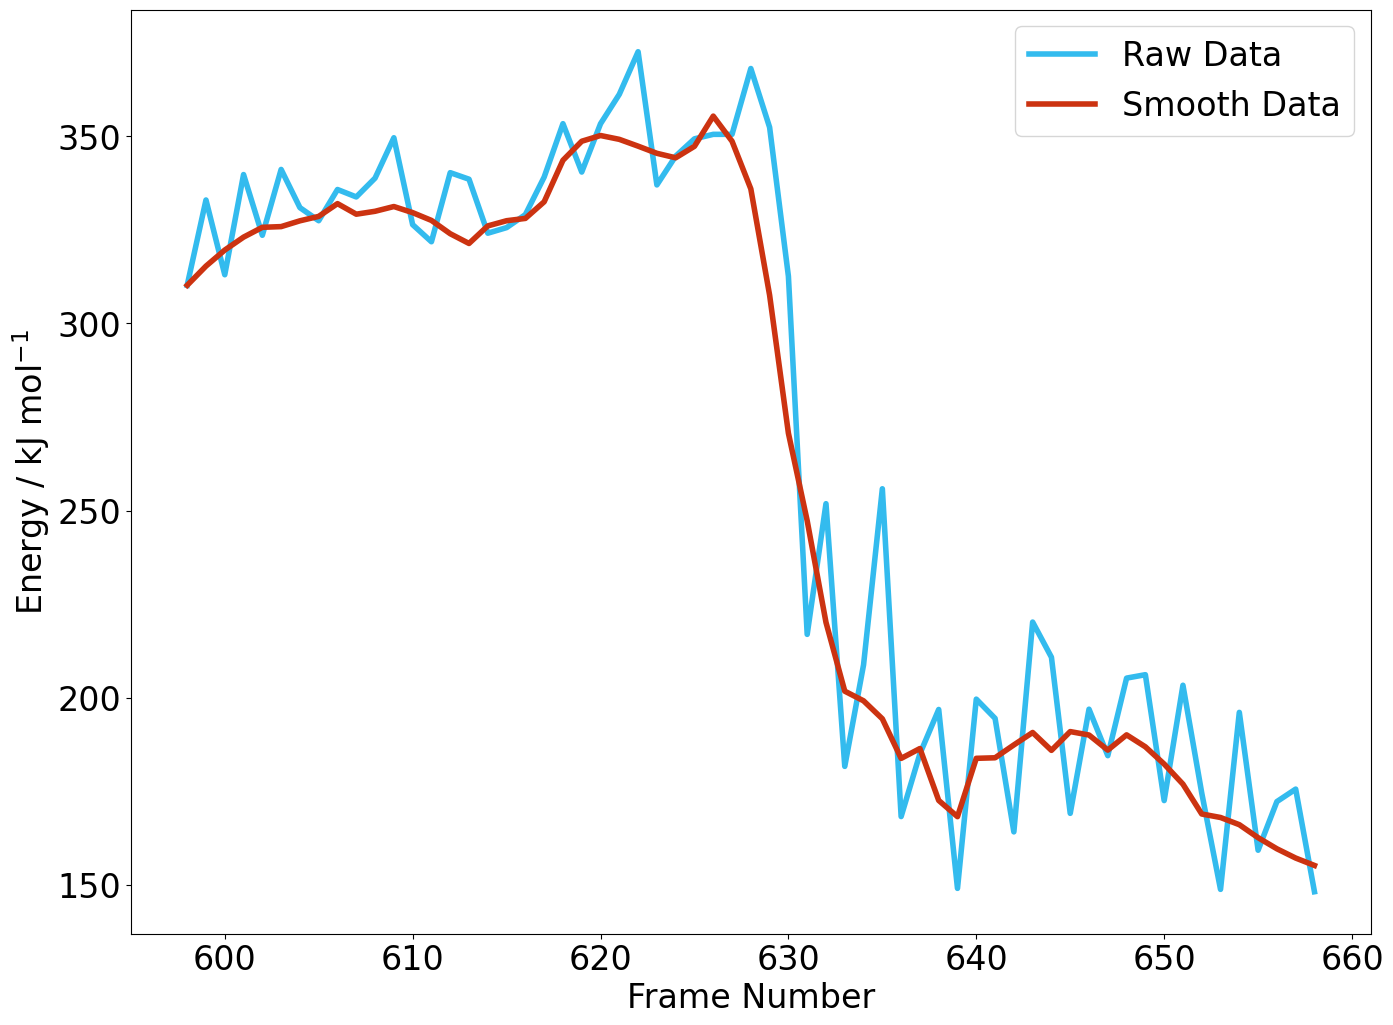

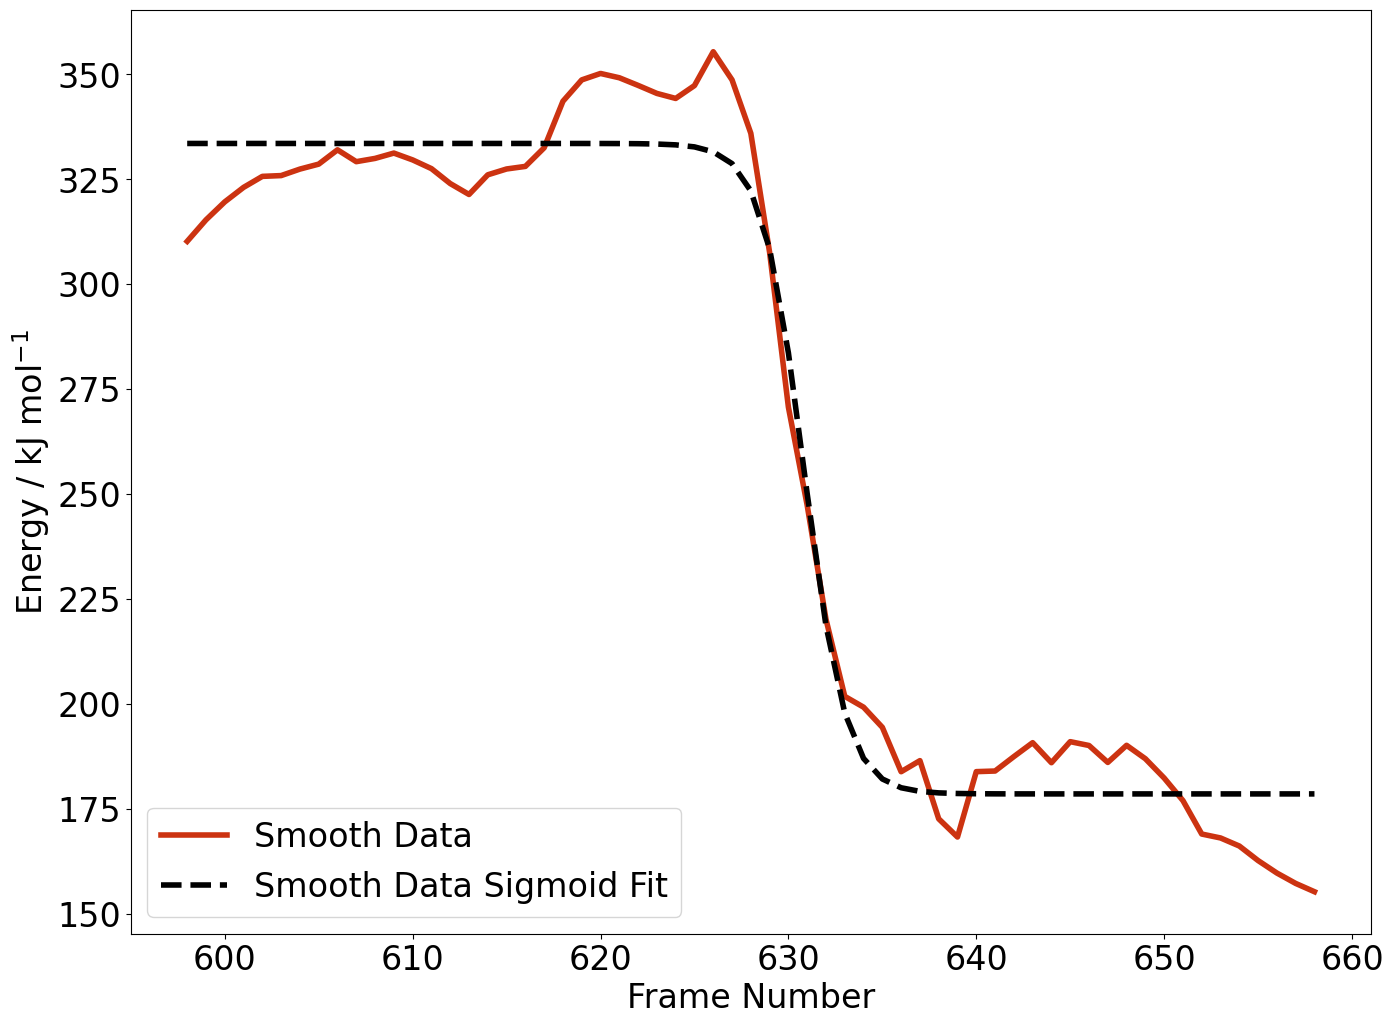

In [12]:
itr = 0
energetics = [] # 0 is original profile, first frame set to 0
                # 1 is sigmoid
                # 2 is energy difference
                # 3 is ts barrier
                # 4 is sav-gol filterred data
                # 5 is sav-gol filter sigmoid
                # 6 is sav-gol energy difference
                # 7 is sav-gol ts barrier
                # 8 is ts point in energy array
                # 9 is ts point in sav-gol array
                # 10 is ts point energy
rangex = 30
for itr in range( energy.shape[0]):
    tmp = []
    xdata = np.linspace(0,rangex+2,rangex*2+1)
    pt = ts_points[itr][1]
    if pt == -1:
        print(itr)
        continue
    ydata = energy[itr][pt-rangex:pt+rangex+1]
    tmp.append(ydata-ydata[0])
    p0 = [max(ydata), np.mean(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='lm')
    sigm = sigmoid(xdata,*popt)
    tmp.append(sigm-ydata[0])
    tmp.append(np.max(sigm)-np.min(sigm))
    tmp.append(ydata[30] - np.max(sigm))
    ydata_flt = savgol_filter(ydata, window_length=10, polyorder=2)
    tmp.append(ydata_flt-ydata_flt[0])
    p0 = [max(ydata_flt), np.mean(xdata),1,min(ydata_flt)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata_flt,p0, method='lm')
    sigm = sigmoid(xdata,*popt)
    ptg = findTS(ydata_flt,criteria = np.mean(ydata_flt))
    tmp.append(sigm-ydata_flt[0])
    tmp.append(np.max(sigm)-np.min(sigm))
    tmp.append(ydata_flt[ptg]- np.max(sigm))
    tmp.append(pt)
    tmp.append(ptg)
    tmp.append(ydata_flt[ptg])
    
    energetics.append(tmp)


dat_energy = np.empty(len(energetics))
svg_energy = np.empty(len(energetics))
dat_energy_ts = np.empty(len(energetics))
svg_energy_ts = np.empty(len(energetics))
svg_energy_ts_point = np.empty(len(energetics))
for i,el in enumerate(energetics):
    dat_energy[i] = el[2]
    svg_energy[i] = el[6]
    dat_energy_ts[i] = el[3]
    svg_energy_ts[i] = el[7]
    svg_energy_ts_point[i] = el[10]
print('Raw')
print('mean: {:.1f} median: {:.1f} dev: {:.1f}'.format(np.mean(dat_energy)*4.184,np.median(dat_energy)*4.184,np.std(dat_energy)*4.184))
print('mean: {:.1f} median: {:.1f} dev: {:.1f}'.format(np.mean(dat_energy_ts)*4.184,np.median(dat_energy_ts)*4.184,np.std(dat_energy_ts)*4.184))
print('\nSmooth')
print('mean: {:.1f} median: {:.1f} dev: {:.1f}'.format(np.mean(svg_energy)*4.184,np.median(svg_energy)*4.184,np.std(svg_energy)*4.184))
print('mean: {:.1f} median: {:.1f} dev: {:.1f}'.format(np.mean(svg_energy_ts)*4.184,np.median(svg_energy_ts)*4.184,np.std(svg_energy_ts)*4.184))

fontsize = 24
crx = 1
for i,el in enumerate(energetics):
    if i == crx:
        refen = energy[ts_points[crx][0]][ts_points[crx][1]]
        x_points = np.linspace(0,60,61)+ts_points[crx][1]
        plt.figure(figsize = (16,12))
        plt.plot(x_points,el[0]*4.184+refen*4.184, color = '#33BBEE', lw = 4, label = 'Raw Data')
        # plt.plot(el[1], color = 'green')
        plt.plot(x_points,el[4]*4.184+refen*4.184, color = '#CC3311', lw = 4, label = 'Smooth Data')
        # plt.plot(el[5], color = 'red')
        # plt.vlines(x=30,ymin = -50, ymax=np.max(el[0]), color = 'black')
        # plt.vlines(x=el[-1],ymin = -50, ymax=np.max(el[0]), color = 'black')
        plt.xlabel('Frame Number', fontsize = fontsize)
        plt.ylabel('Energy / kJ mol$^{-1}$', fontsize = fontsize)
        plt.yticks(fontsize = fontsize)
        plt.xticks(fontsize = fontsize)
        plt.legend(fontsize = fontsize)
        
        # plt.title(i)
        plt.show()

fontsize = 24
crx = 1
for i,el in enumerate(energetics):
    if i == crx:
        refen = energy[ts_points[crx][0]][ts_points[crx][1]]
        x_points = np.linspace(0,60,61)+ts_points[crx][1]
        plt.figure(figsize = (16,12))
        plt.plot(x_points,el[4]*4.184+refen*4.184, color = '#CC3311', lw = 4, label = 'Smooth Data')
        plt.plot(x_points,el[5]*4.184+refen*4.184, color = 'black', lw = 4, label = 'Smooth Data Sigmoid Fit', ls = '--')
        
        plt.xlabel('Frame Number', fontsize = fontsize)
        plt.ylabel('Energy / kJ mol$^{-1}$', fontsize = fontsize)
        plt.yticks(fontsize = fontsize)
        plt.xticks(fontsize = fontsize)
        plt.legend(fontsize = fontsize, loc = 'lower left')
        plt.show()

# Correlation Plots

We must first calculate the correlation matrix of the coordinates.

In [13]:
correlated = np.argwhere(abs(R_mat_internal[0])>0.7)
R_Matrix_strong_corr = np.empty((len(correlated)+1,len(correlated)))
R_Matrix_strong_corr[0] = R_mat_internal[0][np.array(correlated).flatten()]
for i in range(len(correlated)):
    for j in range(len(correlated)):
        R_Matrix_strong_corr[i+1][j] = R_mat_internal[i+1][j]
normalized_arr = normalize(arr, condense=True)
R_matrix = np.empty((134,133))
R_matrix[0] = r_regression(normalized_arr,arr_energy)
for i in range(normalized_arr.shape[1]):
    R_matrix[i+1] = r_regression(normalized_arr,normalized_arr[:,i])

We can then plot the correlation coefficients in a matrix style image.

Here below, the correlation plot for the internal coordinates can be seen. Negative values indicate negative correlation, positive values poositive correlation and 0 no correlation.

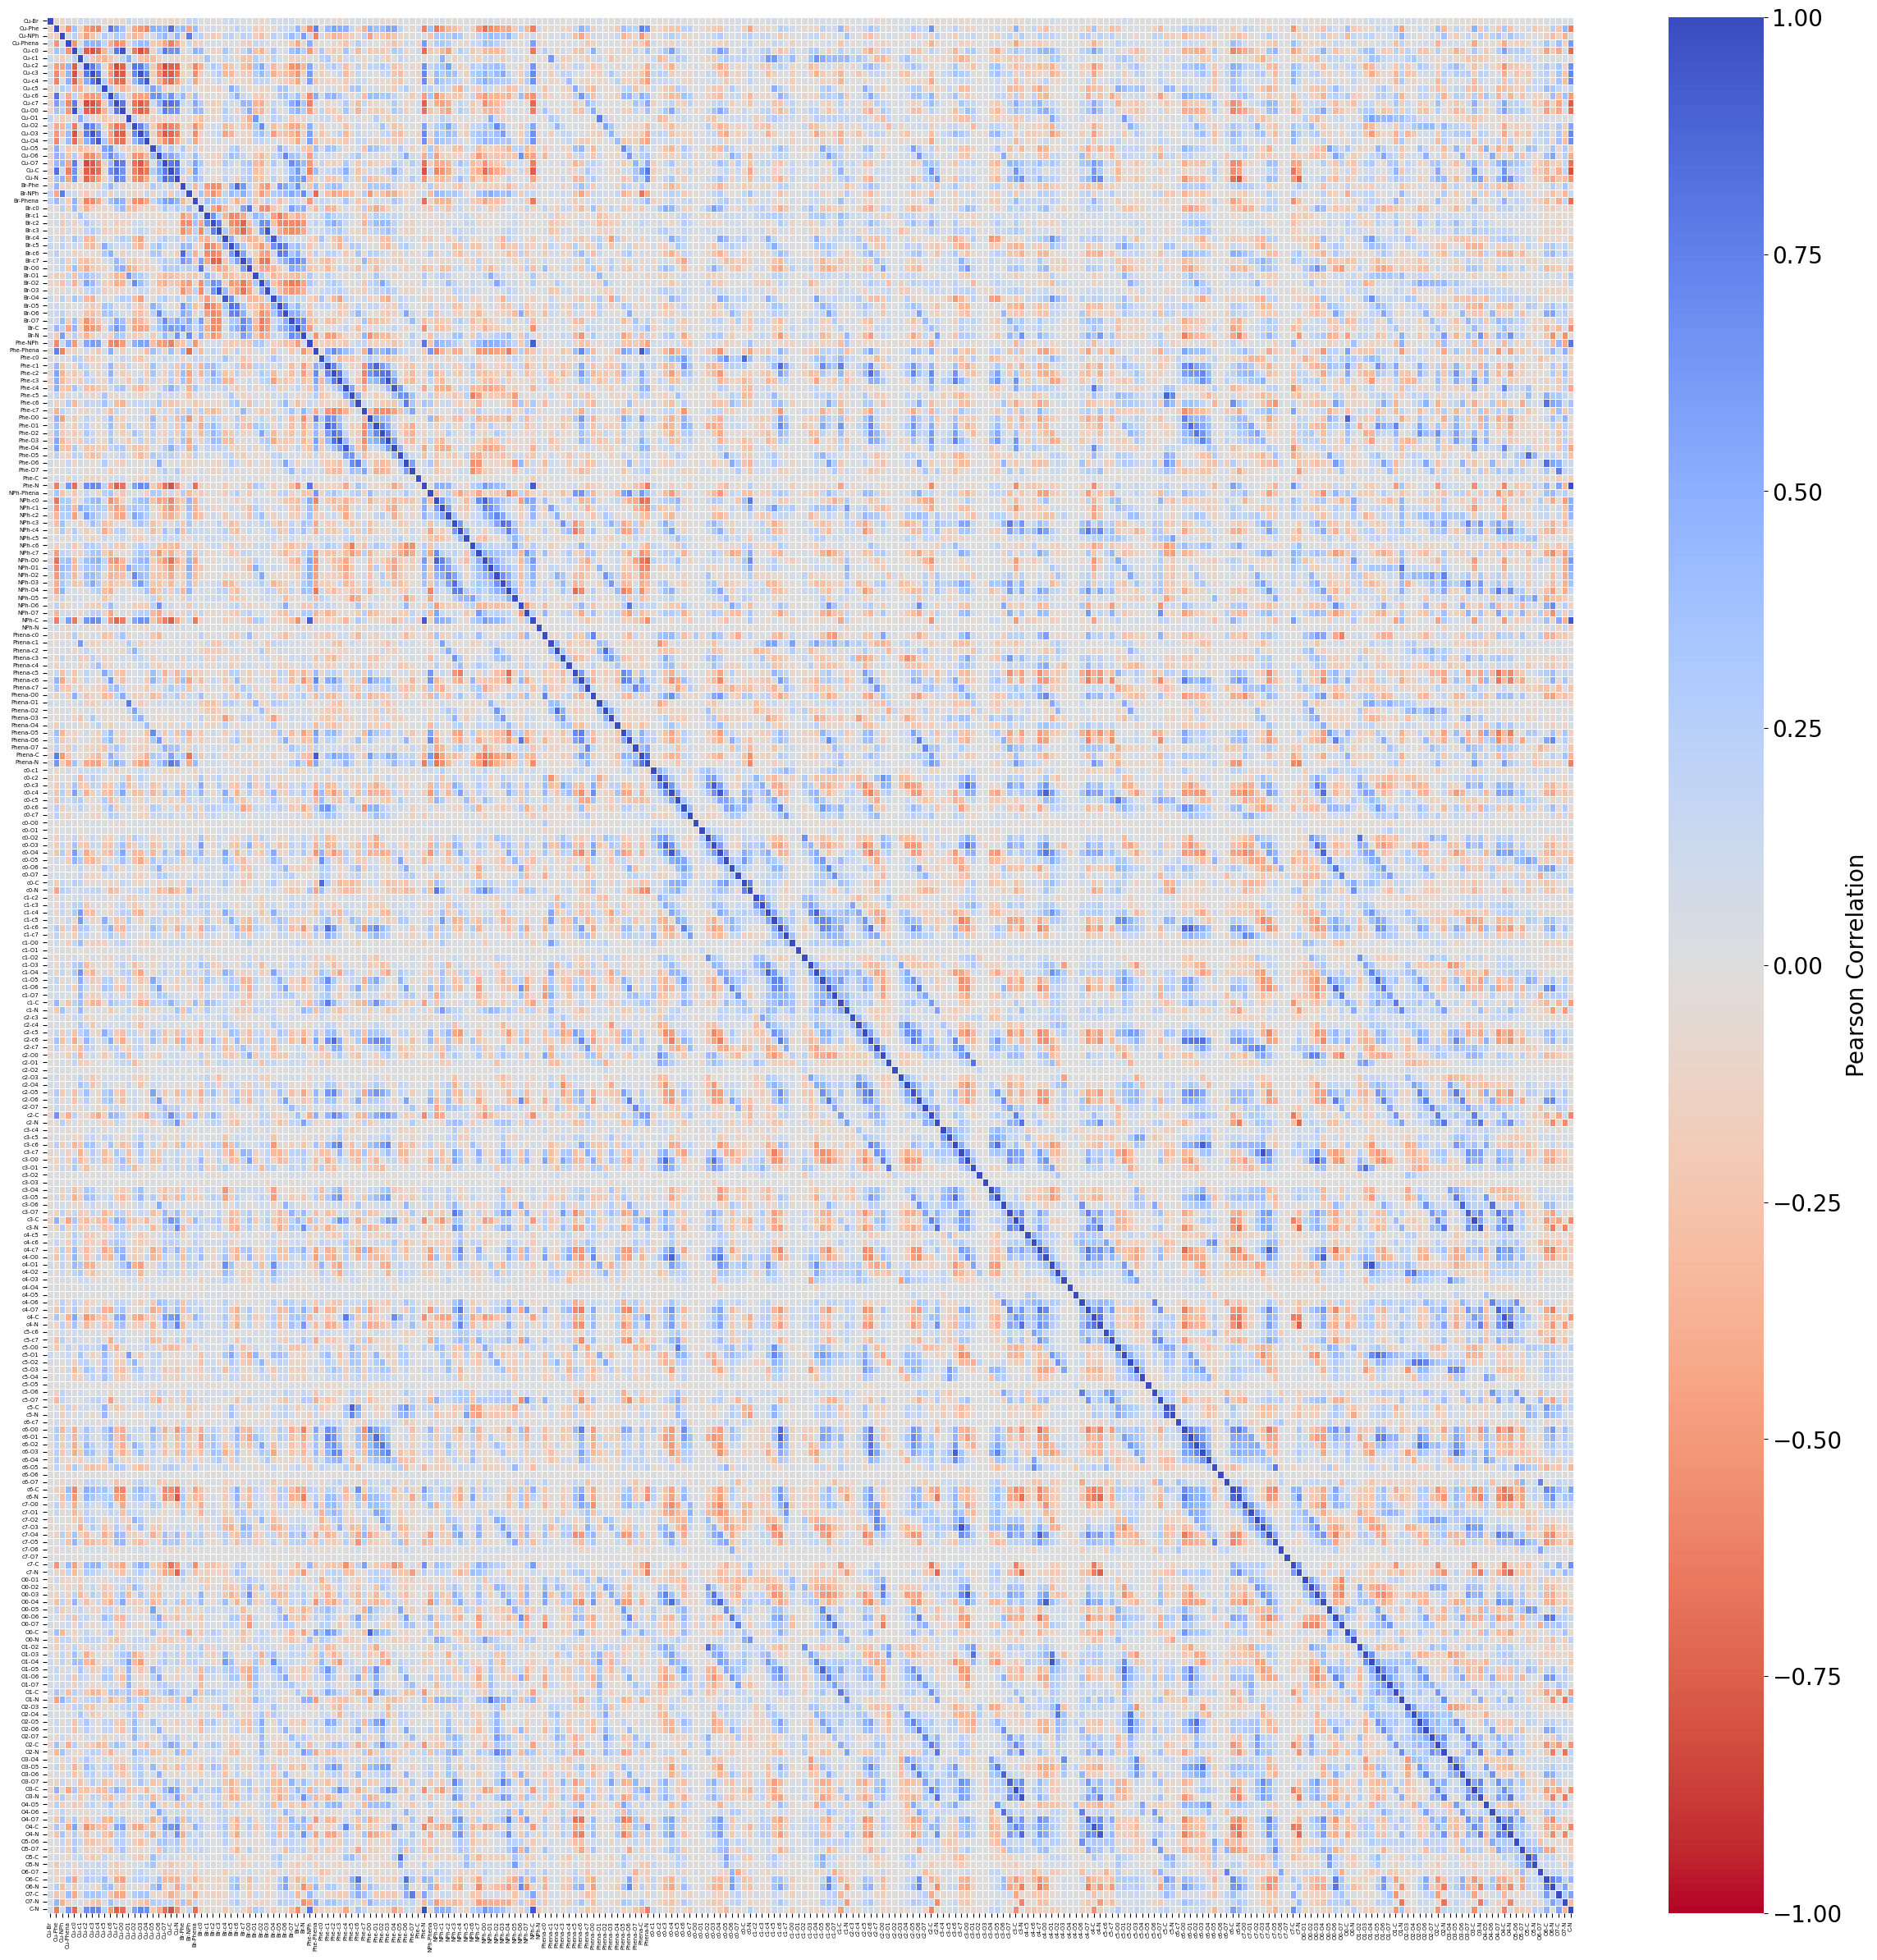

In [14]:
array_to_plot = R_mat_internal[1:len(distances)+1,:len(distances)]
xticklabels = heatmap_labels[:len(distances)]
yticklabels = heatmap_labels[:len(distances)]

fontsize = 5
fig, ax = plt.subplots(figsize=(30,30))
sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(array_to_plot, ax = ax, annot=False, linewidth=0.5, cmap =  sns.color_palette("coolwarm_r", as_cmap=True),
           xticklabels=xticklabels, yticklabels=yticklabels, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = fontsize)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = fontsize)
ax.figure.axes[-1].set_ylabel('Pearson Correlation', size=20)
ax.figure.axes[-1].tick_params(labelsize=20)
plt.show()

# PCA and LDA

Principal Componenet Analysis (PCA) and Linear Discriminant Analysis (LDA) are two methods that can be used for dimensionality reduction and feature selection. While PCA is an unsupervised method, which aims to capture the highest variance in the dataset. LDA attempts to achieve the best possible separation between the various classes.

PCA:

Wold, S.; Esbensen, K.; Geladi, P. Principal Component Analysis. Chemometrics and Intelligent Laboratory Systems 1987, 2 (1), 37–52. https://doi.org/10.1016/0169-7439(87)80084-9.

LDA:

Mika, S.; Ratsch, G.; Weston, J.; Scholkopf, B.; Mullers, K. R. Fisher Discriminant Analysis with Kernels. In Neural Networks for Signal Processing IX: Proceedings of the 1999 IEEE Signal Processing Society Workshop (Cat. No.98TH8468); 1999; pp 41–48. https://doi.org/10.1109/NNSP.1999.788121.

### Internal Coordinates

explained variance ratio (first two components): [0.99873157 0.00126843]


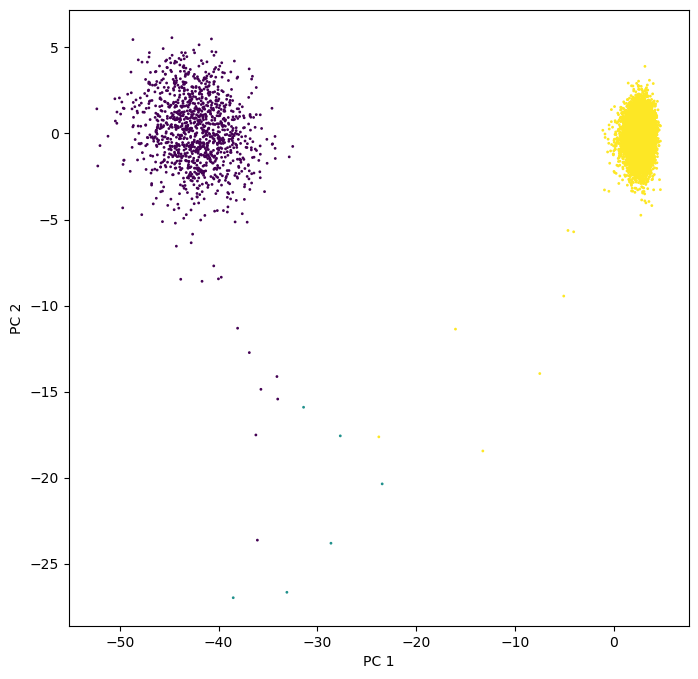

In [15]:
lda_all_int = calcLDA(norm_internal, class_labels, borders = (-3,3), colors = class_labels)
X_t = lda_all_int.transform(norm_internal)
Loading_data.append(np.mean(np.abs(lda_all_int.scalings_),axis=1))
Loading_labels.append('LDA_all_internal')
# plt.plot(lda_all_int.scalings_) #uncomment this to plot the loadings vs coordinates

[0. 0.]
Ellipse: ctr:(0, 0) , width:1.7789957662784026, height:2.198902922723857, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.4956146889215676, height:1.3311300929807373, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.1554286578262425, height:1.831427667428163, angle:0


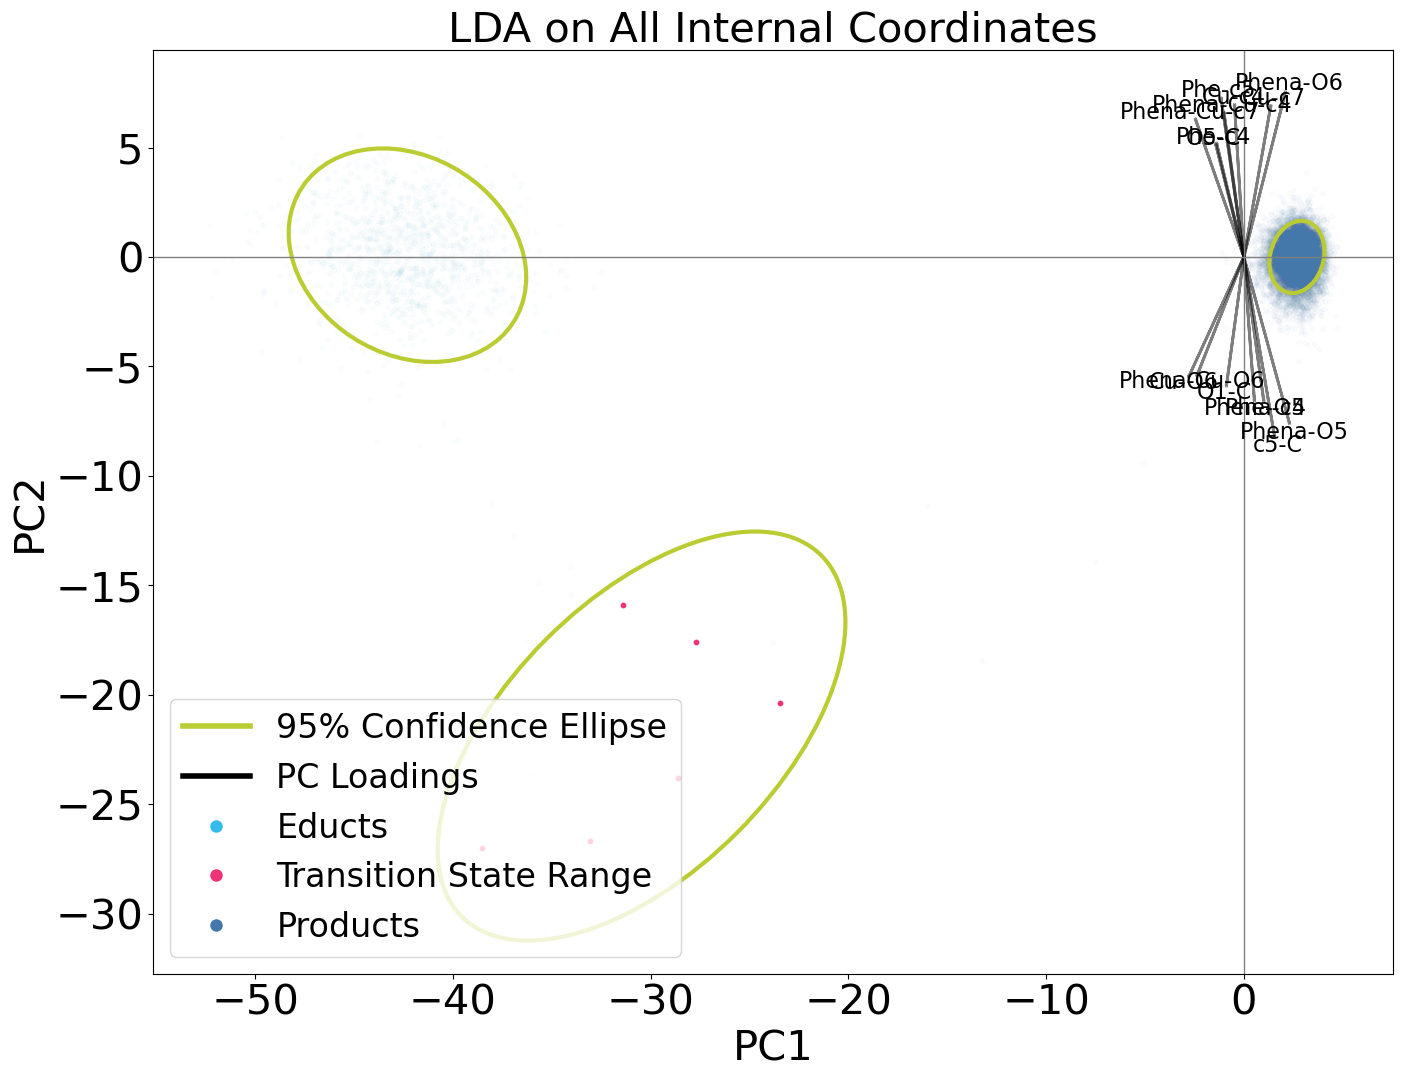

[0. 0.]
Ellipse: ctr:(0, 0) , width:1.7789957662784026, height:2.198902922723857, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.4956146889215676, height:1.3311300929807373, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.1554286578262425, height:1.831427667428163, angle:0


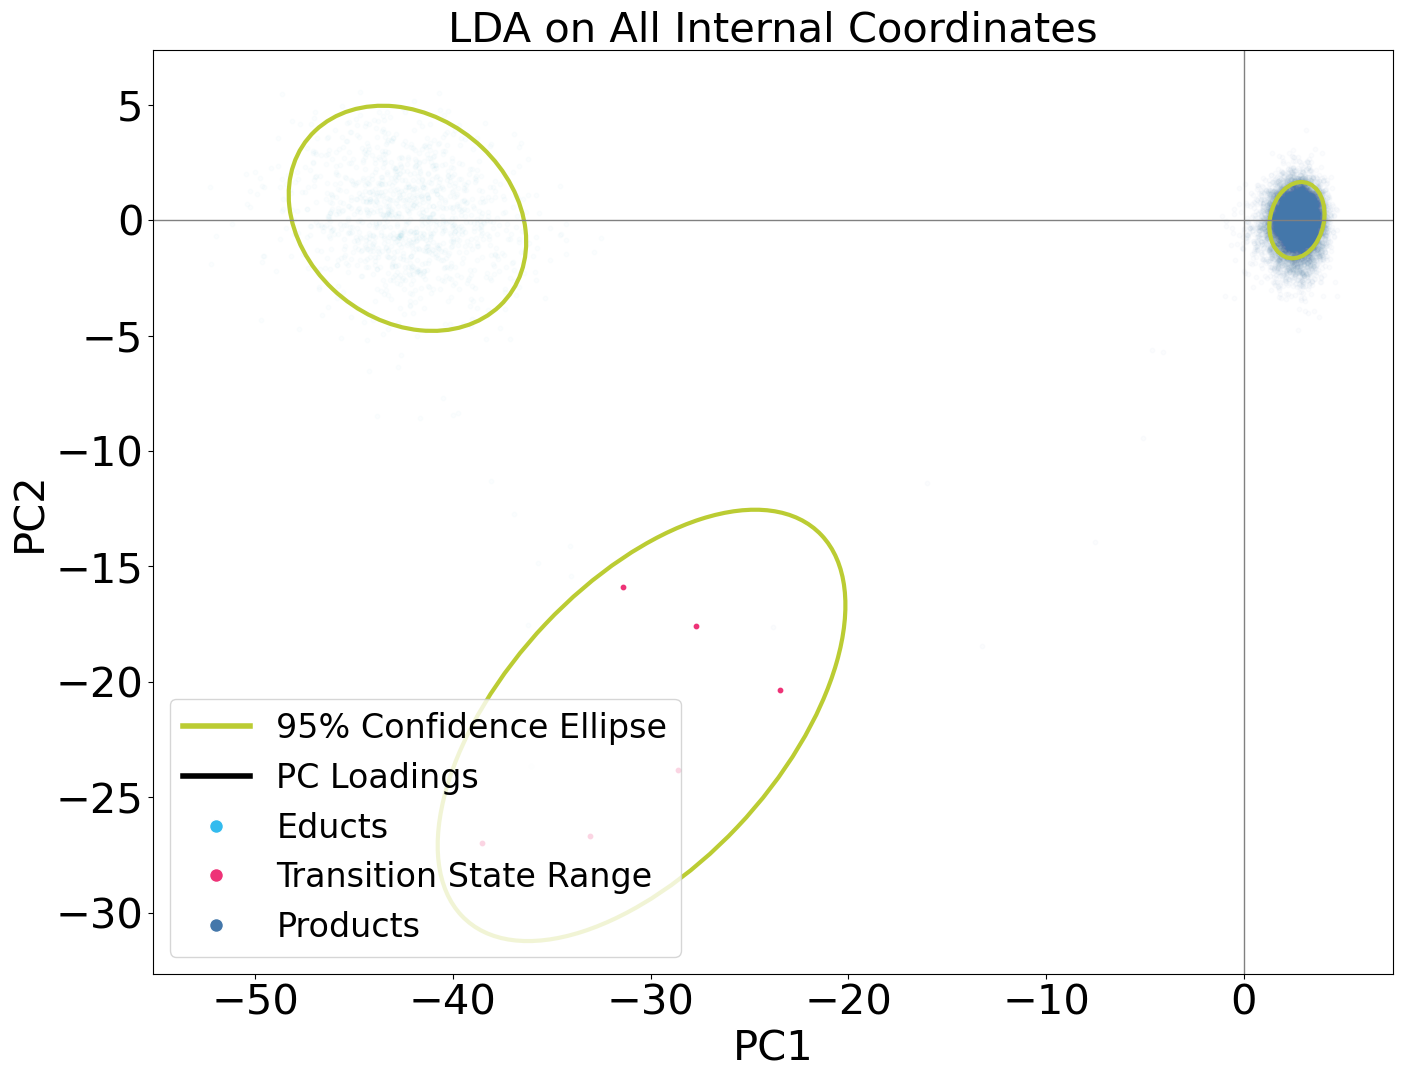

In [16]:
fontsize = 30
fig, ax = plt.subplots(1, 1, figsize = (16,12))
# ax.scatter(X_t[:,0], X_t[:,1], s=5)
custom_lines = [Line2D([0], [0], color='#BBCC33', lw=4, label='95% Confidence Ellipse'),
                Line2D([0], [0], color='black', lw=4, label='PC Loadings'),
                Line2D([0], [0], marker='o', color='w', label='Educts', markerfacecolor='#33BBEE', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Transition State Range', markerfacecolor='#EE3377', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Products', markerfacecolor='#4477AA', markersize=10)]

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

# confidence_ellipse(X_t[:,0][np.argwhere(class_labels==int(0))].flatten(), X_t[:,1][np.argwhere(class_labels==int(0))].flatten(), ax, edgecolor='red', lw = 15,n_std = 3)

myplotAX(ax,X_t[:,0:2], lda_all_int.scalings_, colors=['#33BBEE','#EE3377','#4477AA'], labels = heatmap_labels, scale_coeff=0.05, coeff_limit=90, lw = 3, n_std = 2, loadings = True) 
ax.set_title('LDA on All Internal Coordinates', fontsize = fontsize)
ax.set_xlabel('PC1', fontsize = fontsize)
ax.set_ylabel('PC2', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(handles = custom_lines, fontsize = fontsize*0.8, loc = 'lower left')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (16,12))
# ax.scatter(X_t[:,0], X_t[:,1], s=5)
custom_lines = [Line2D([0], [0], color='#BBCC33', lw=4, label='95% Confidence Ellipse'),
                Line2D([0], [0], color='black', lw=4, label='PC Loadings'),
                Line2D([0], [0], marker='o', color='w', label='Educts', markerfacecolor='#33BBEE', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Transition State Range', markerfacecolor='#EE3377', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Products', markerfacecolor='#4477AA', markersize=10)]

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
myplotAX(ax,X_t[:,0:2], lda_all_int.scalings_, colors=['#33BBEE','#EE3377','#4477AA'], labels = heatmap_labels, scale_coeff=0.05, coeff_limit=90, lw = 3, n_std = 2, loadings = None) 
ax.set_title('LDA on All Internal Coordinates', fontsize = fontsize)
ax.set_xlabel('PC1', fontsize = fontsize)
ax.set_ylabel('PC2', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(handles = custom_lines, fontsize = fontsize*0.8, loc = 'lower left')
plt.show()

explained variance ratio (first two components): [0.15476728 0.1045697  0.08826465]
[0.89063444 0.60176397 0.50793385]


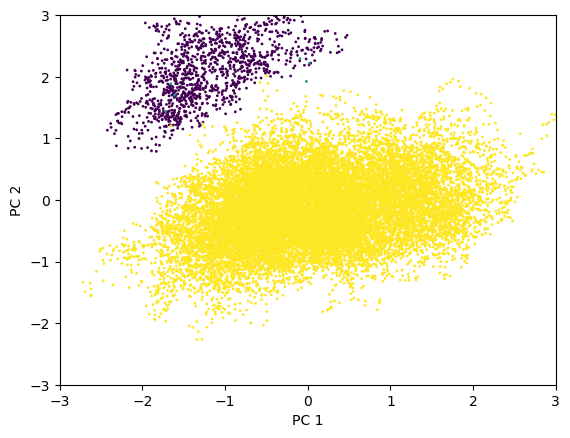

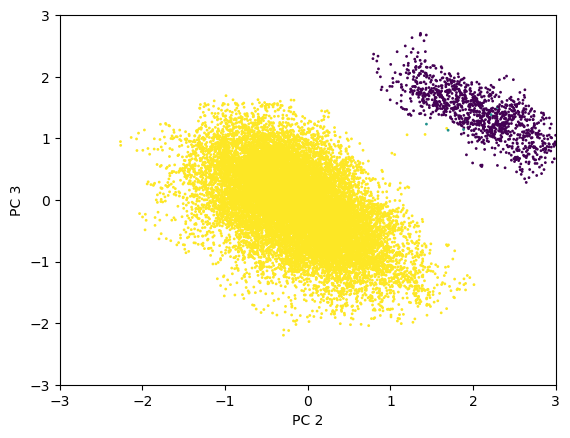

In [17]:
pca_all_pca, pca_all_loadings, pca_all_correlations = calcPCA(norm_internal, borders = (-3,3), colors = class_labels)
X_t = pca_all_pca.transform(norm_internal)

Loading_data.append(np.mean(np.abs(pca_all_pca.components_.T),axis=1))
Loading_labels.append('PCA_all_internal')
# plt.plot(pca_all_pca.components_.T) #uncomment this to plot the loadings vs coordinates

[0. 0.]
Ellipse: ctr:(0, 0) , width:2.529417523381321, height:1.2657199502305019, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.691870535983272, height:0.8682355771938467, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.279940509322268, height:1.6738791097182963, angle:0


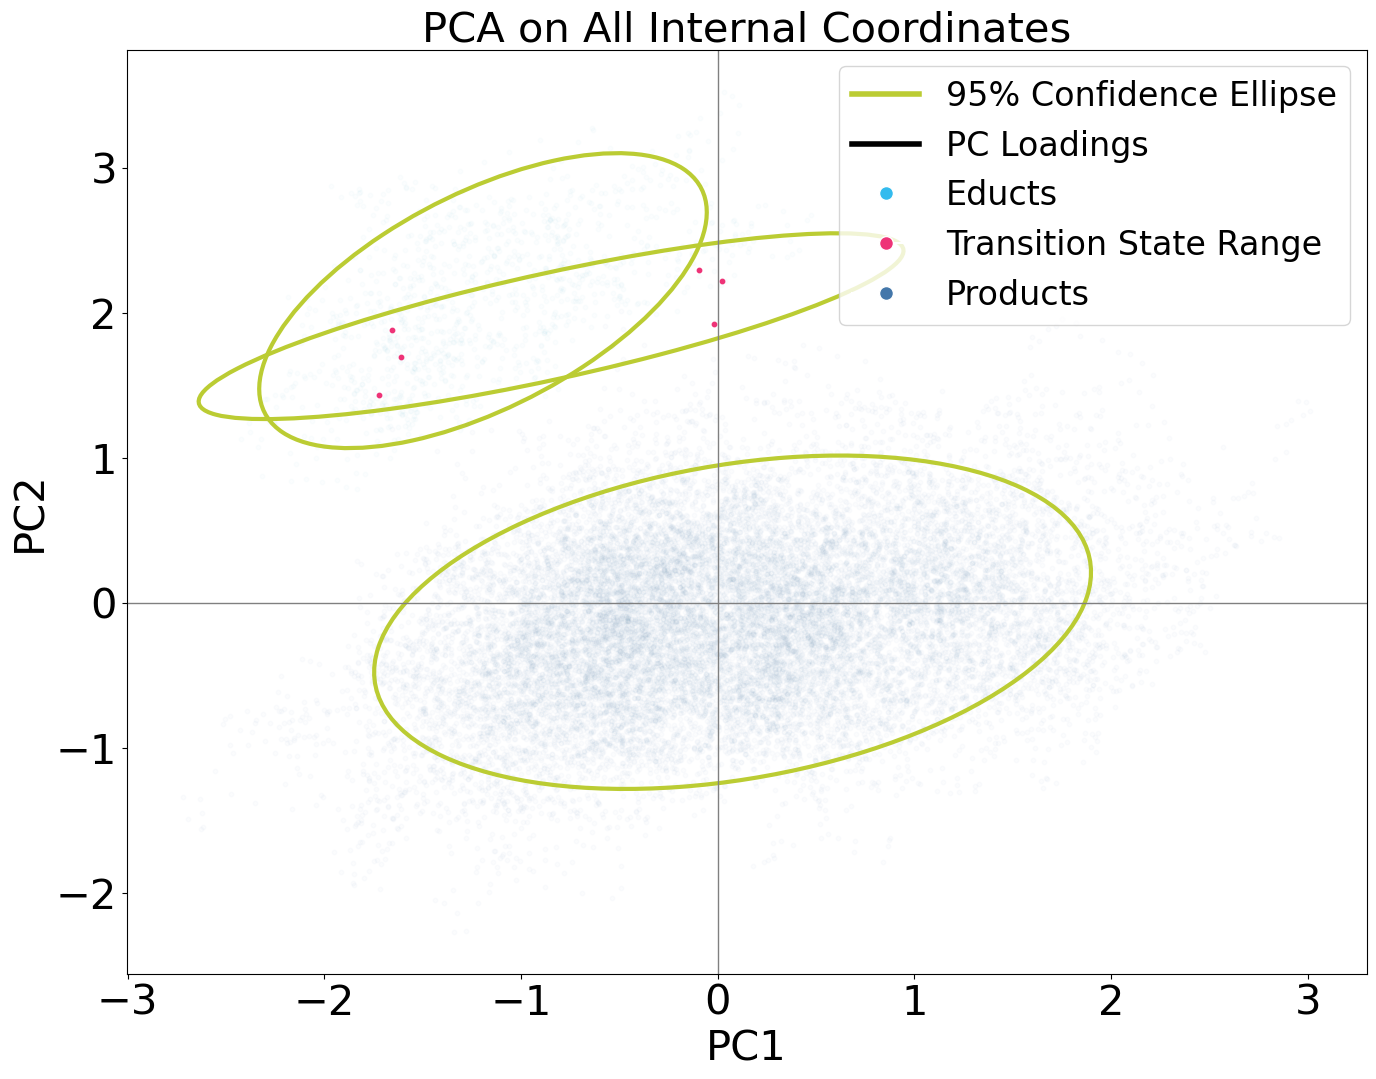

[0. 0.]
Ellipse: ctr:(0, 0) , width:2.529417523381321, height:1.2657199502305019, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.691870535983272, height:0.8682355771938467, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.279940509322268, height:1.6738791097182963, angle:0


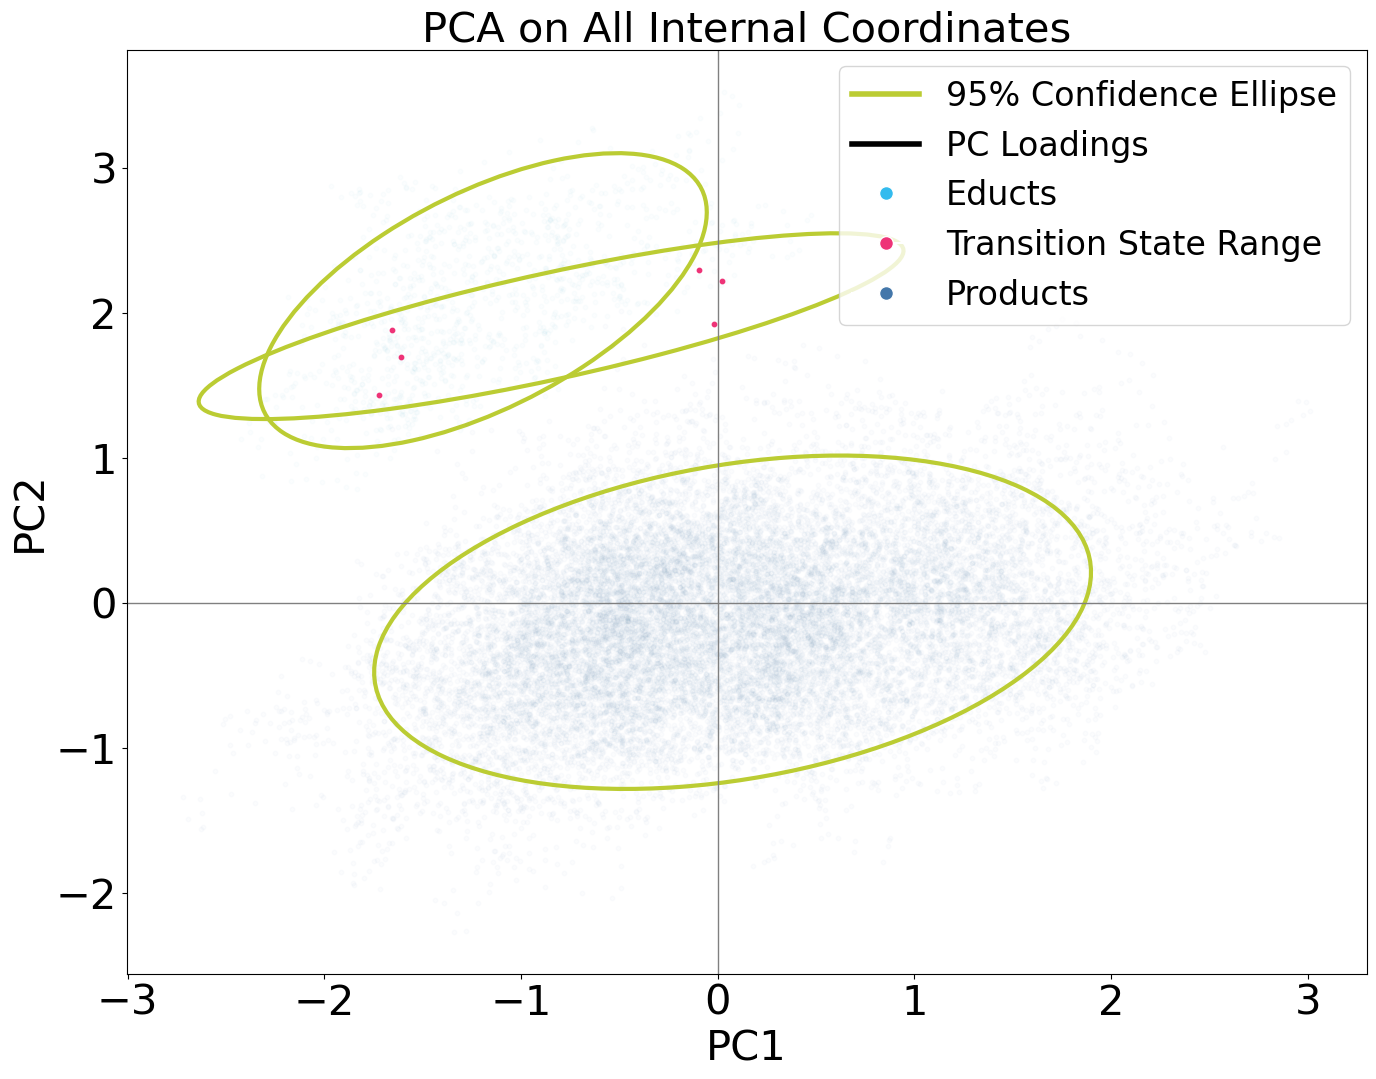

In [18]:
fontsize = 30
fig, ax = plt.subplots(1, 1, figsize = (16,12))
# ax.scatter(X_t[:,0], X_t[:,1], s=5)
custom_lines = [Line2D([0], [0], color='#BBCC33', lw=4, label='95% Confidence Ellipse'),
                Line2D([0], [0], color='black', lw=4, label='PC Loadings'),
                Line2D([0], [0], marker='o', color='w', label='Educts', markerfacecolor='#33BBEE', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Transition State Range', markerfacecolor='#EE3377', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Products', markerfacecolor='#4477AA', markersize=10)]

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

# confidence_ellipse(X_t[:,0][np.argwhere(class_labels==int(0))].flatten(), X_t[:,1][np.argwhere(class_labels==int(0))].flatten(), ax, edgecolor='red', lw = 15,n_std = 3)

myplotAX(ax,X_t[:,0:2], pca_all_pca.components_.T, colors=['#33BBEE','#EE3377','#4477AA'], labels = heatmap_labels, scale_coeff=5, coeff_limit=0.175, lw = 3, n_std = 2, loadings = True) 
ax.set_title('PCA on All Internal Coordinates', fontsize = fontsize)
ax.set_xlabel('PC1', fontsize = fontsize)
ax.set_ylabel('PC2', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(handles = custom_lines, fontsize = fontsize*0.8)
plt.show()
fontsize = 30
fig, ax = plt.subplots(1, 1, figsize = (16,12))
# ax.scatter(X_t[:,0], X_t[:,1], s=5)
custom_lines = [Line2D([0], [0], color='#BBCC33', lw=4, label='95% Confidence Ellipse'),
                Line2D([0], [0], color='black', lw=4, label='PC Loadings'),
                Line2D([0], [0], marker='o', color='w', label='Educts', markerfacecolor='#33BBEE', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Transition State Range', markerfacecolor='#EE3377', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Products', markerfacecolor='#4477AA', markersize=10)]

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

# confidence_ellipse(X_t[:,0][np.argwhere(class_labels==int(0))].flatten(), X_t[:,1][np.argwhere(class_labels==int(0))].flatten(), ax, edgecolor='red', lw = 15,n_std = 3)

myplotAX(ax,X_t[:,0:2], pca_all_pca.components_.T, colors=['#33BBEE','#EE3377','#4477AA'], labels = heatmap_labels, scale_coeff=5, coeff_limit=0.175, lw = 3, n_std = 2, loadings = None) 
ax.set_title('PCA on All Internal Coordinates', fontsize = fontsize)
ax.set_xlabel('PC1', fontsize = fontsize)
ax.set_ylabel('PC2', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(handles = custom_lines, fontsize = fontsize*0.8)
plt.show()

# Decision trees

The decision trees have been used to quantify the internal coordinates which separate the various classes. The trees have been trained on the whole dataset, without normalization. the criterium for separation is the GINI entropy.

The trees were restricted to 8 leaves, to maintain the overall interpretability.

### Decision tree without class balancing

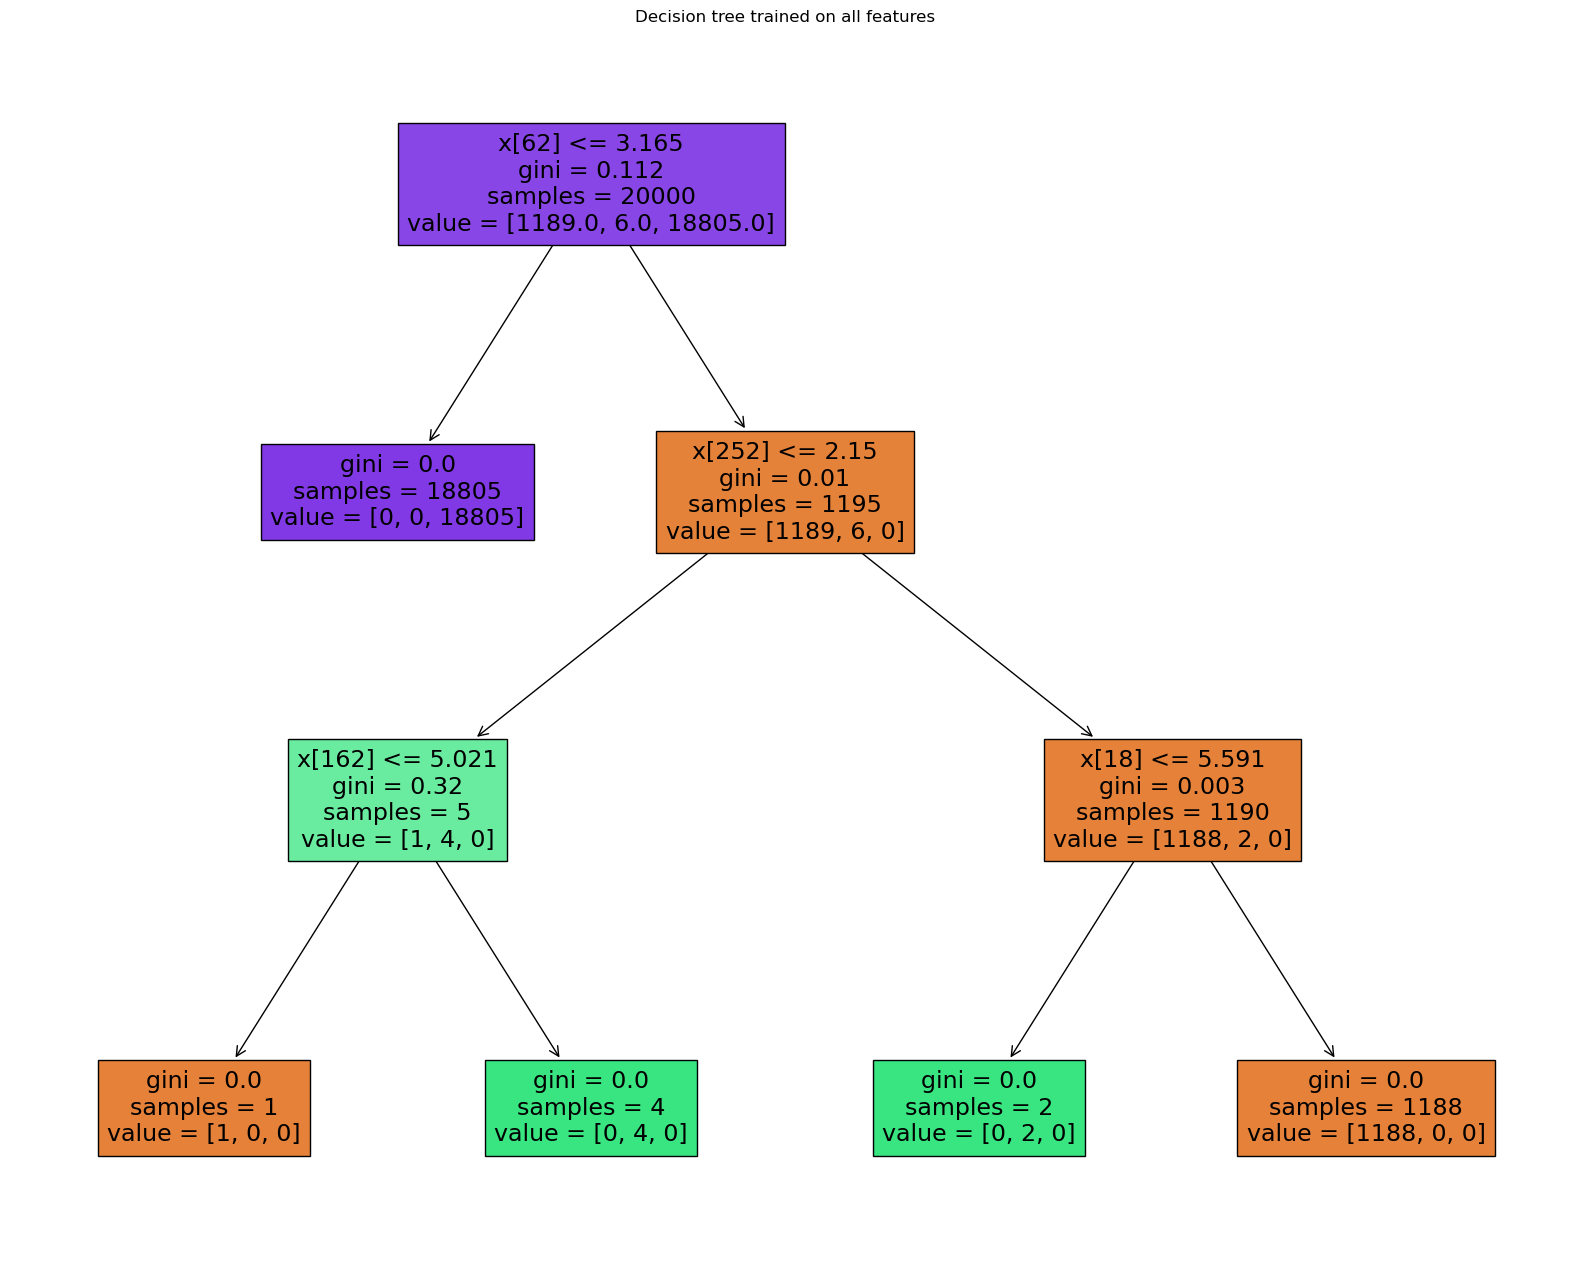

In [19]:
clf_no_weight_nonorm = calcTree(internal_coords,class_labels, leaf = 12,class_weight=None)

### Balance classes using oversampling

In [20]:
supersampler = pd.DataFrame(internal_coords, columns=heatmap_labels)
supersampler['class'] = class_labels
max_size = supersampler['class'].value_counts().max

crx0 = supersampler[supersampler['class']== 0].sample(max_size(), axis=0, replace=True)
crx1 = supersampler[supersampler['class']== 1].sample(max_size(), axis=0, replace=True)
crx2 = supersampler[supersampler['class']== 2].sample(max_size(), axis=0, replace=False)
frame_new = pd.concat([crx0,crx1,crx2])

### Decision tree with class balancing

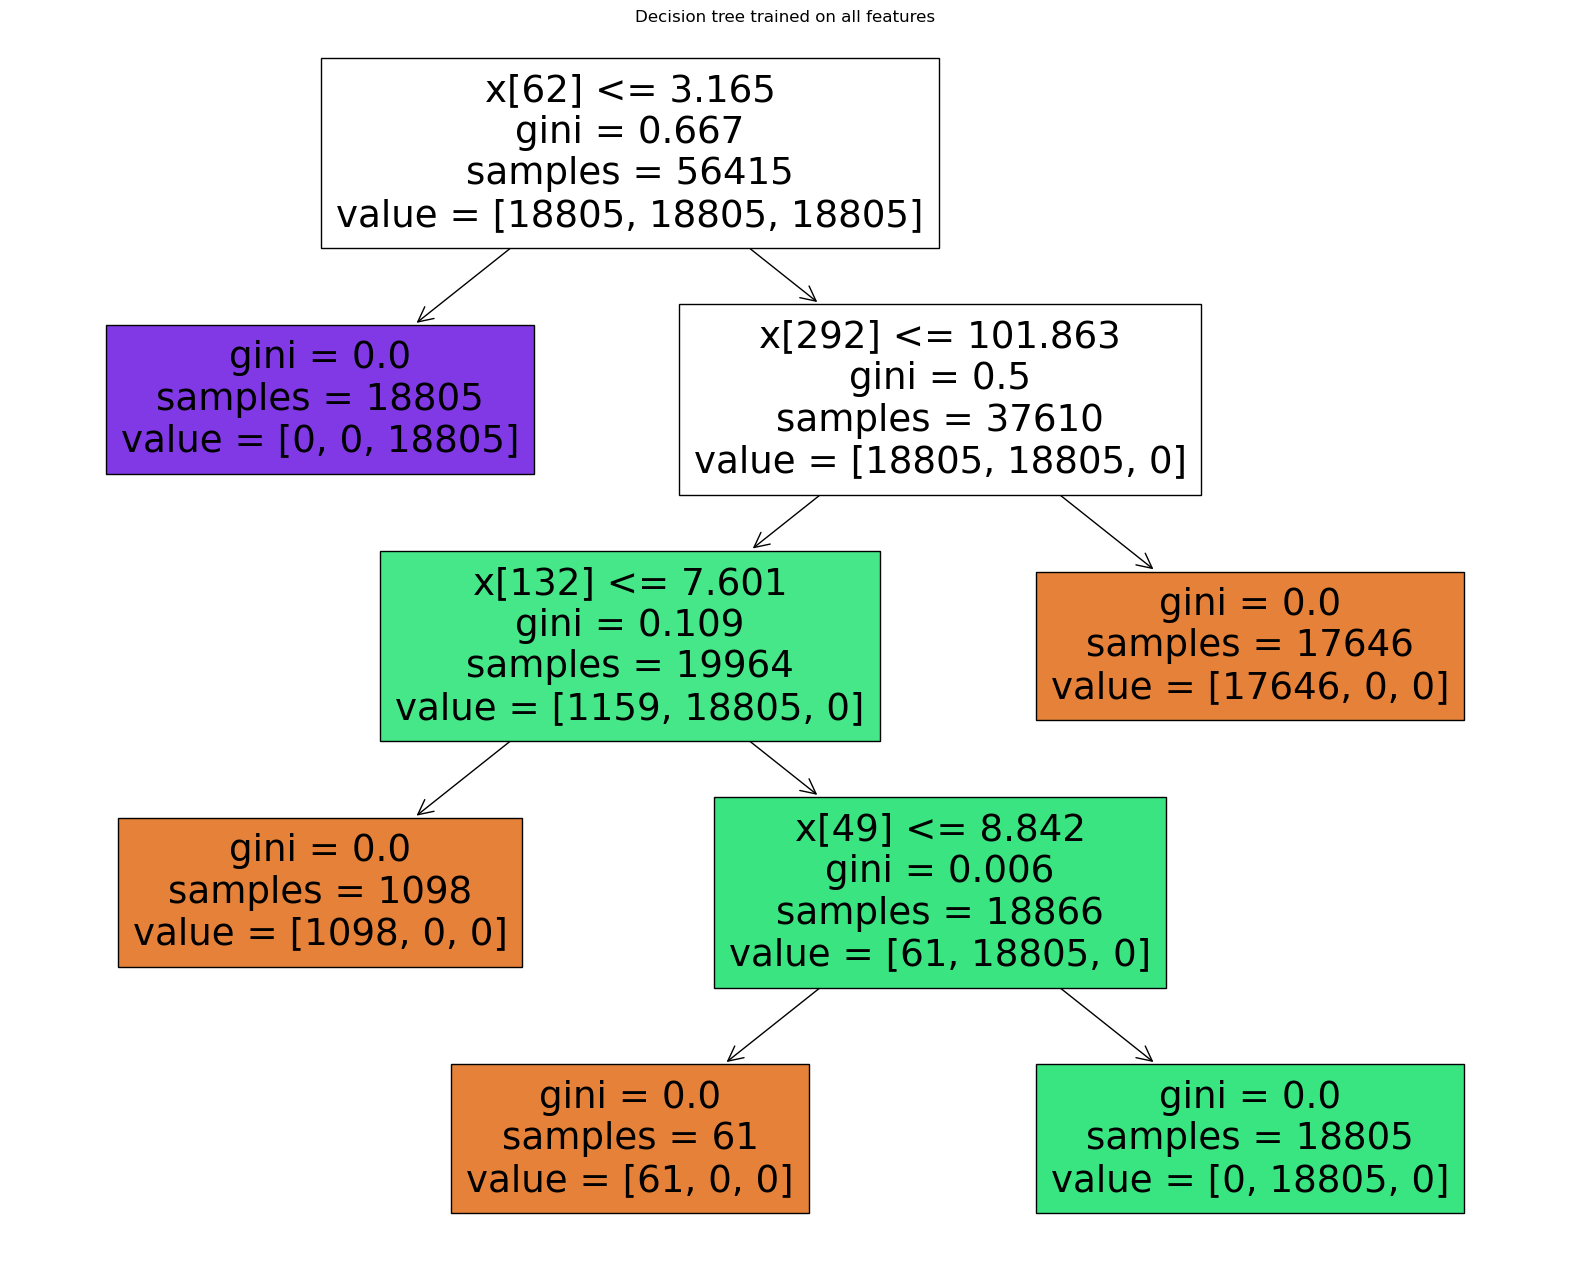

In [21]:
clf_weight_nonorm = calcTree(frame_new.values[:,:308],frame_new['class'].values, leaf = 8,class_weight=None)

#### Perform visualization of decision tree with DTreeViz

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

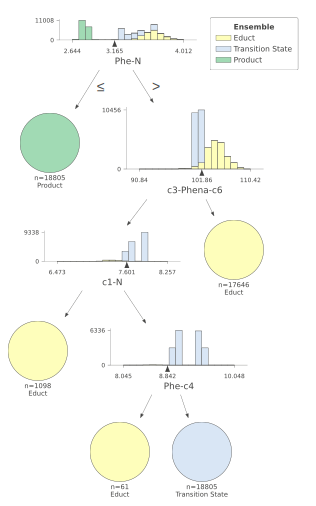

In [22]:
warnings.filterwarnings('ignore')
viz = dtreeviz.model(clf_weight_nonorm, X_train=frame_new.values[:,:308], y_train=frame_new['class'].values.astype(int),
                target_name="Ensemble",
                feature_names=heatmap_labels,
                class_names=['Educt','Transition State','Product'])
v = viz.view()
# v.save("tree.svg")  
v

# Decision Rules

Decision rules provide a semantic interpretation of a random forest classifier. 

In [23]:
feature_names = heatmap_labels
clf = SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=feature_names,
                 n_jobs=12)

for idx, species in enumerate(['Educt', 'Transition State', 'Product']):
    X, y = internal_coords,class_labels 
    clf.fit(X, y == idx)
    rules = clf.rules_[0:3]
    print("Rules for C-N coupling", species)
    for rule in rules:
        print(rule)
    print()
    print(20*'=')
    print()

Rules for C-N coupling Educt
('Cu-O6 > 5.591054201126099 and C-N > 2.048494517803192 and c0-Phena-c3 > 111.96659469604492', (1.0, 1.0, 1))
('O6-C > 5.059747934341431 and C-N > 2.150199294090271', (1.0, 0.9989648033126294, 1))


Rules for C-N coupling Transition State
('Cu-O6 <= 6.977841138839722 and Cu-O6 > 5.591054201126099 and c0-Phena-c4 <= 121.9091567993164', (1.0, 0.5, 1))
('Cu-O6 > 5.591054201126099 and O2-N > 9.250859260559082 and c0-Phena-c4 <= 121.9091567993164', (1.0, 0.5, 1))
('c2-O1 > 4.168100833892822 and c0-Phena-c4 <= 121.93124008178711 and NPh-C > 3.770640015602112', (1.0, 0.5, 1))


Rules for C-N coupling Product
('Phe-N <= 3.16453754901886', (1.0, 1.0, 31))
('C-N <= 1.7704376578330994', (1.0, 0.9999446275369723, 6))
('Phena-Cu-Br > 115.20261764526367', (1.0, 0.9997342898897303, 1))




# Cartesian coordinate data correlations

A plot of the correlations of the cartesian coordinates

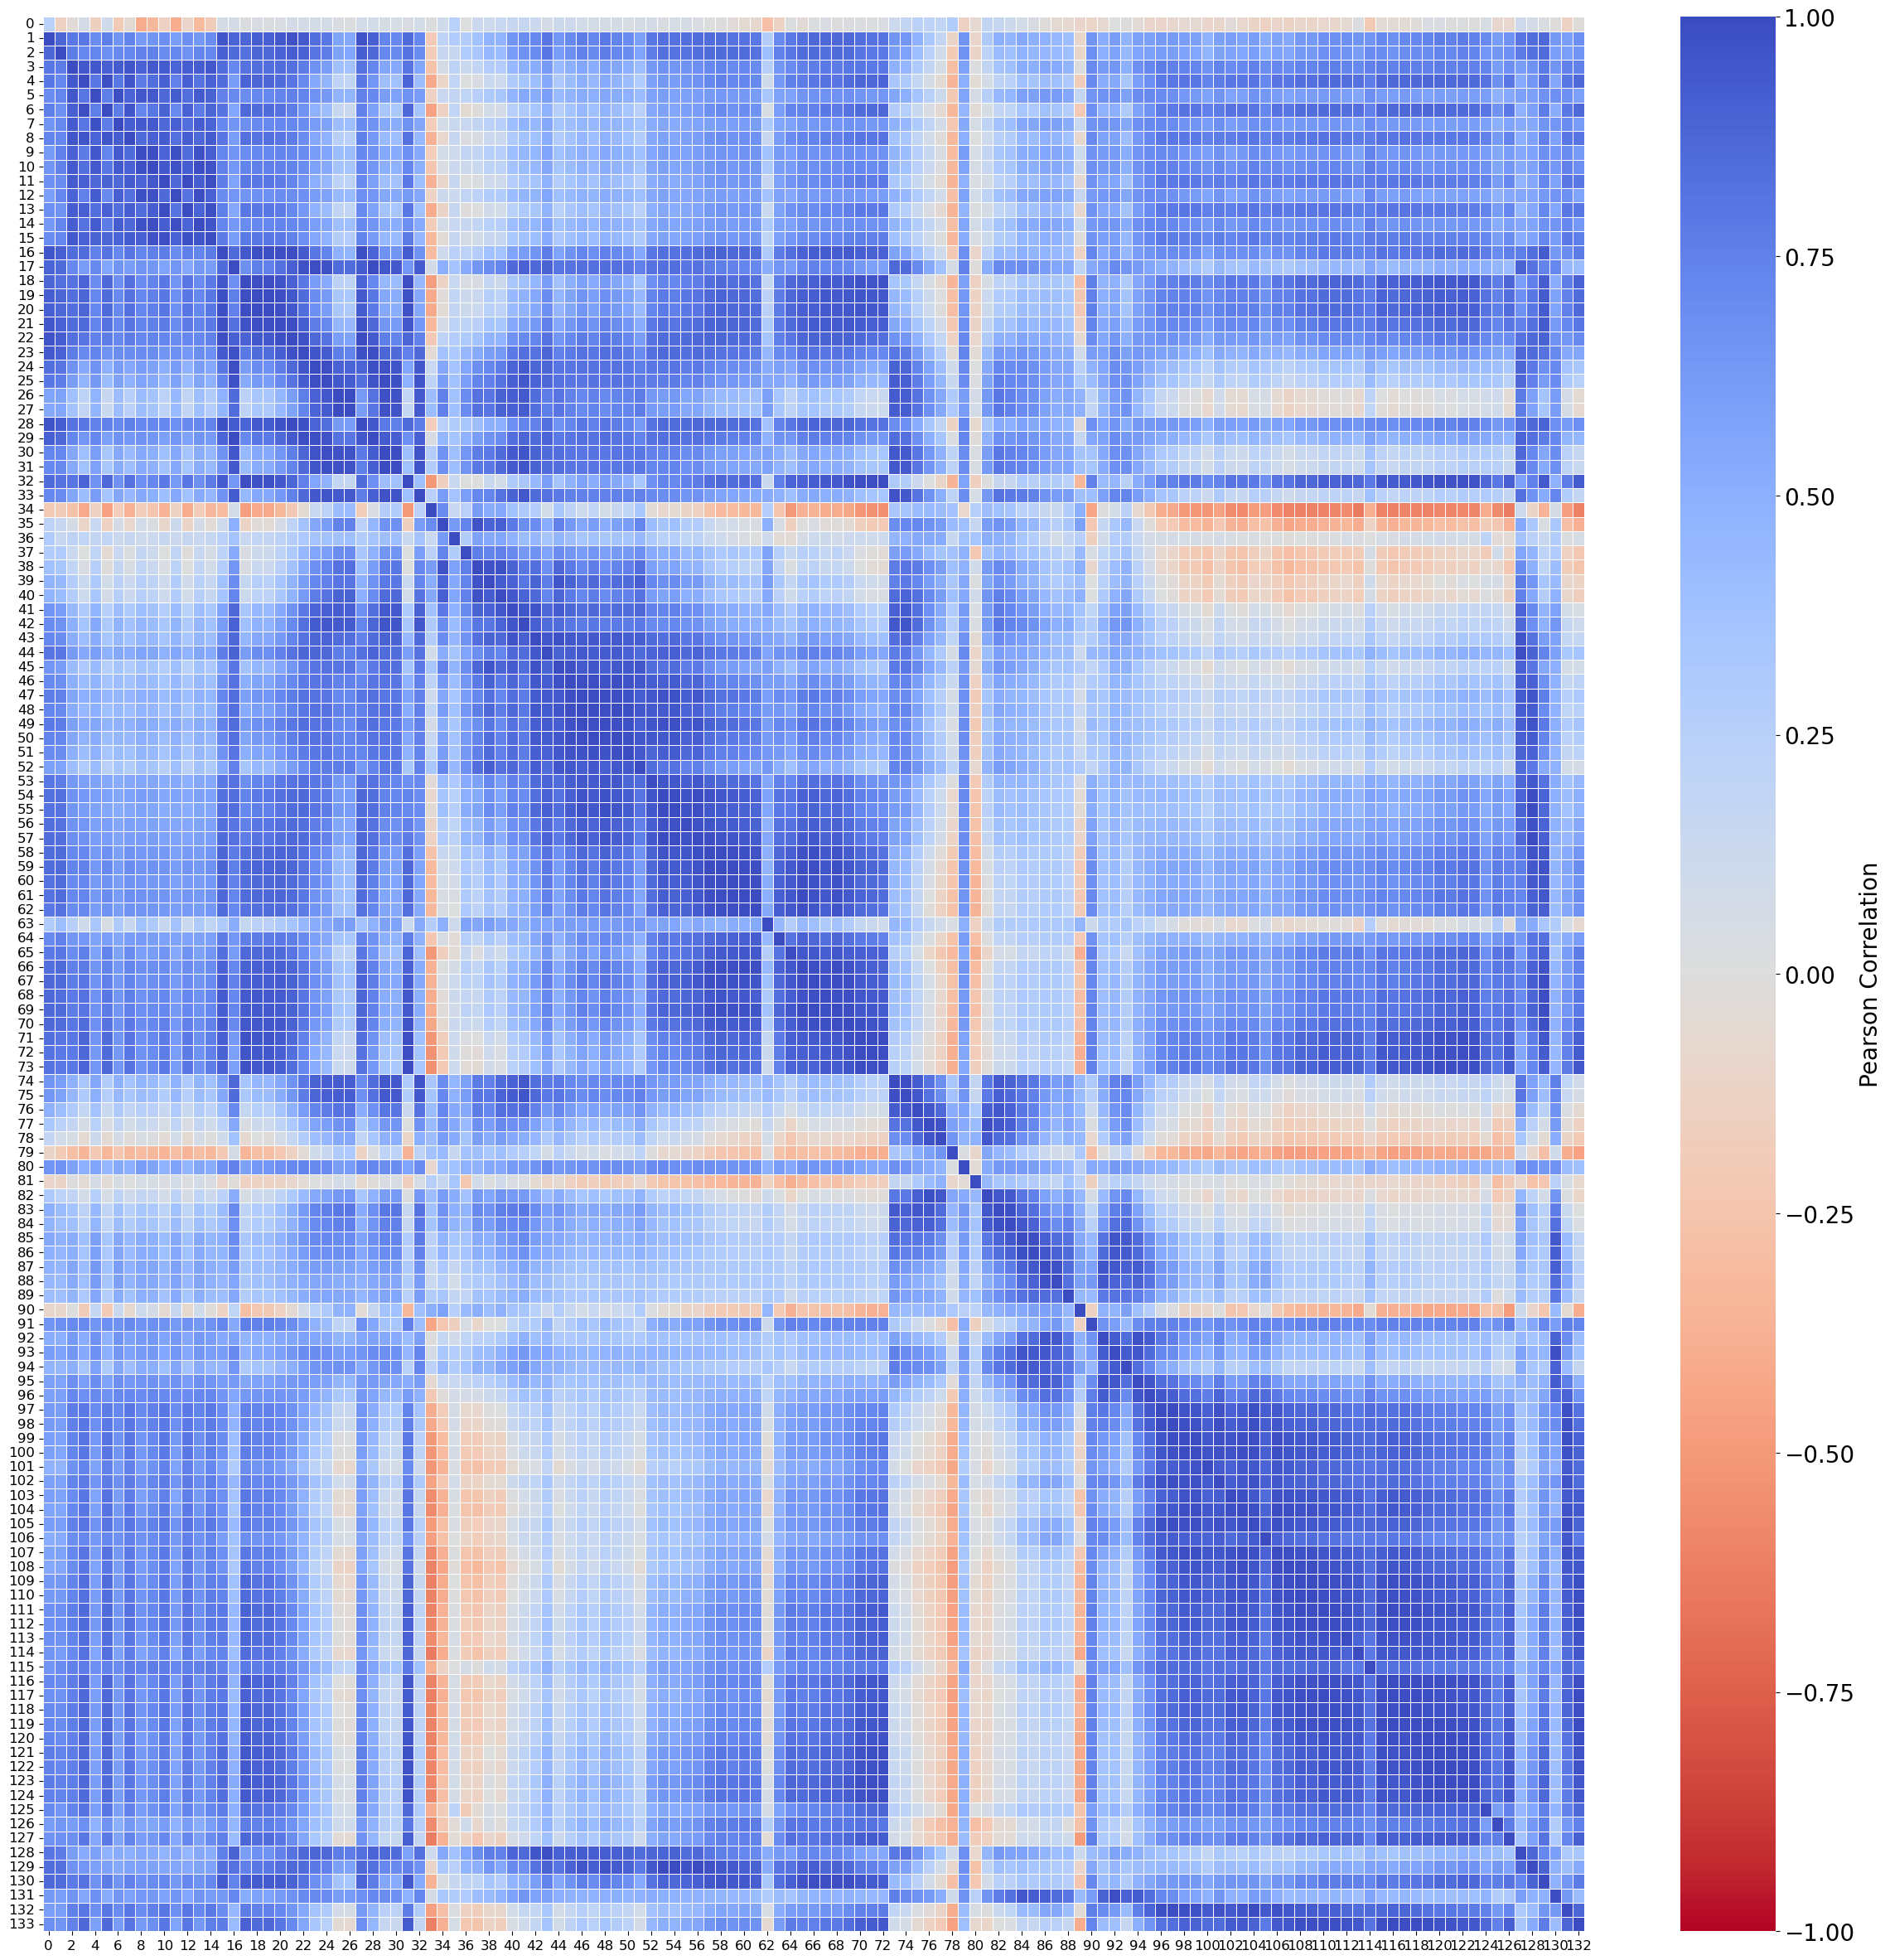

In [24]:
# sns.heatmap(R_matrix, ax = ax, linewidth=0.5, annot=False)
fontsize = 12
fig, ax = plt.subplots(figsize=(30,30))
sns.color_palette("coolwarm_r", as_cmap=True)
sns.heatmap(R_matrix, ax = ax, annot=False, linewidth=0.5,
            cmap = sns.color_palette("coolwarm_r", as_cmap=True), vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = fontsize)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = fontsize)
ax.figure.axes[-1].set_ylabel('Pearson Correlation', size=20)
ax.figure.axes[-1].tick_params(labelsize=20)
plt.show()

### tICA

Time-lagged intedependent Component Analysis (tICA) is a method ) which can be used to separate and extract the internal coordinates which exhibit the strongest time-correlations for a chosen lag time, thus revealing slower movements in the system.

Molgedey, L.; Schuster, H. G. Separation of a Mixture of Independent Signals Using Time Delayed Correlations. Phys. Rev. Lett. 1994, 72 (23), 3634–3637. https://doi.org/10.1103/PhysRevLett.72.3634.

In [25]:
tca = tica(norm_internal, lag=10, dim=4)
tc = tca.get_output()
tica_concatenated = np.concatenate(tc)
X_t = tc[0]
Loading_labels.append('TICA')
Loading_data.append(np.mean(np.abs(tca.feature_TIC_correlation), axis=1))

[0. 0.]
Ellipse: ctr:(0, 0) , width:1.9745937605464512, height:2.0250875242346993, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:1.868419764131276, height:2.1234423903189903, angle:0
[0. 0.]
Ellipse: ctr:(0, 0) , width:2.541020988690224, height:1.2422609770236512, angle:0


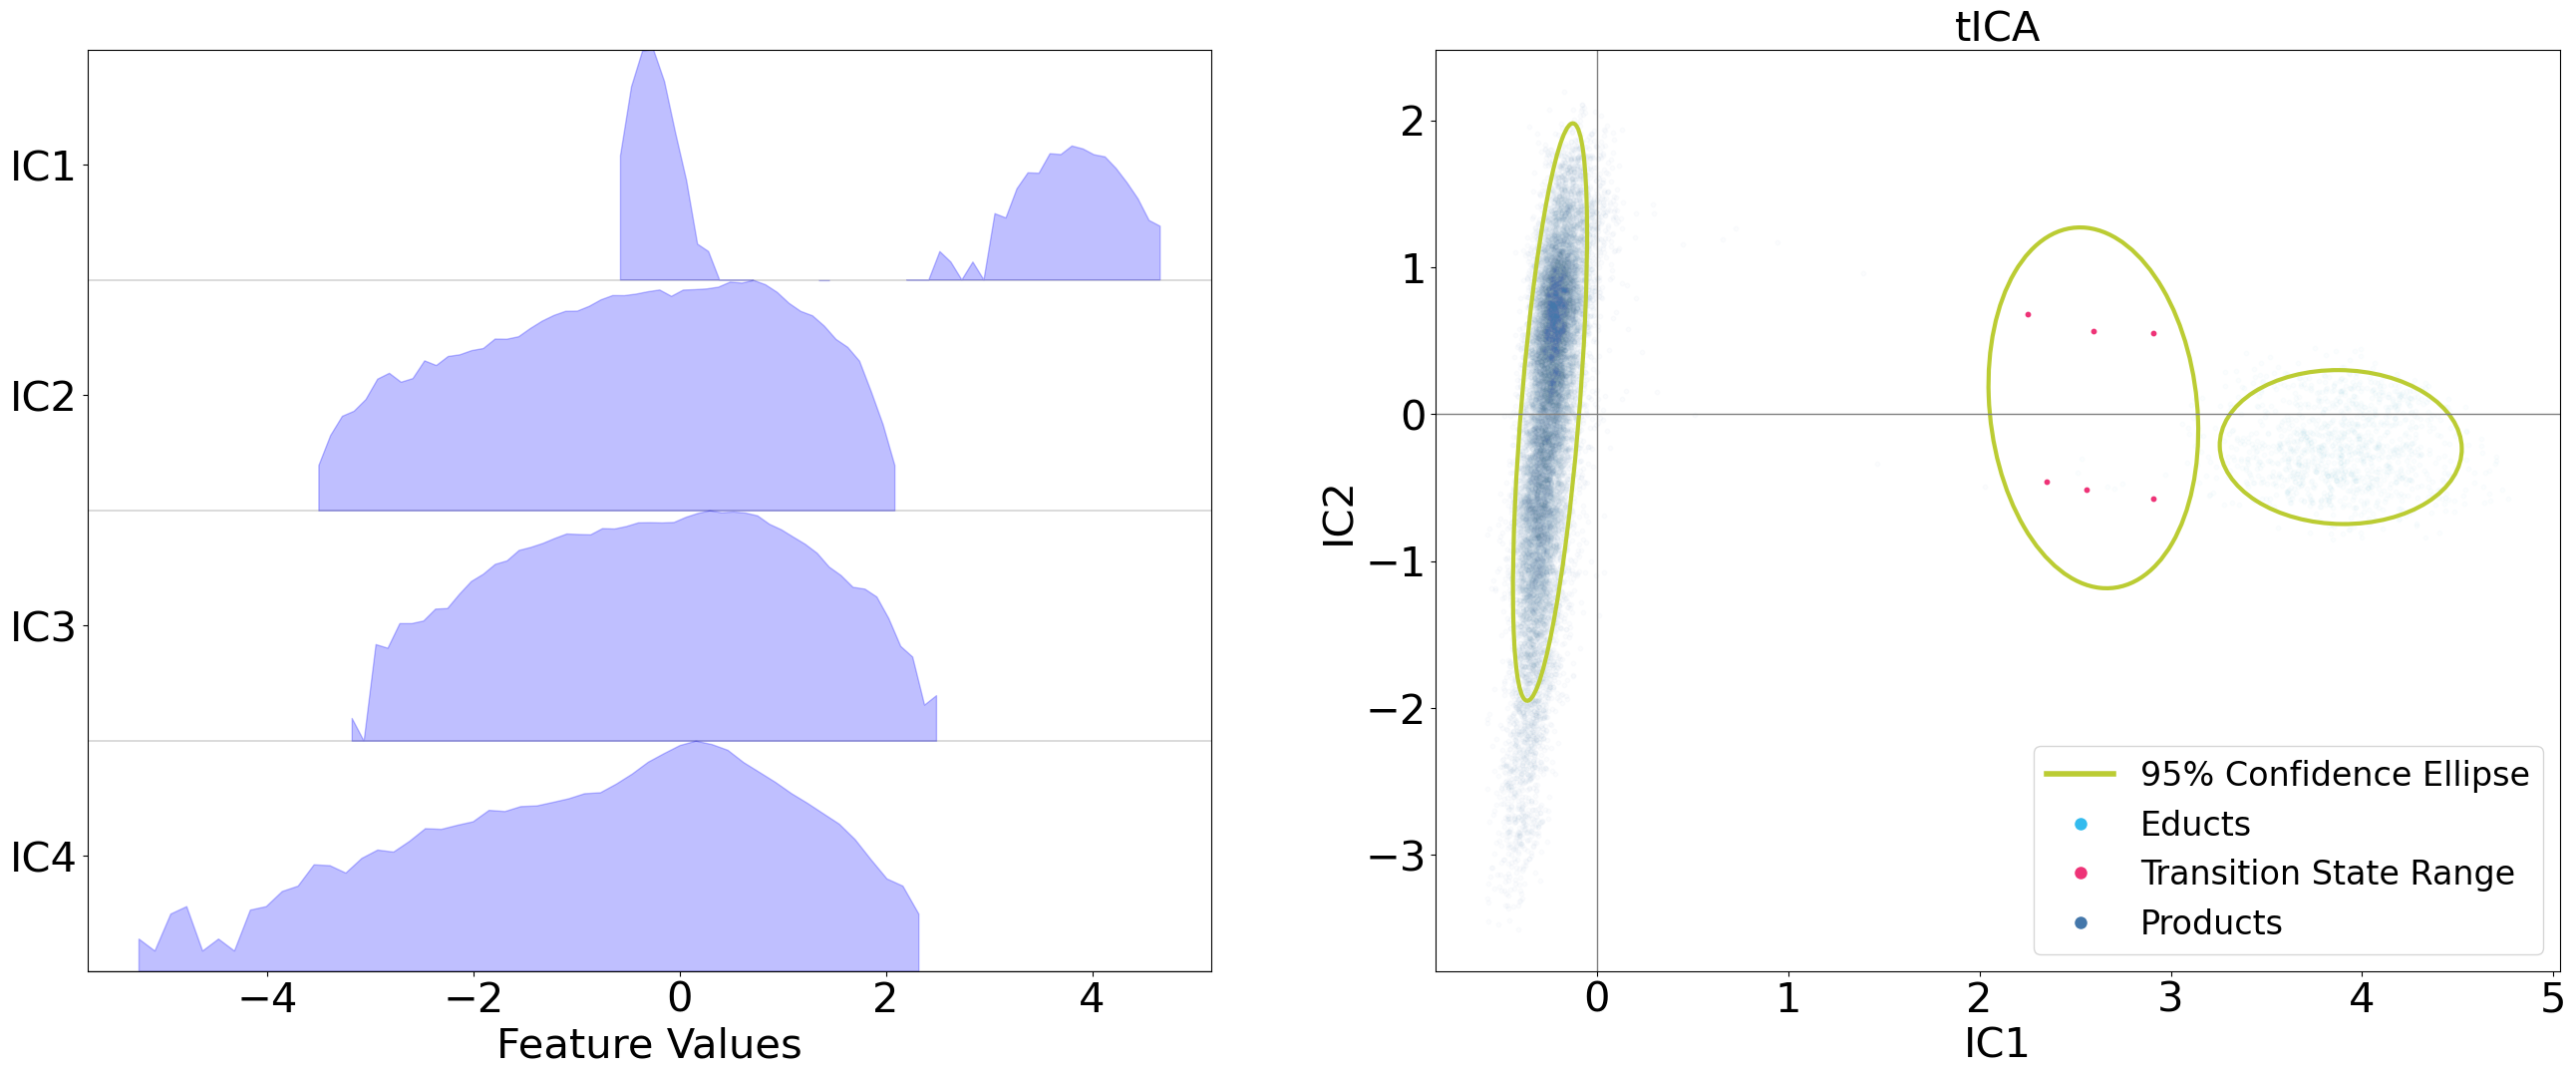

In [26]:
fontsize = 30
# fig, ax = plt.subplots(1, 1, figsize = (16,12))
fig, axes = plt.subplots(1, 2, figsize=(32, 12))
ax = axes[-1]
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
# ax.scatter(X_t[:,0], X_t[:,1], s=5)
custom_lines = [Line2D([0], [0], color='#BBCC33', lw=4, label='95% Confidence Ellipse'),
                # Line2D([0], [0], color='black', lw=4, label='IC Loadings'),
                Line2D([0], [0], marker='o', color='w', label='Educts', markerfacecolor='#33BBEE', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Transition State Range', markerfacecolor='#EE3377', markersize=10),
                Line2D([0], [0], marker='o', color='w', label='Products', markerfacecolor='#4477AA', markersize=10)]

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

# confidence_ellipse(X_t[:,0][np.argwhere(class_labels==int(0))].flatten(), X_t[:,1][np.argwhere(class_labels==int(0))].flatten(), ax, edgecolor='red', lw = 15,n_std = 3)

elli = myplotAX(ax,X_t[:,0:2], tca.feature_TIC_correlation, colors=['#33BBEE','#EE3377','#4477AA'], labels = heatmap_labels, scale_coeff=1, coeff_limit=0.9, lw = 3, n_std = 2, loadings = None) 
ax.set_title('tICA', fontsize = fontsize)
ax.set_xlabel('IC1', fontsize = fontsize)
ax.set_ylabel('IC2', fontsize = fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
axes[0].set_xlabel('Feature Values', fontsize = fontsize)
ax.legend(handles = custom_lines, fontsize = fontsize*0.8)
plt.show()

[0, 14]
[15, 29]
[30, 44]


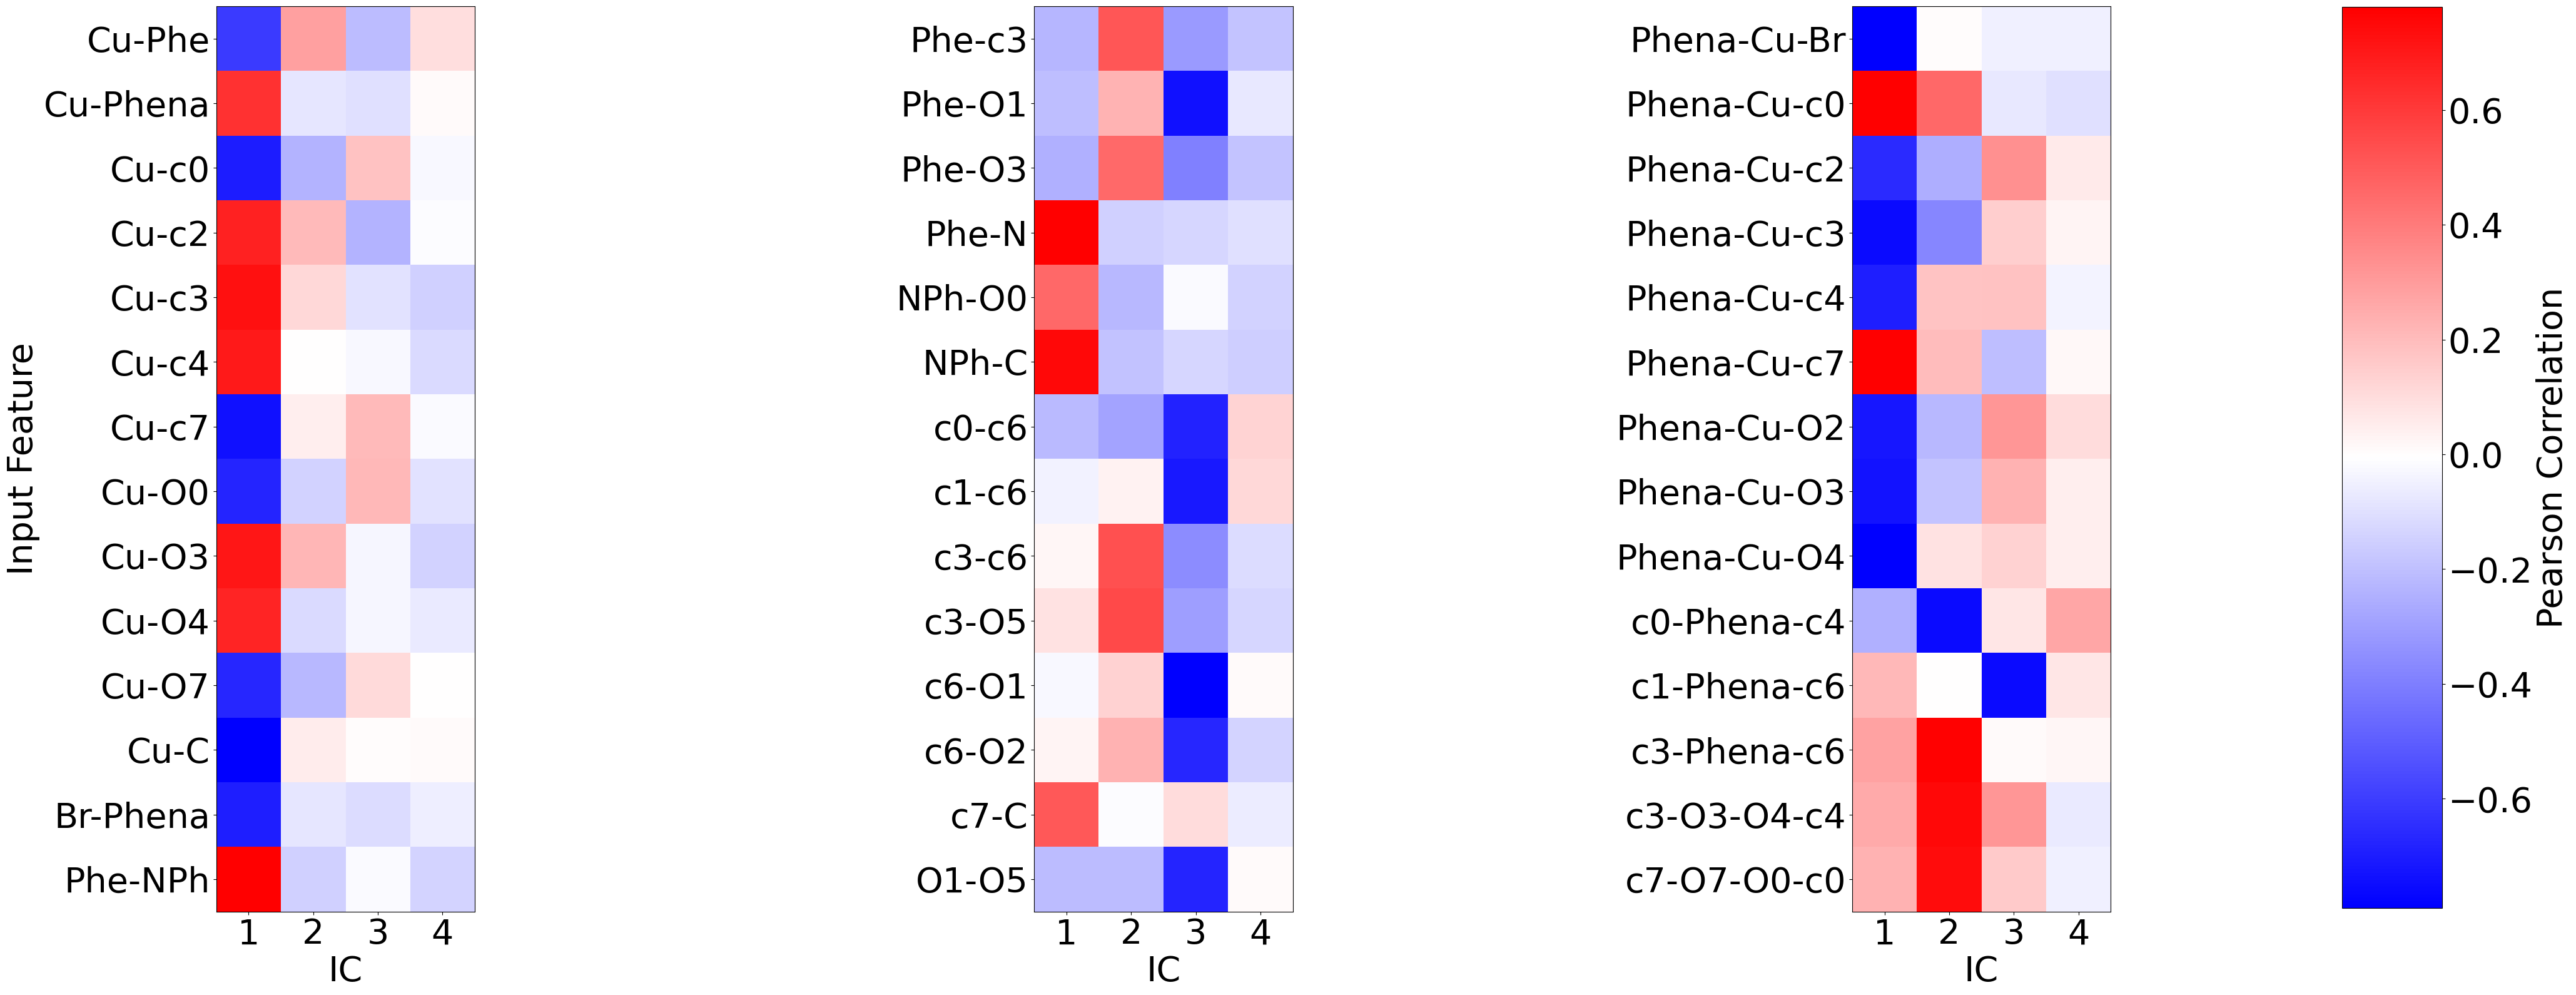

In [27]:
fontsize = 40
fig, ax = plt.subplots(1,3,figsize=(40,16))
imgs = []
for ix in range(3):
    print([15*ix,15*ix+15-1])
    imgs.append(ax[ix].imshow(tca.feature_TIC_correlation[np.argwhere(np.abs(tca.feature_TIC_correlation)>0.6)[:,0]][15*ix:15*ix+15-1], cmap='bwr'))

    ax[ix].set_xticks(range(tca.dimension()))
    ax[ix].set_xlabel('IC', fontsize = fontsize)
    ax[ix].set_xticklabels(range(1,tca.dimension()+1))

    ax[ix].set_yticks(np.linspace(0,np.array(heatmap_labels)[np.argwhere(np.abs(tca.feature_TIC_correlation)>0.6)[:,0]][15*ix:15*ix+15-1].size-1,np.array(heatmap_labels)[np.argwhere(np.abs(tca.feature_TIC_correlation)>0.6)[:,0]][15*ix:15*ix+15-1].size))
    ax[ix].set_yticklabels(np.array(heatmap_labels)[np.argwhere(np.abs(tca.feature_TIC_correlation)>0.6)[:,0]][15*ix:15*ix+15-1])

    for item in ([ax[ix].title, ax[ix].xaxis.label, ax[ix].yaxis.label] +
             ax[ix].get_xticklabels() + ax[ix].get_yticklabels()):
        item.set_fontsize(40)

ax[0].set_ylabel('Input Feature', fontsize = fontsize)
cb_ax = fig.add_axes([1.0,0.09,.04,0.9])
fig.colorbar(imgs[0],orientation='vertical',cax=cb_ax, label = 'Pearson Correlation')
for item in ([cb_ax.title, cb_ax.xaxis.label, cb_ax.yaxis.label] +
             cb_ax.get_xticklabels() + cb_ax.get_yticklabels()):
        item.set_fontsize(40)

fig.subplots_adjust(wspace=0.915, hspace=0.34, right=0.8)
fig.tight_layout()

# Recursive Feature Elimination with cross validation (RFECV)

RFECV is a technique used to automatically reduce the number of internal coordinates, which are either highly correlated or insignificant in distinguishing between educts, products and transition states.

### RFECV with LogisticRegression

Note: As this notebook is to be used as an example and the example dataset is limited, we artificially limit the dataset via random sampling to increase the discrepancies between the two trajectories

In [28]:
min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecvX = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecvX.fit(reduced_data, reduced_labels)

print(f"Optimal number of features: {rfecvX.n_features_}")

Optimal number of features: 20


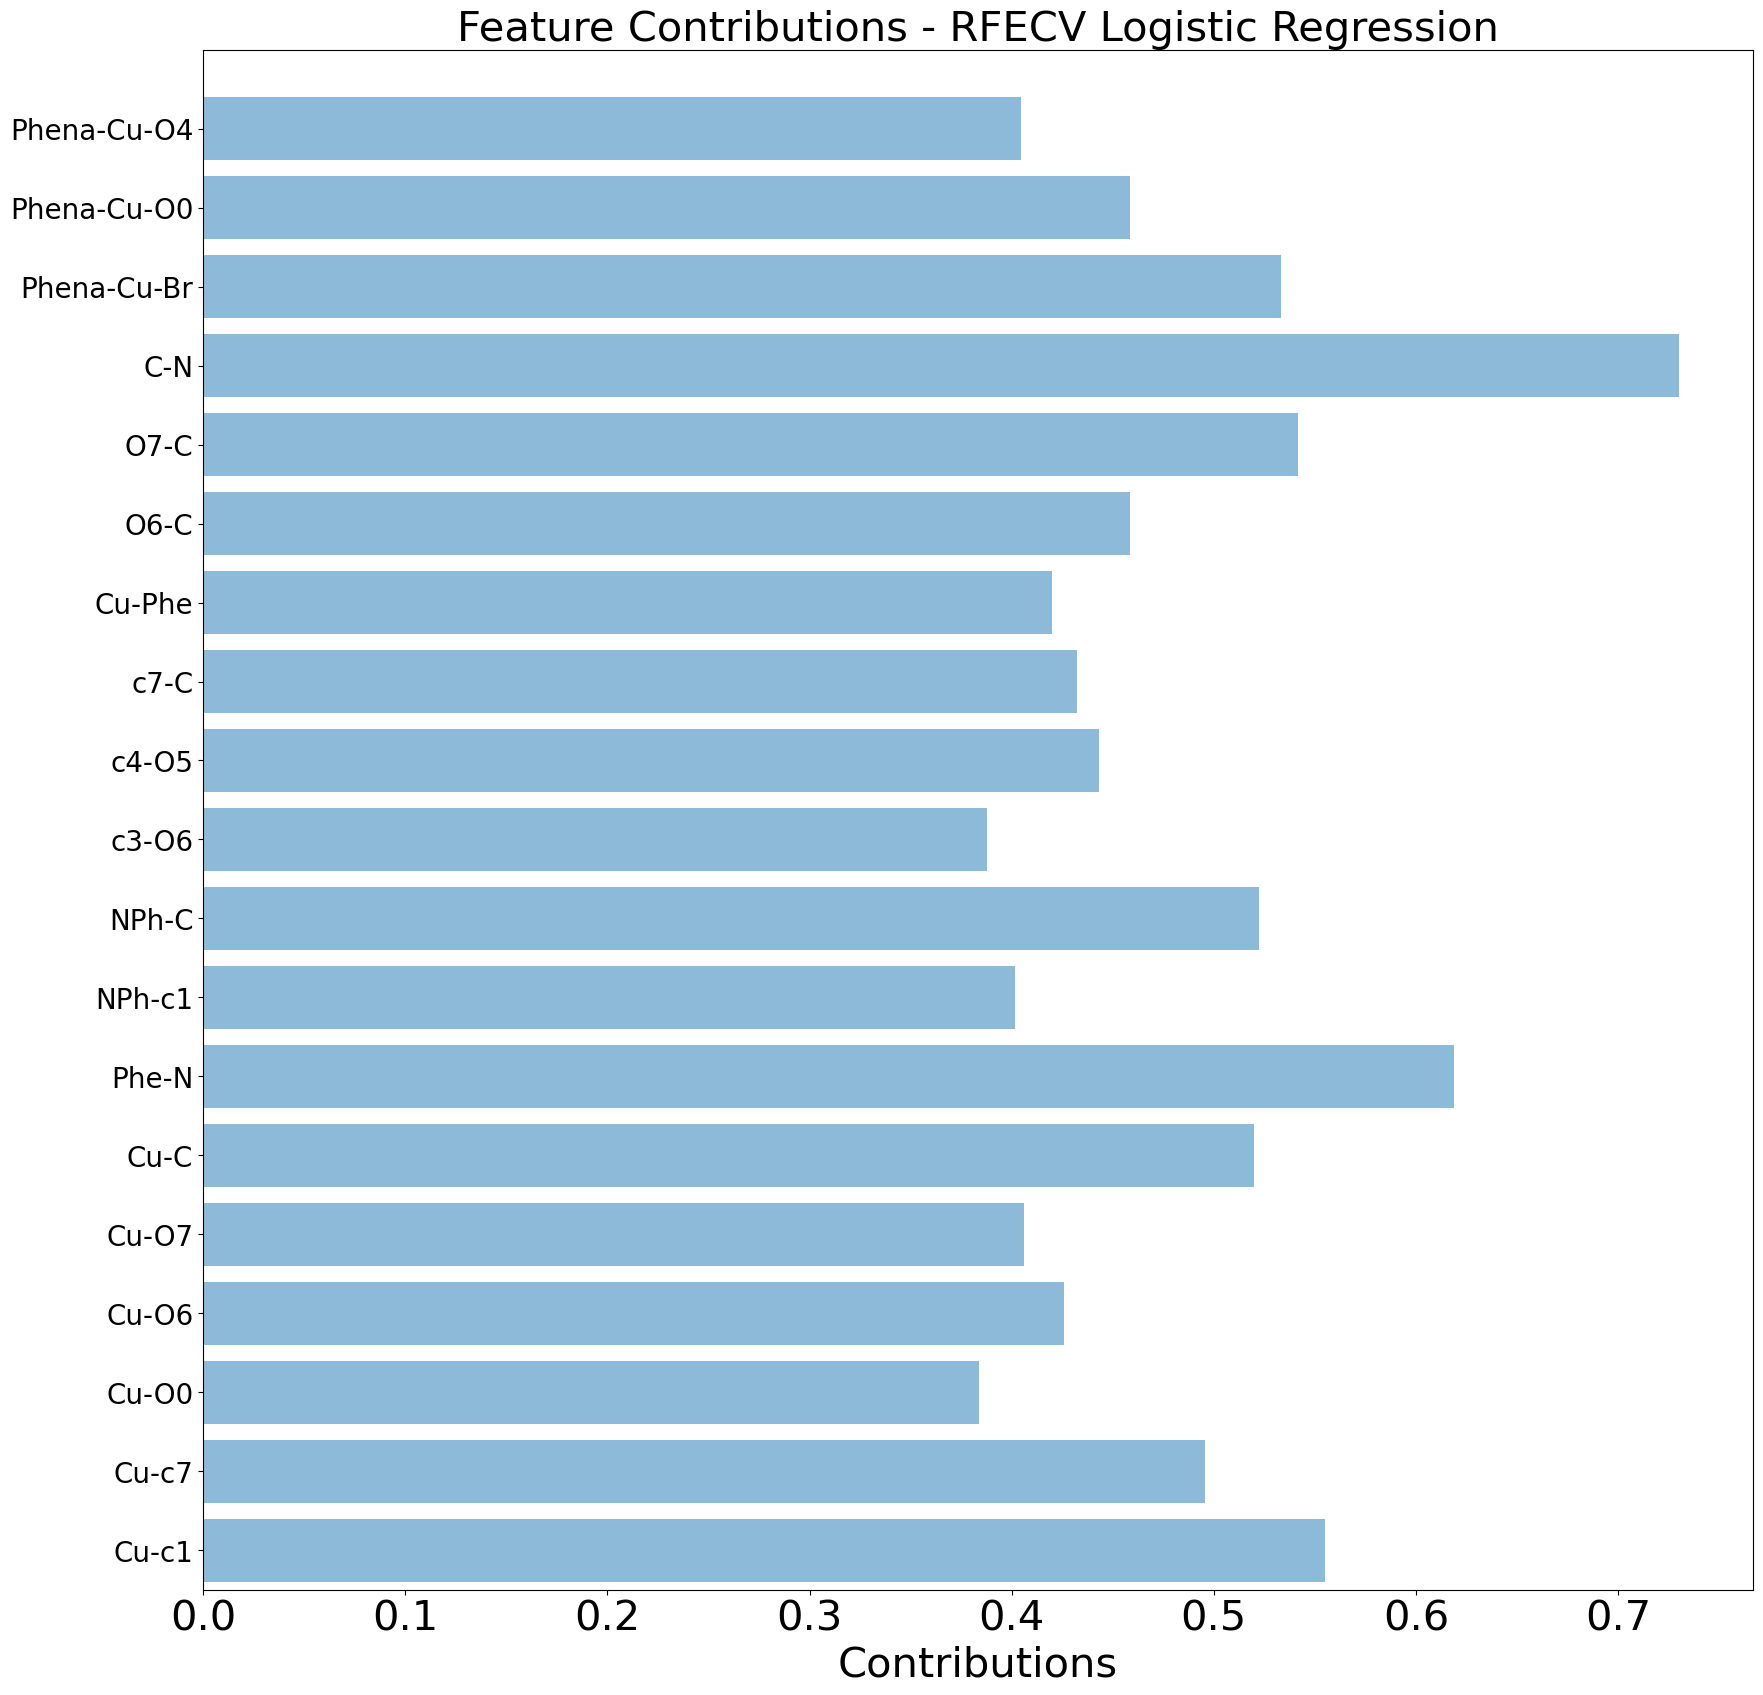

In [29]:
feat=deepcopy(heatmap_labels)
x_imp = [x for i,x in enumerate(heatmap_labels) if i in rfecvX.get_support(indices=True)]

objects = np.array([x for i,x in enumerate(heatmap_labels) if i in rfecvX.get_support(indices=True)])
y_pos = np.arange(objects.size)
performance = np.abs(rfecvX.estimator_.coef_).mean(axis=0)
p_10, l_10, indices = get_top_perc(performance, np.array(objects),100)
y_pos = np.arange(l_10.size)
fig, ax = plt.subplots(figsize=(20, 20))
plt.barh(y_pos, p_10, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, l_10,fontsize=30)
plt.ylim(0.5,l_10.size)
plt.xticks(fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Contributions', fontsize=30)
plt.title('Feature Contributions - RFECV Logistic Regression',fontsize=30)
plt.show()

In [30]:
indices = rfecvX.get_support(indices=True) # Use this indices to filter the features for PCA and LDA

# RFECV with random forest

In [32]:
rfc = RandomForestClassifier(random_state=30, n_estimators=30)
rfecv_rfc = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=12)
rfecv_rfc.fit(reduced_data, reduced_labels)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_estimators=30, random_state=30),
      n_jobs=12, scoring='accuracy')

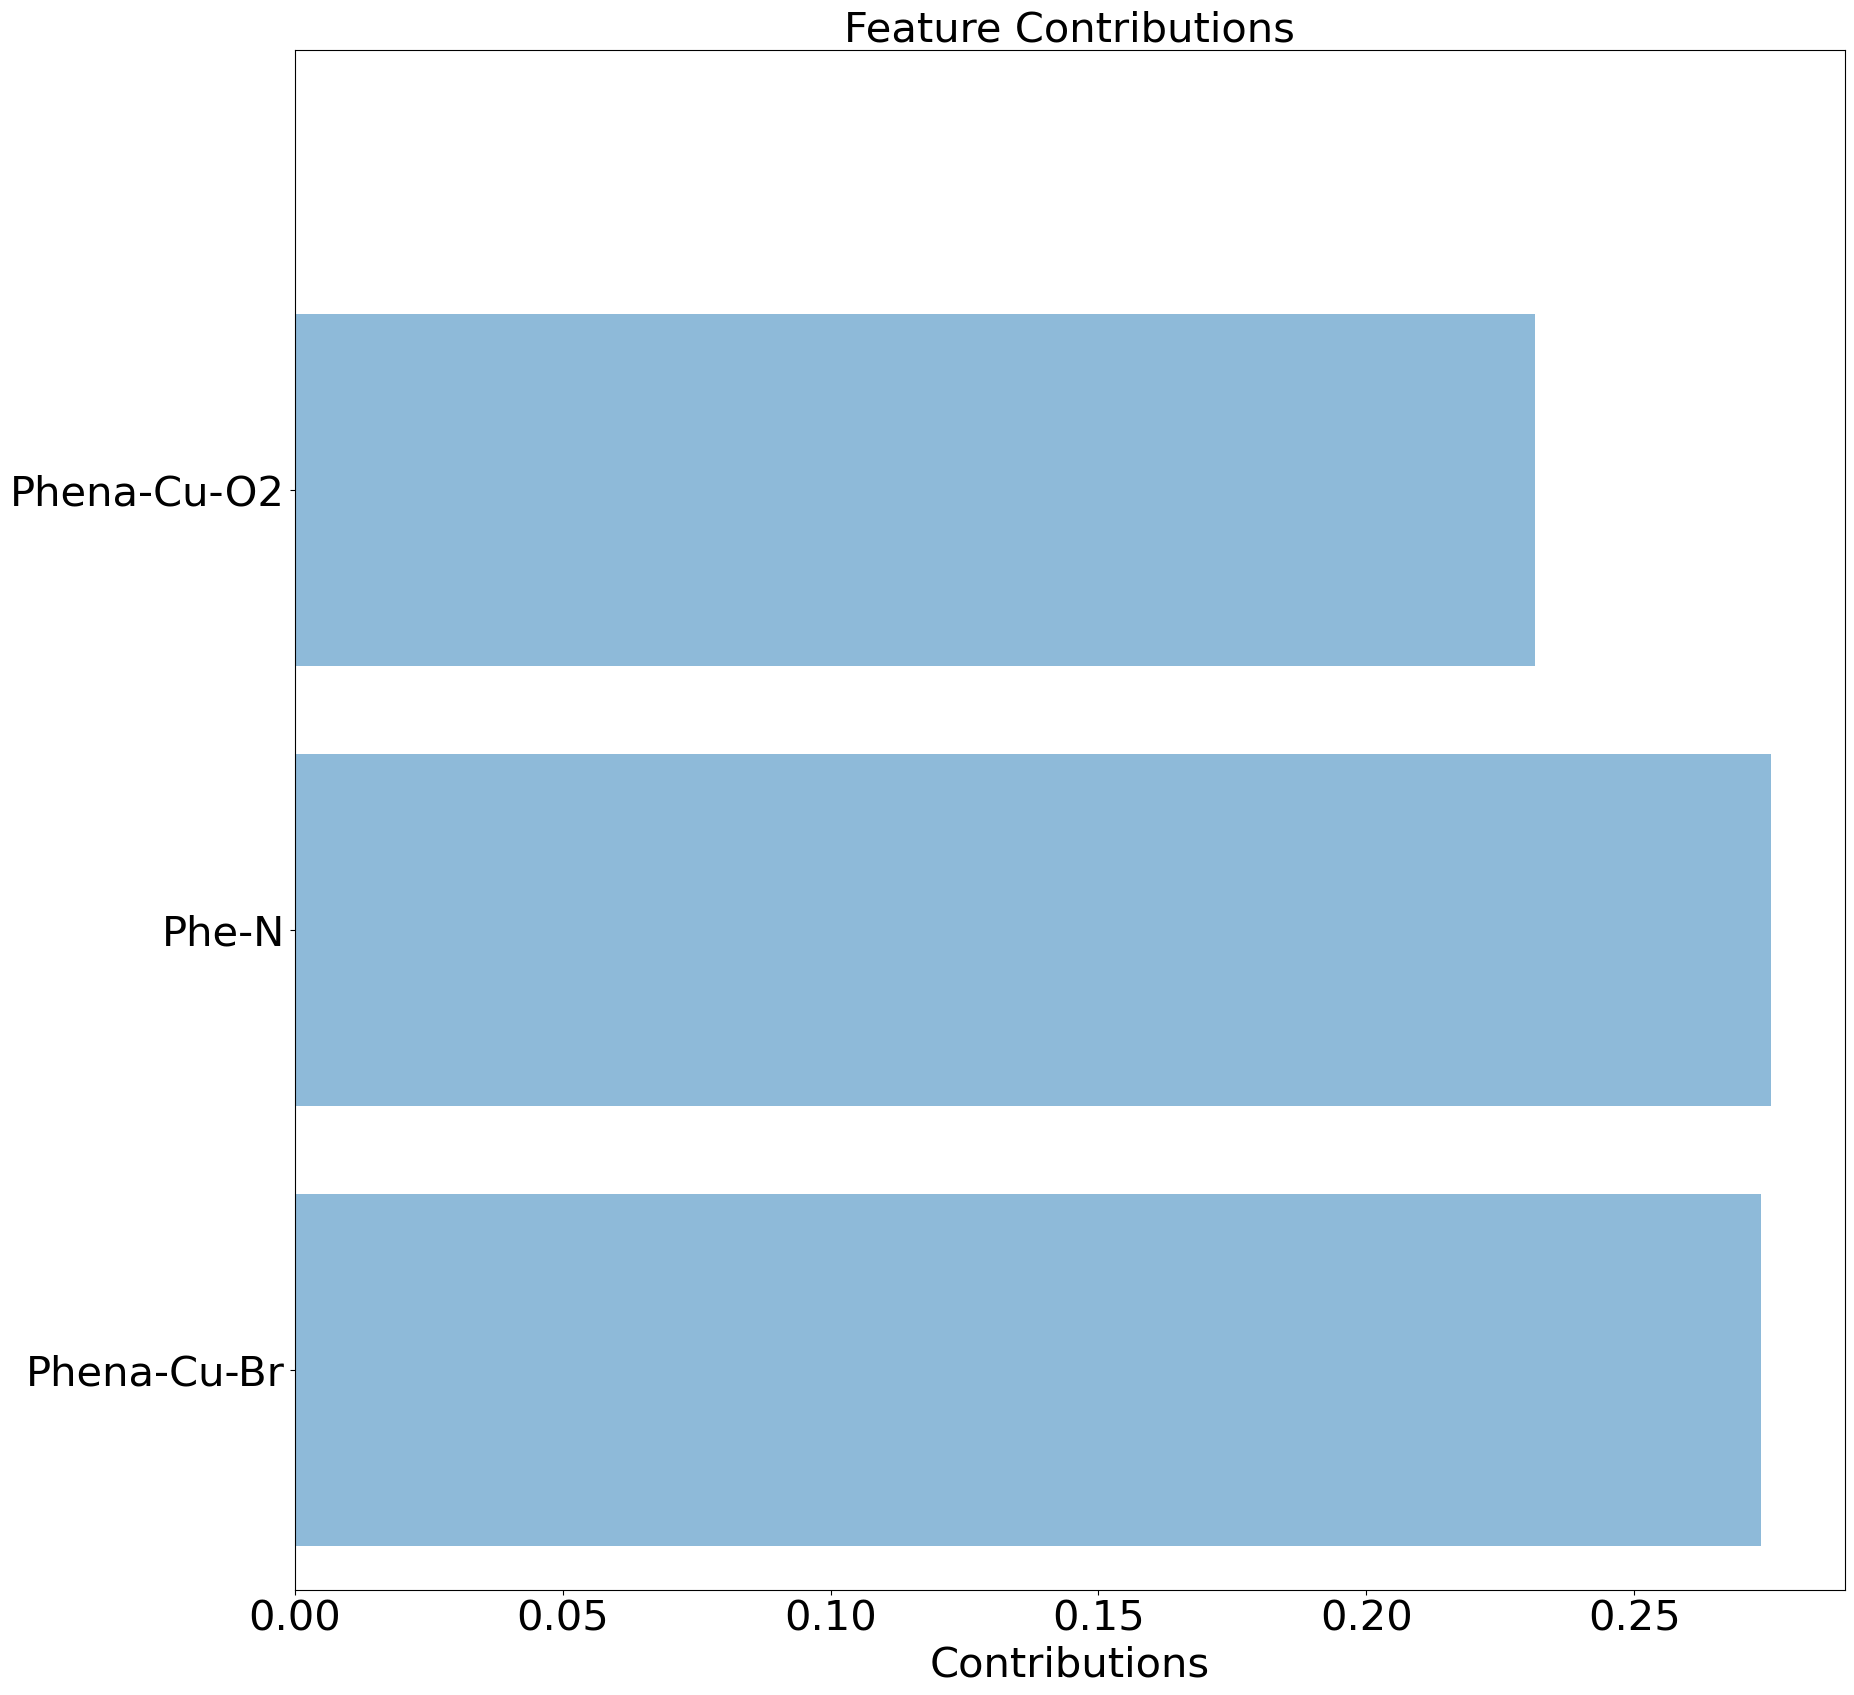

In [33]:
features=rfecv_rfc.n_features_
n_p=np.where(rfecv_rfc.support_ == False)[0]
feat=deepcopy(heatmap_labels)
x_imp = [x for i,x in enumerate(heatmap_labels) if i not in n_p]
objects = np.array([x for i,x in enumerate(heatmap_labels) if i not in n_p])
y_pos = np.arange(np.array([x for i,x in enumerate(heatmap_labels) if i not in n_p]).size)
performance = rfecv_rfc.estimator_.feature_importances_
p_10, l_10, indices = get_top_perc(performance, objects, perc = 100)
y_pos = np.arange(l_10.size)
fig, ax = plt.subplots(figsize=(20, 20))
plt.barh(y_pos, p_10, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, l_10,fontsize=30)
plt.ylim(0.5,l_10.size)
plt.xticks(fontsize=30)
plt.xlabel('Contributions',fontsize=30)
plt.title('Feature Contributions',fontsize=30)
plt.show()

In [34]:
indices = rfecv_rfc.get_support(indices=True) # Eliminate features with low importance

# Manual cutoff for low importance features

# Random forest clasifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfcX = RandomForestClassifier(n_estimators=30)
X_n=reduced_data
Y_n=reduced_labels
rfcX.fit(X_n,Y_n)




RandomForestClassifier(n_estimators=30)

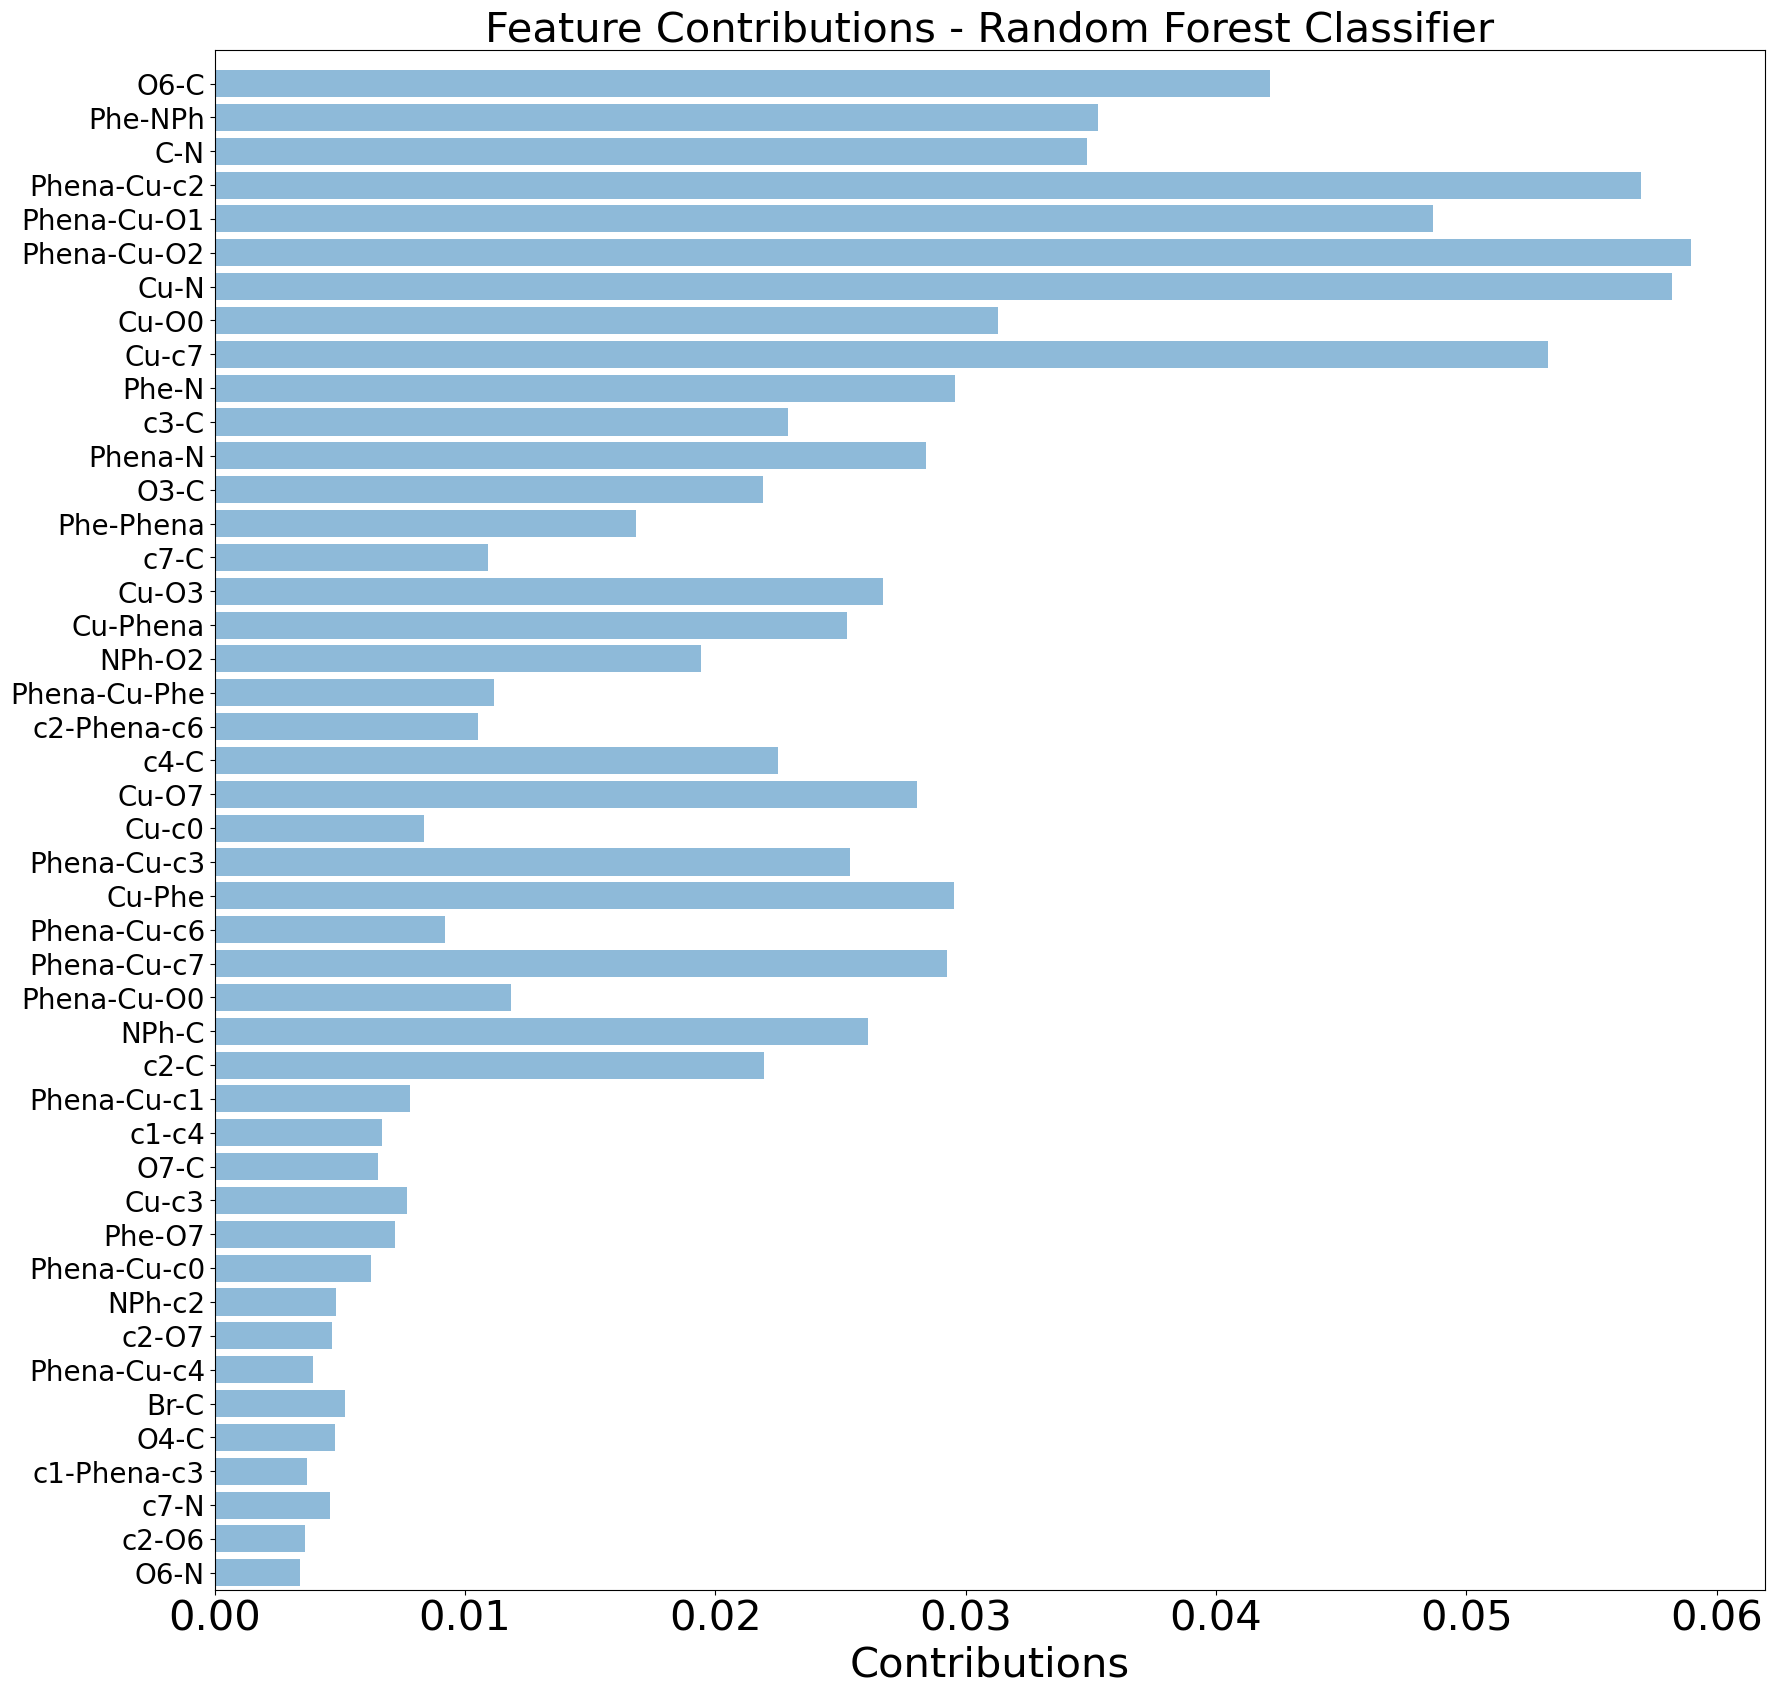

In [36]:
importance = rfcX.feature_importances_
objects = heatmap_labels
y_pos = np.arange(len(objects))
performance = importance
p_10, l_10, indices = get_top_perc(performance, np.array(objects), perc = 15)
y_pos = np.arange(l_10.size)
fig, ax = plt.subplots(figsize=(20, 20))
plt.barh(y_pos, p_10, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, l_10,fontsize=30)
plt.ylim(0.5,l_10.size)
plt.xticks(fontsize=30)
plt.yticks(fontsize=20)
plt.xlabel('Contributions', fontsize=30)
plt.title('Feature Contributions - Random Forest Classifier',fontsize=30)
plt.show()

In [37]:
indices = np.where(importance > 0.0005)[0] # Eliminate features with low importance

# Logistic regression

In [38]:

model_logreg = LogisticRegression(solver='liblinear', random_state=0)
model_logreg.fit(X_n, Y_n)


LogisticRegression(random_state=0, solver='liblinear')

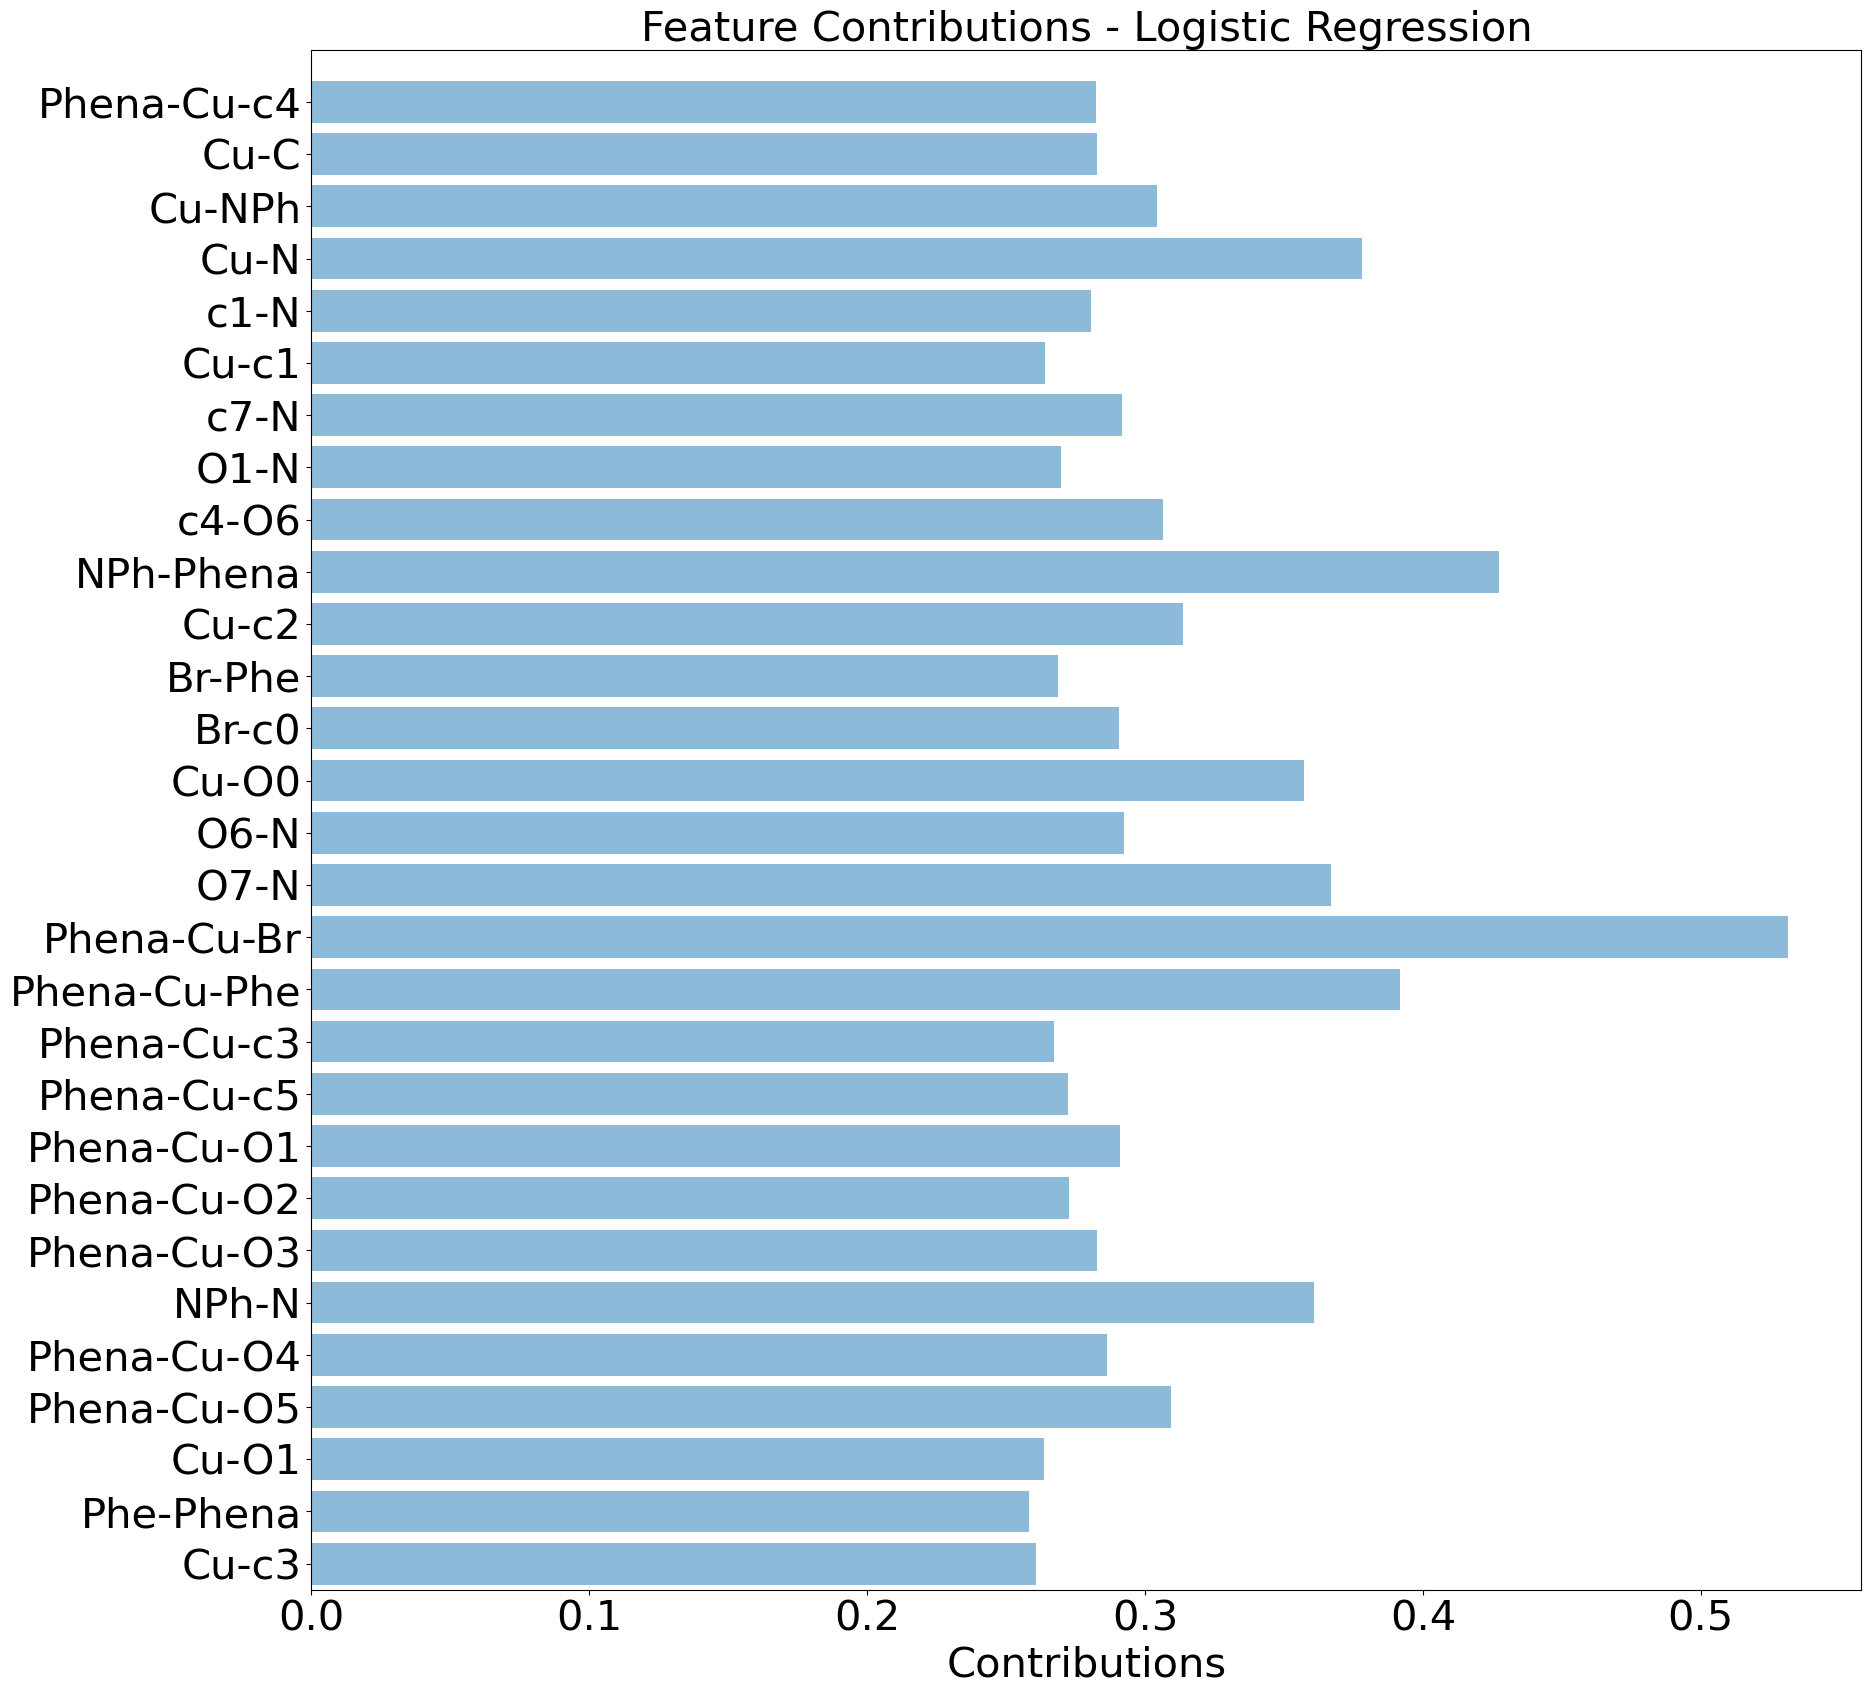

In [39]:
Weights=np.hstack((model_logreg.intercept_[:,None], model_logreg.coef_))
Weights_avg = np.mean(np.abs(Weights), axis=0)
Weights_avg.shape
k=deepcopy(heatmap_labels)
k.append('bias')
objects = k
y_pos = np.arange(len(k))
performance = importance
p_10, l_10, indices = get_top_perc(Weights_avg, np.array(objects))
y_pos = np.arange(l_10.size)
fig, ax = plt.subplots(figsize=(20, 20))
plt.barh(y_pos, p_10, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, l_10,fontsize=30)
plt.ylim(0.5,l_10.size)
plt.xticks(fontsize=30)
plt.xlabel('Contributions',fontsize=30)
plt.title('Feature Contributions - Logistic Regression',fontsize=30)
plt.show()

In [40]:
indices = np.where(Weights_avg[1:]>0.5)[0]-1 # Eliminate features with low importance

# Lasso Model

Least Absolute Shrinkage and Selection Operator (Lasso) regression is a regularization technique, for a more accurate prediction. This model uses shrinkage, where data values are shrunk towards a central point, generally the mean.

Tibshirani, R. Regression Shrinkage and Selection Via the Lasso. Journal of the Royal Statistical Society: Series B (Methodological) 1996, 58 (1), 267–288. https://doi.org/10.1111/j.2517-6161.1996.tb02080.x.

In [41]:
df = pd.DataFrame(norm_internal, columns = np.array(heatmap_labels), dtype = np.float32)

categorical_columns = heatmap_labels

alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen by cross-validation
modelLasso = make_pipeline(
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100000,n_jobs=6)),
)

_ = modelLasso.fit(df, class_labels)

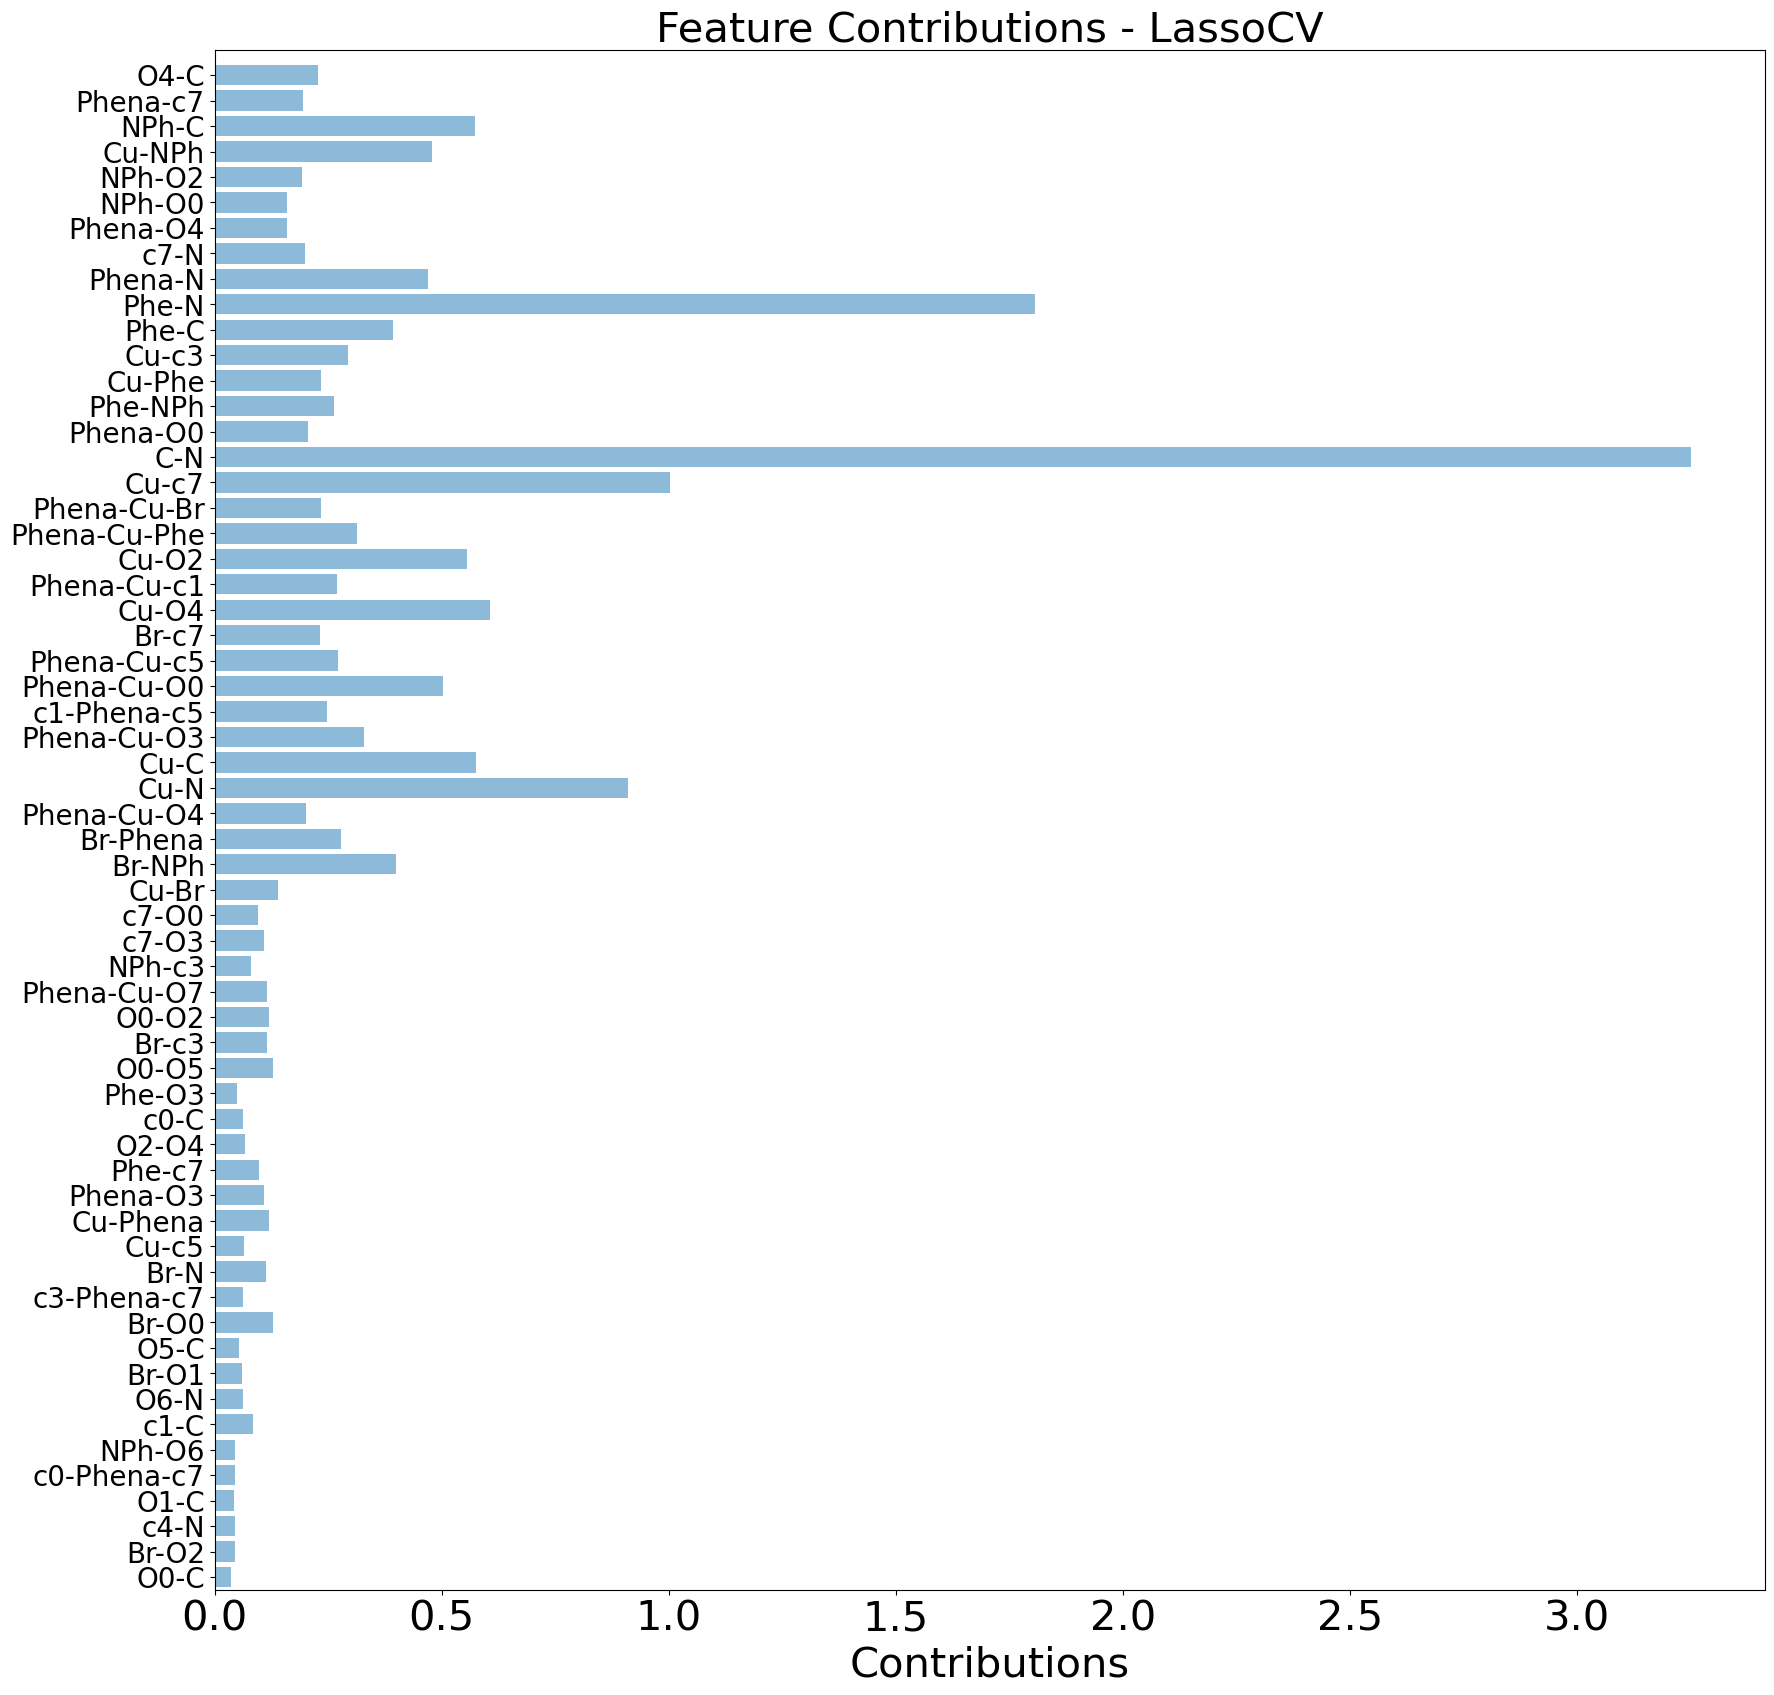

In [42]:
feature_names =  heatmap_labels
coefs = pd.DataFrame(
    np.abs(modelLasso[-1].regressor_.coef_),
    columns=["Coefficients importance"],
    index=feature_names,
)
objects = np.array(heatmap_labels)
performance = modelLasso[-1].regressor_.coef_
p_10, l_10, indices = get_top_perc(np.abs(performance), objects, perc = 20)
y_pos = np.arange(l_10.size)
fig, ax = plt.subplots(figsize=(20, 20))
plt.barh(y_pos, p_10, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, l_10,fontsize=20)
plt.ylim(0.5,l_10.size)
plt.xticks(fontsize=30)
plt.xlabel('Contributions',fontsize=30)
plt.title('Feature Contributions - LassoCV',fontsize=30)
plt.show()

In [43]:
indices = np.where(np.abs(performance) > 0.1)[0]

## Loadings of Dimensionality Reduction

By examining the loadings of the dimensionality reduction, one can determine which features contribute to the separation of the structural ensembles.

For the LDA, the two principal components are averaged, while for the PCA, the mean of the first three principal components is considered. This is due to the variance in the PCA levelling off after the first 3 components, while the LDA can provide a maximum of n_classes - 1 components.

In [44]:
crdtx = np.array(Loading_data).T/np.max(np.array(Loading_data), axis=1).T
colnames = []
for i in range(np.array(Loading_labels).shape[0]):
    colnames.append(Loading_labels[i] + ' ' + str(i))
df_loadings = pd.DataFrame(crdtx, columns = colnames)

In [45]:
df_loadings

LDA_all_internal 0  PCA_all_internal 1    TICA 2
0              0.022871            0.081474  0.106153
1              0.380346            0.874678  0.891924
2              0.195955            0.354622  0.323624
3              0.351624            0.501481  0.601163
4              0.099050            0.672131  0.849335
..                  ...                 ...       ...
303            0.012447            0.622766  0.856430
304            0.060861            0.247401  0.501624
305            0.000445            0.803317  0.354284
306            0.020179            0.091466  0.429238
307            0.012552            0.605972  0.716520

[308 rows x 3 columns]

In [46]:
# Drop the columns containing either "LDA" or "TICA"
cols_to_drop = df_loadings.columns[df_loadings.columns.str.contains('LDA|TICA')]
df_PCA = df_loadings.drop(cols_to_drop, axis=1)

# Drop the columns containing either "PCA" or "TICA"
cols_to_drop = df_loadings.columns[df_loadings.columns.str.contains('PCA|TICA')]
df_LDA = df_loadings.drop(cols_to_drop, axis=1)


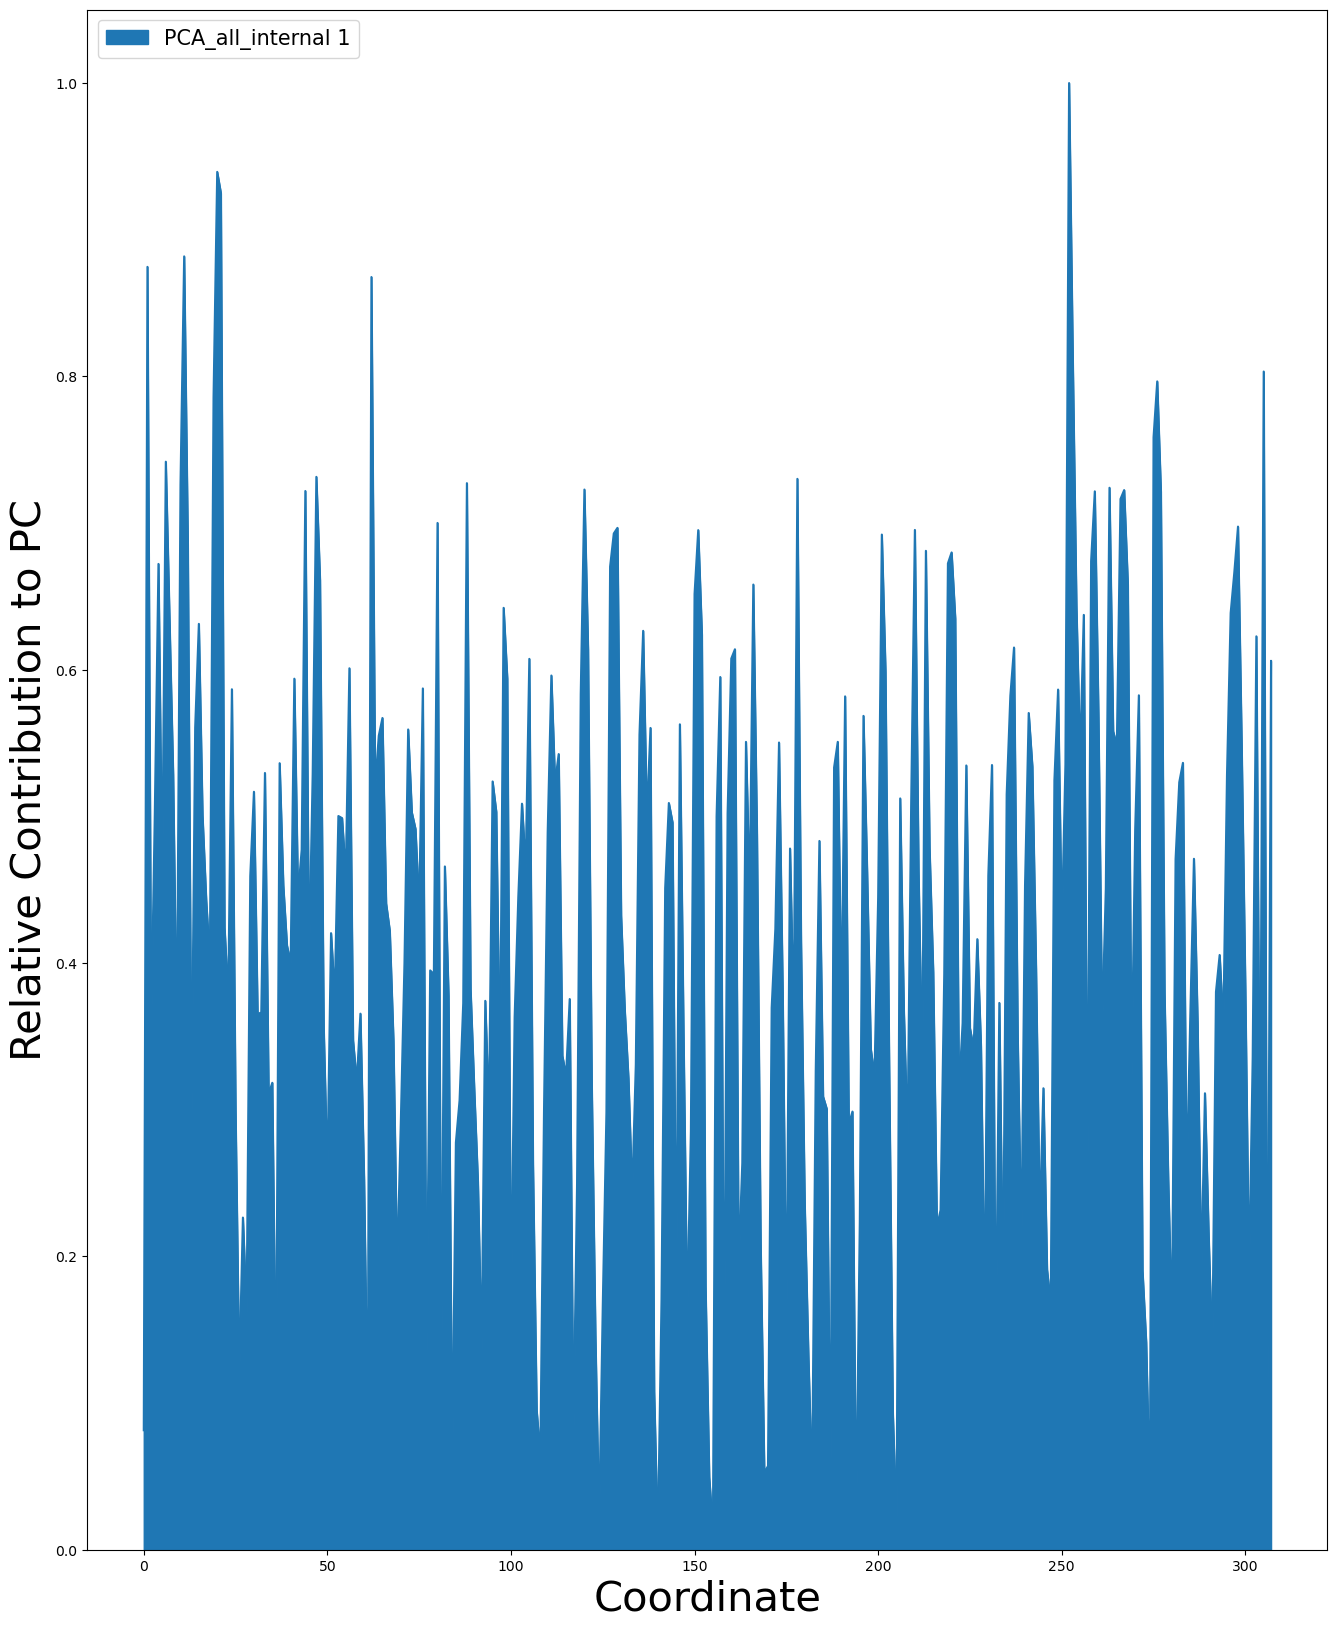

In [47]:
fontsize = 30
axs = df_PCA.plot.area(figsize=(16, 20), subplots=True)
for ax in axs:
    ax.legend(loc='upper left', fontsize = 15)
plt.xlabel('Coordinate',fontsize = fontsize)
axs[0].set_ylabel('Relative Contribution to PC',fontsize = fontsize)
plt.show()

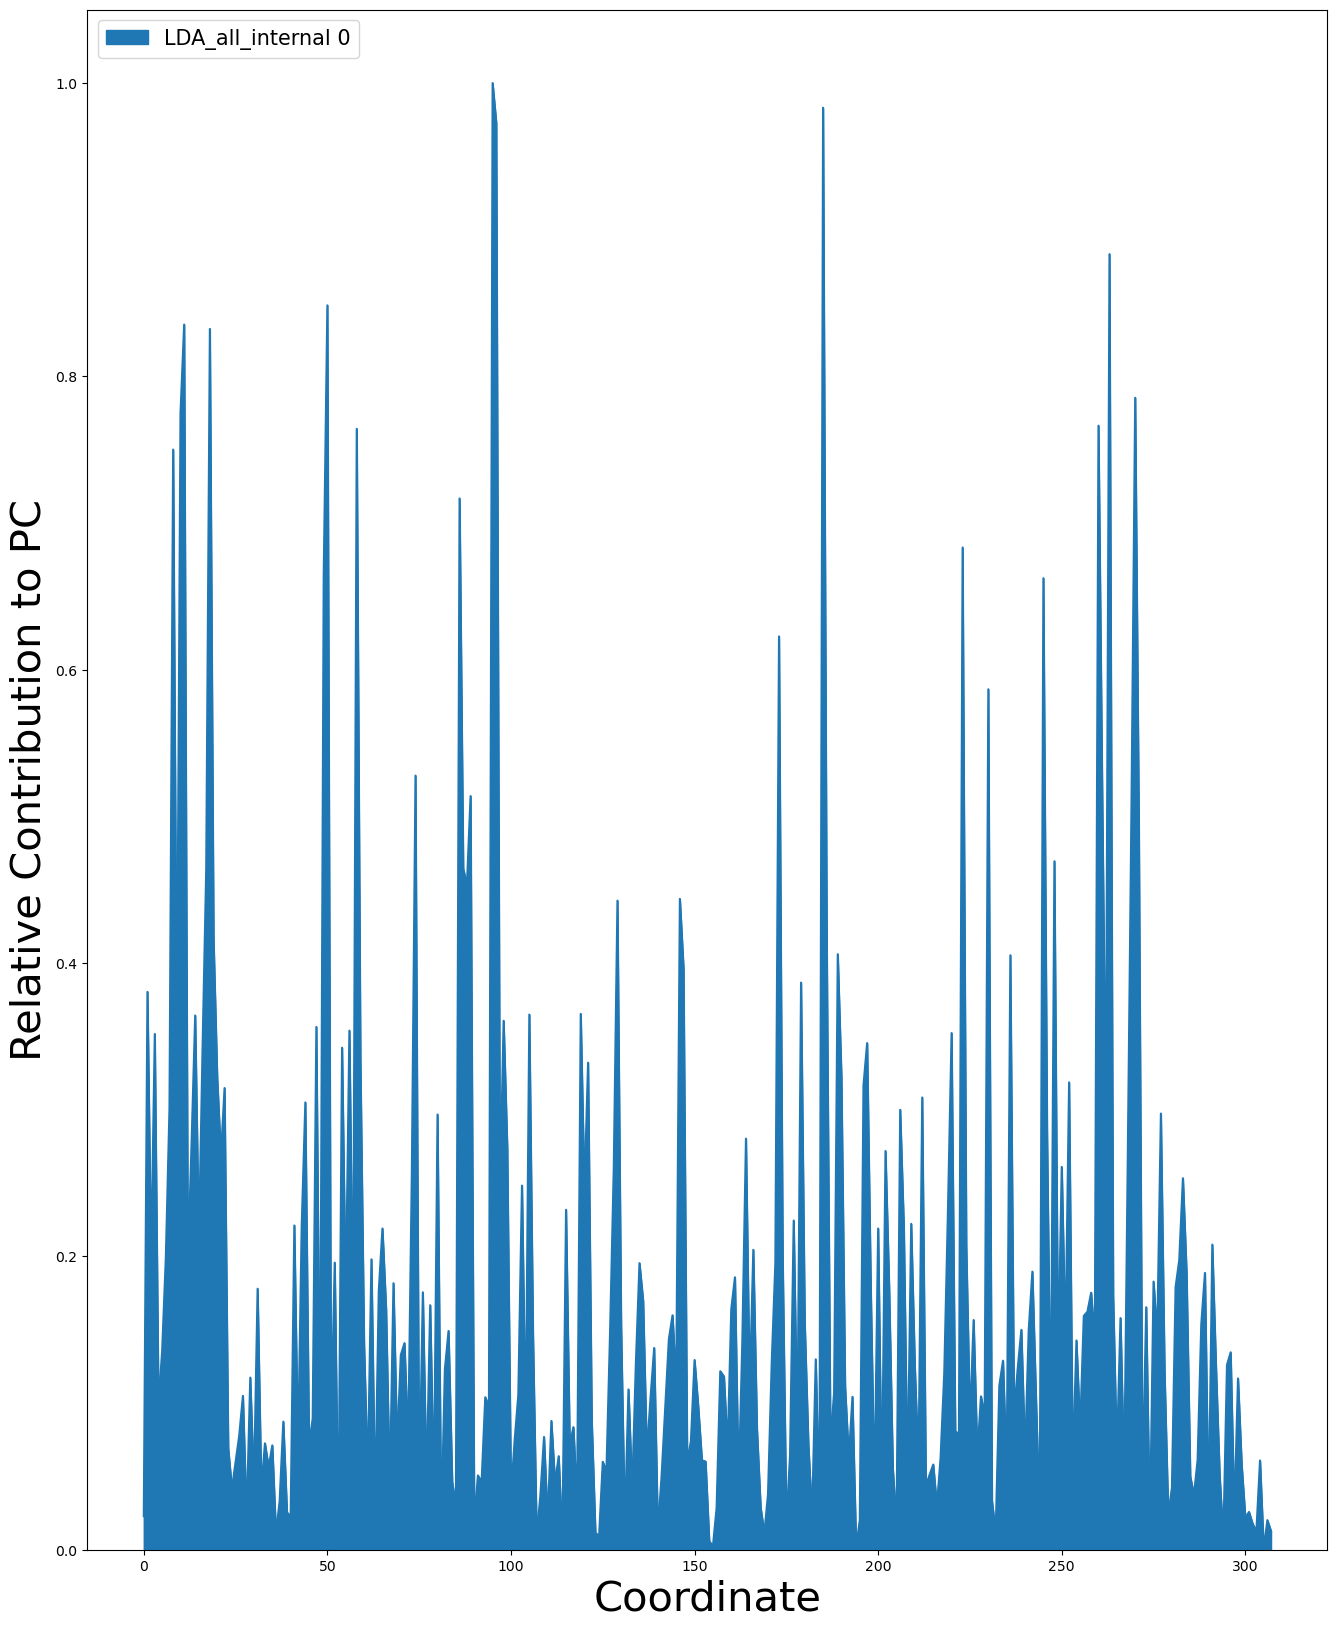

In [48]:
fontsize = 30
axs = df_LDA.plot.area(figsize=(16, 20), subplots=True)
for ax in axs:
    ax.legend(loc='upper left', fontsize = 15)
plt.xlabel('Coordinate',fontsize = fontsize)
axs[0].set_ylabel('Relative Contribution to PC',fontsize = fontsize)
plt.show()

# LDA Consensus Features

In this secion, we filter the features that appeared in at least 75% of the LDA as having high importance. This results in a reduced dataset which outperforms the separation obtainable with a single machine learning approach.

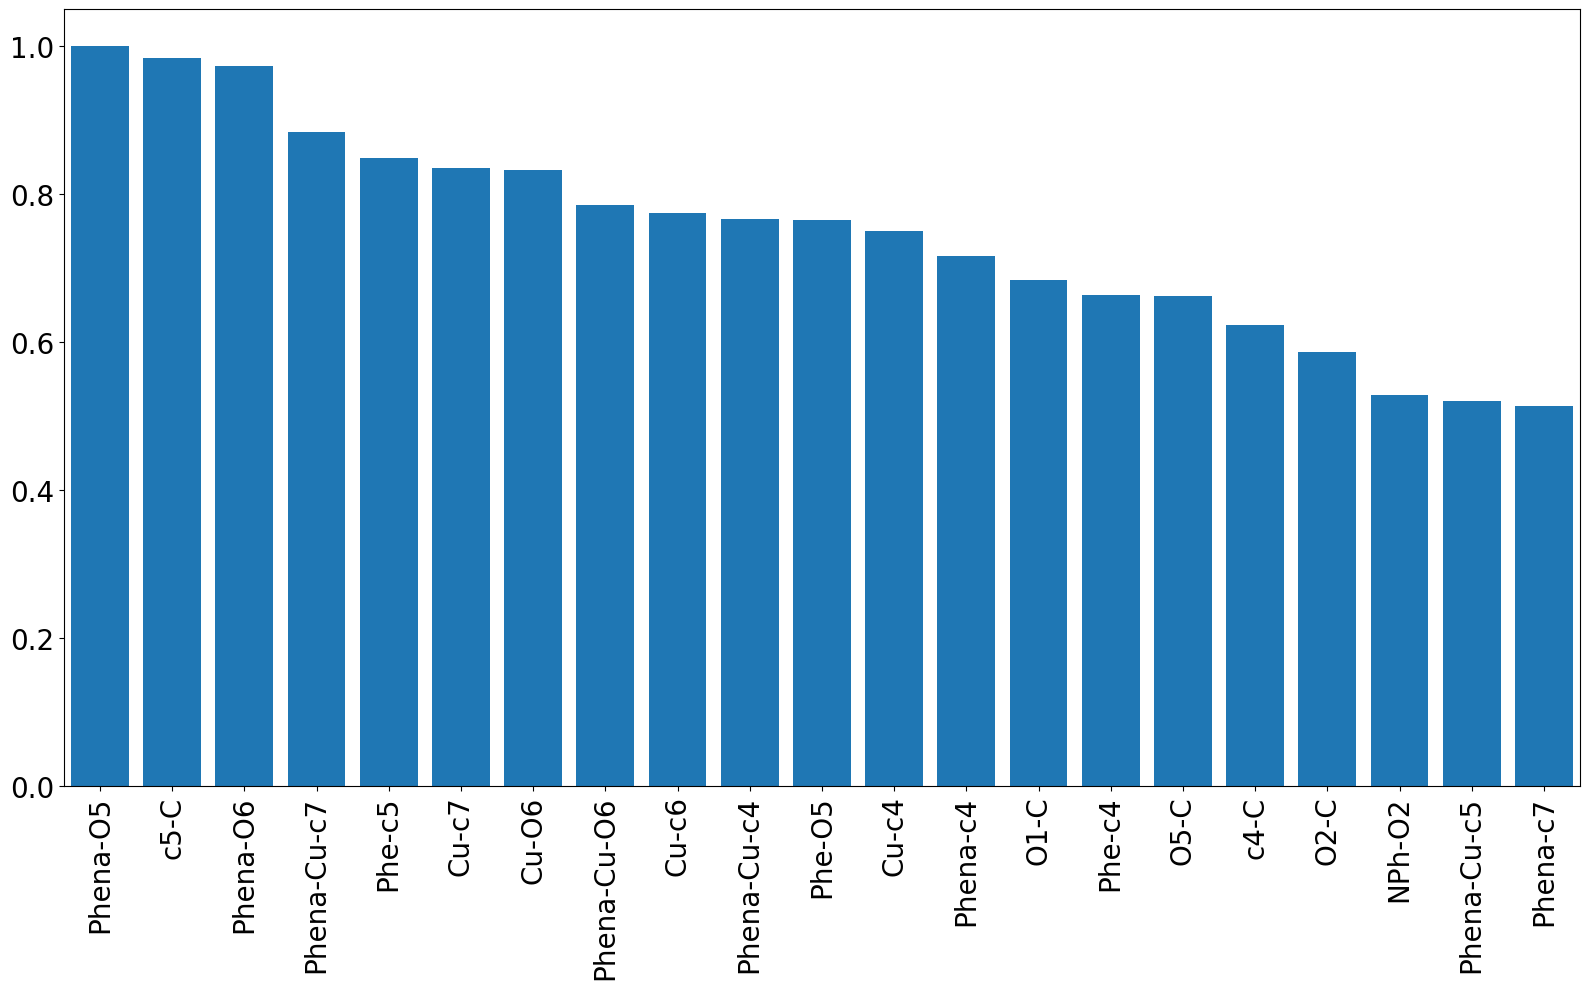

In [49]:
df_LDA_bool = (df_LDA>0.01)
consensus_LDA = np.where(df_LDA_bool.sum(axis=1)>df_LDA_bool.shape[1]*0.75)[0]
dfx = df_LDA.mean(axis=1)[consensus_LDA].to_frame()
dfx['id']=dfx.index
height = dfx.sort_values(0,ascending=[False]).values[:,0]
labels = dfx.sort_values(0,ascending=[False]).values[:,1].astype(int)
plt.figure(figsize=(16,10))
plt.bar(x = np.arange(consensus_LDA.shape[0]),height = height)
plt.xticks(ticks =  np.arange(consensus_LDA.shape[0]),labels=np.array(heatmap_labels)[labels],rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(-0.5,20.5)
plt.tight_layout()
lda_consensus_labels = copy.deepcopy(labels)

# PCA Consensus Features

In this secion, we filter the features that appeared in at least 75% of the PCA as having high importance. This results in a reduced dataset which outperforms the separation obtainable with a single machine learning approach.

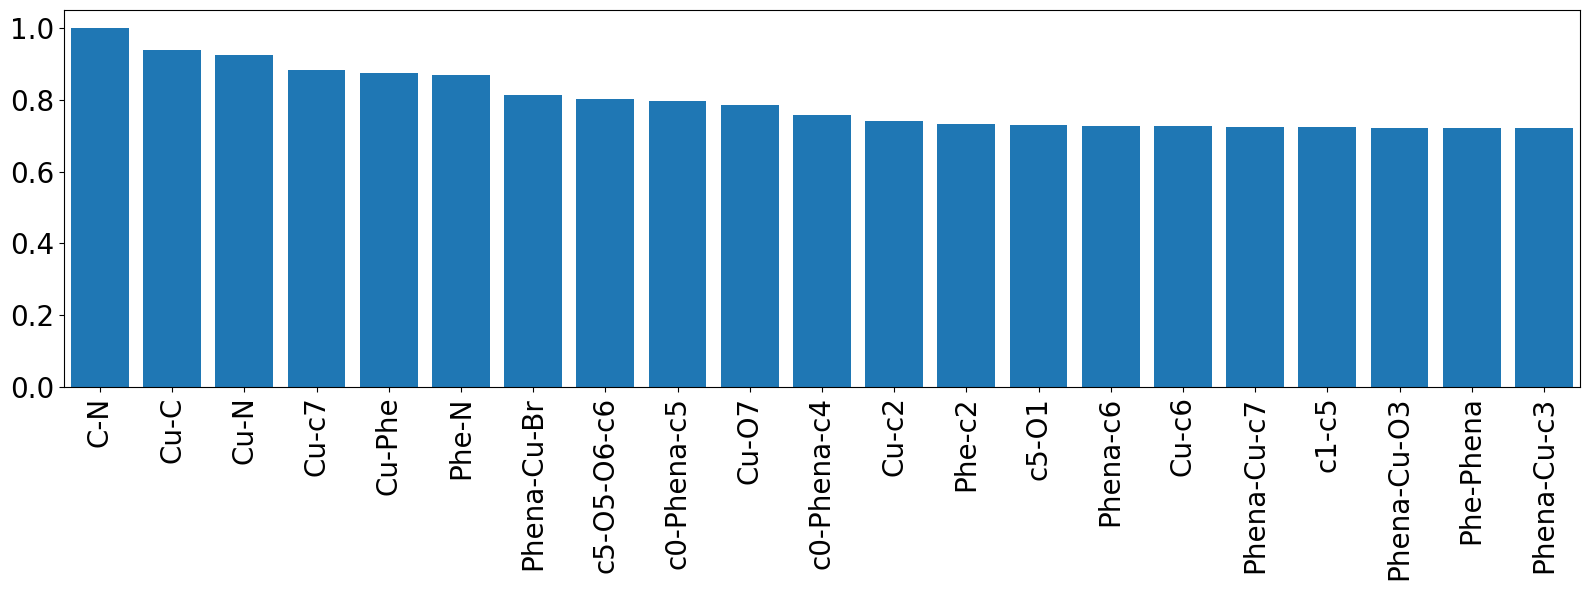

In [50]:
df_PCA_bool = (df_PCA>0.01)
consensus_PCA = np.where(df_PCA_bool.sum(axis=1)>df_PCA_bool.shape[1]*0.75)[0]
dfx = df_PCA.mean(axis=1)[consensus_PCA].to_frame()
dfx['id']=dfx.index
height = dfx.sort_values(0,ascending=[False]).values[:,0]
labels = dfx.sort_values(0,ascending=[False]).values[:,1].astype(int)
PCA_labels = copy.deepcopy(labels)
plt.figure(figsize=(16,6))
plt.bar(x = np.arange(consensus_PCA.shape[0]),height = height)
plt.xticks(ticks =  np.arange(consensus_PCA.shape[0]),labels=np.array(heatmap_labels)[labels],rotation=90,fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim(-0.5,20.5)
plt.tight_layout()
pca_consensus_labels = copy.deepcopy(labels)

In [51]:
PCA_consensus_internals = norm_internal[:,labels].shape
df_PCA_consensus = pd.DataFrame(norm_internal[:,labels], columns = np.array(heatmap_labels)[labels])

# PCA + LDA Consensus Features

In this secion, we filter the features that appeared in at least 75% of the PCA and LDA as having high importance. This results in a reduced dataset which outperforms the separation obtainable with a single machine learning approach.

(20000, 298)

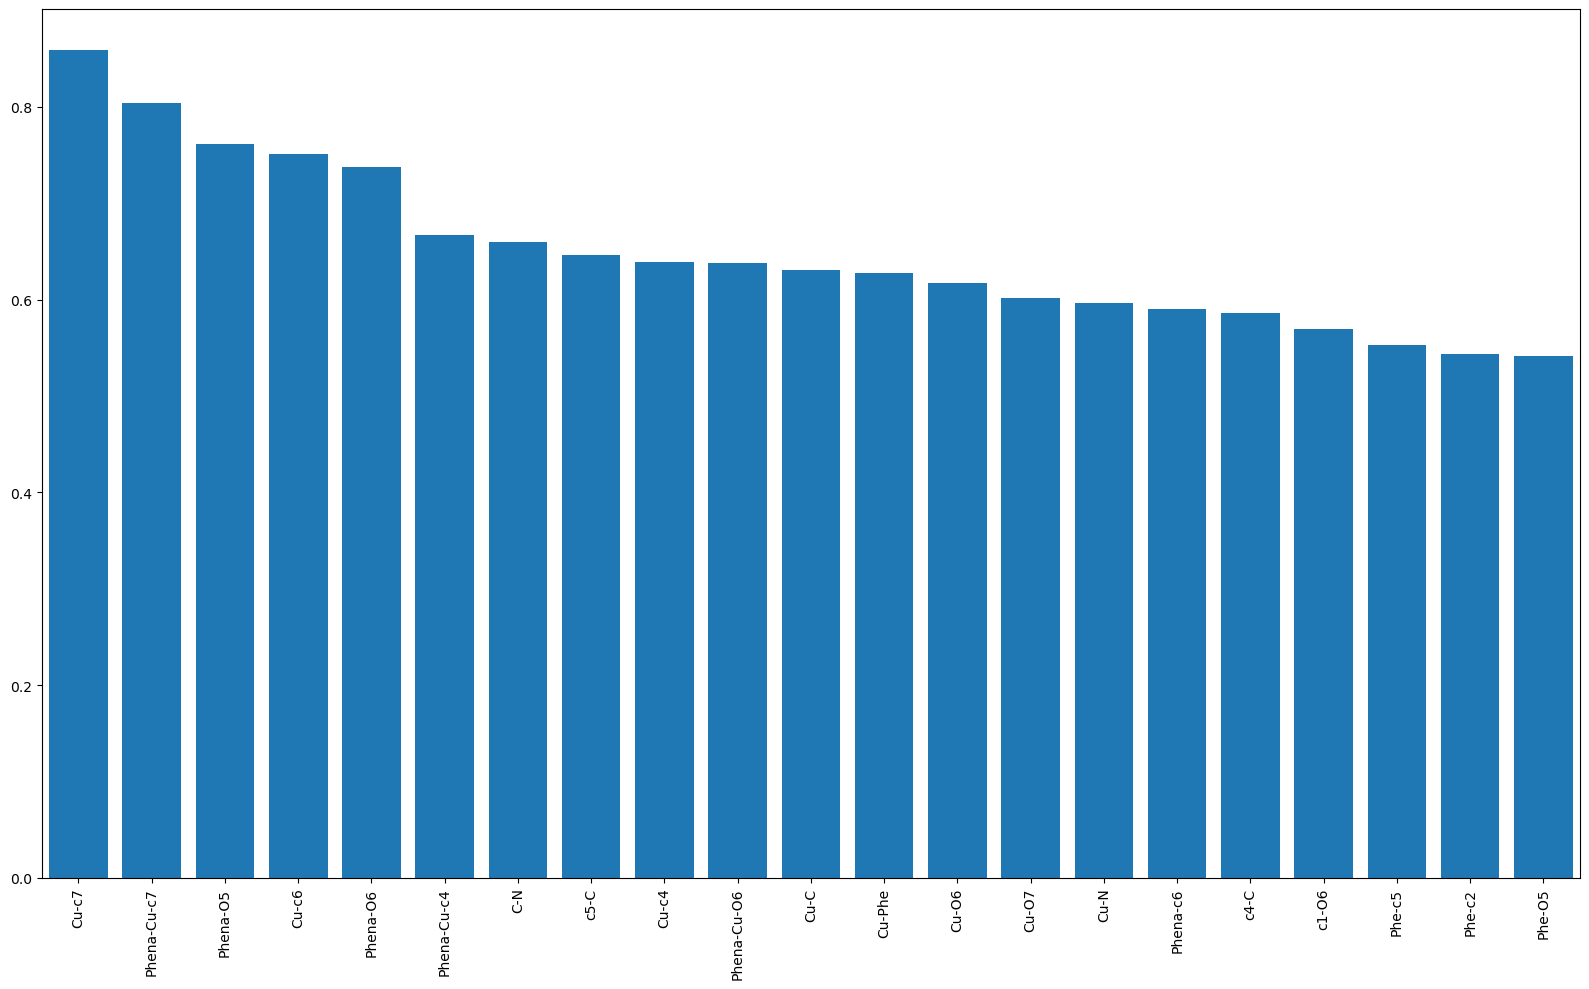

In [52]:
df_all_PCA_LDA = pd.concat([df_PCA,df_LDA], axis=1)
df_all_PCA_LDA_bool = (df_all_PCA_LDA>0.01)
consensus_Comb = np.where(df_all_PCA_LDA_bool.sum(axis=1)>df_all_PCA_LDA.shape[1]*0.7)[0]
dfx = df_all_PCA_LDA.mean(axis=1)[consensus_Comb].to_frame()
dfx['id']=dfx.index
height = dfx.sort_values(0,ascending=[False]).values[:,0]
labels = dfx.sort_values(0,ascending=[False]).values[:,1].astype(int)
Comb_labels = copy.deepcopy(labels)
plt.figure(figsize=(16,10))
plt.bar(x = np.arange(consensus_Comb.shape[0]),height = height)
plt.xticks(ticks =  np.arange(consensus_Comb.shape[0]),labels=np.array(heatmap_labels)[labels],rotation=90)
plt.xlim(-0.5,20.5)
plt.tight_layout()
df_PCA_consensus = pd.DataFrame(norm_internal[:,labels], columns = np.array(heatmap_labels)[labels])
df_PCA_consensus.shape

# Clustering of Features

Features are clustered according to their correlation to each other. This allows to better identify which internal coordinates move together and thus understand the behaviour of the system under investigation

In [53]:
#Reduce labels to a smaller dataset to demonstrate clustering
labels = labels[:20]
df_PCA_consensus = pd.DataFrame(norm_internal[:,labels], columns = np.array(heatmap_labels)[labels])

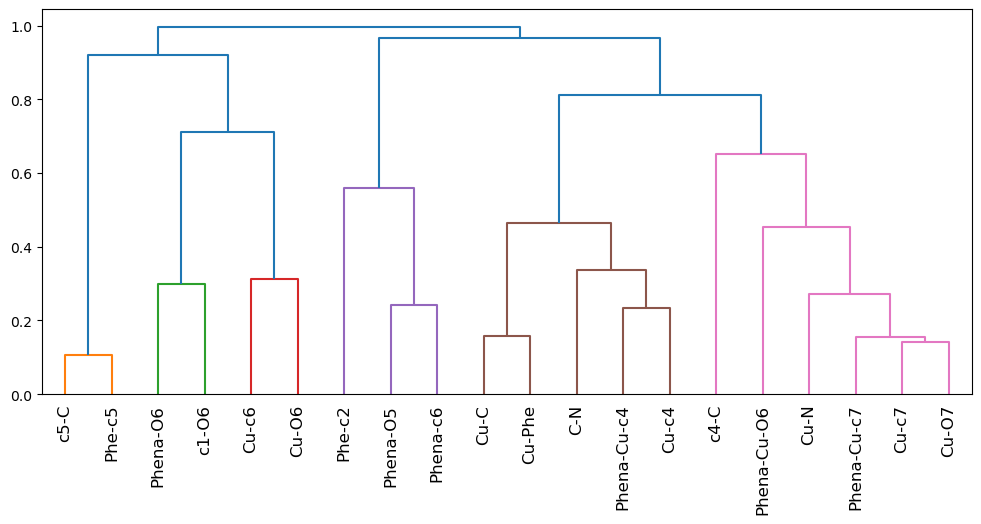

In [54]:
correlations = df_PCA_consensus.corr()

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=df_PCA_consensus.columns, orientation='top', 
           leaf_rotation=90);
# Clusterize the data
threshold = 0.4
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df_PCA_consensus.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_PCA_consensus[i])
    else:
        df_to_append = pd.DataFrame(df_PCA_consensus[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

### Clustermap

The clustermap combines the hierarchical clustering of features with the calculation of the correlation coefficients, thus revealing connected and opposite movements in the system.

<Figure size 3000x3000 with 0 Axes>

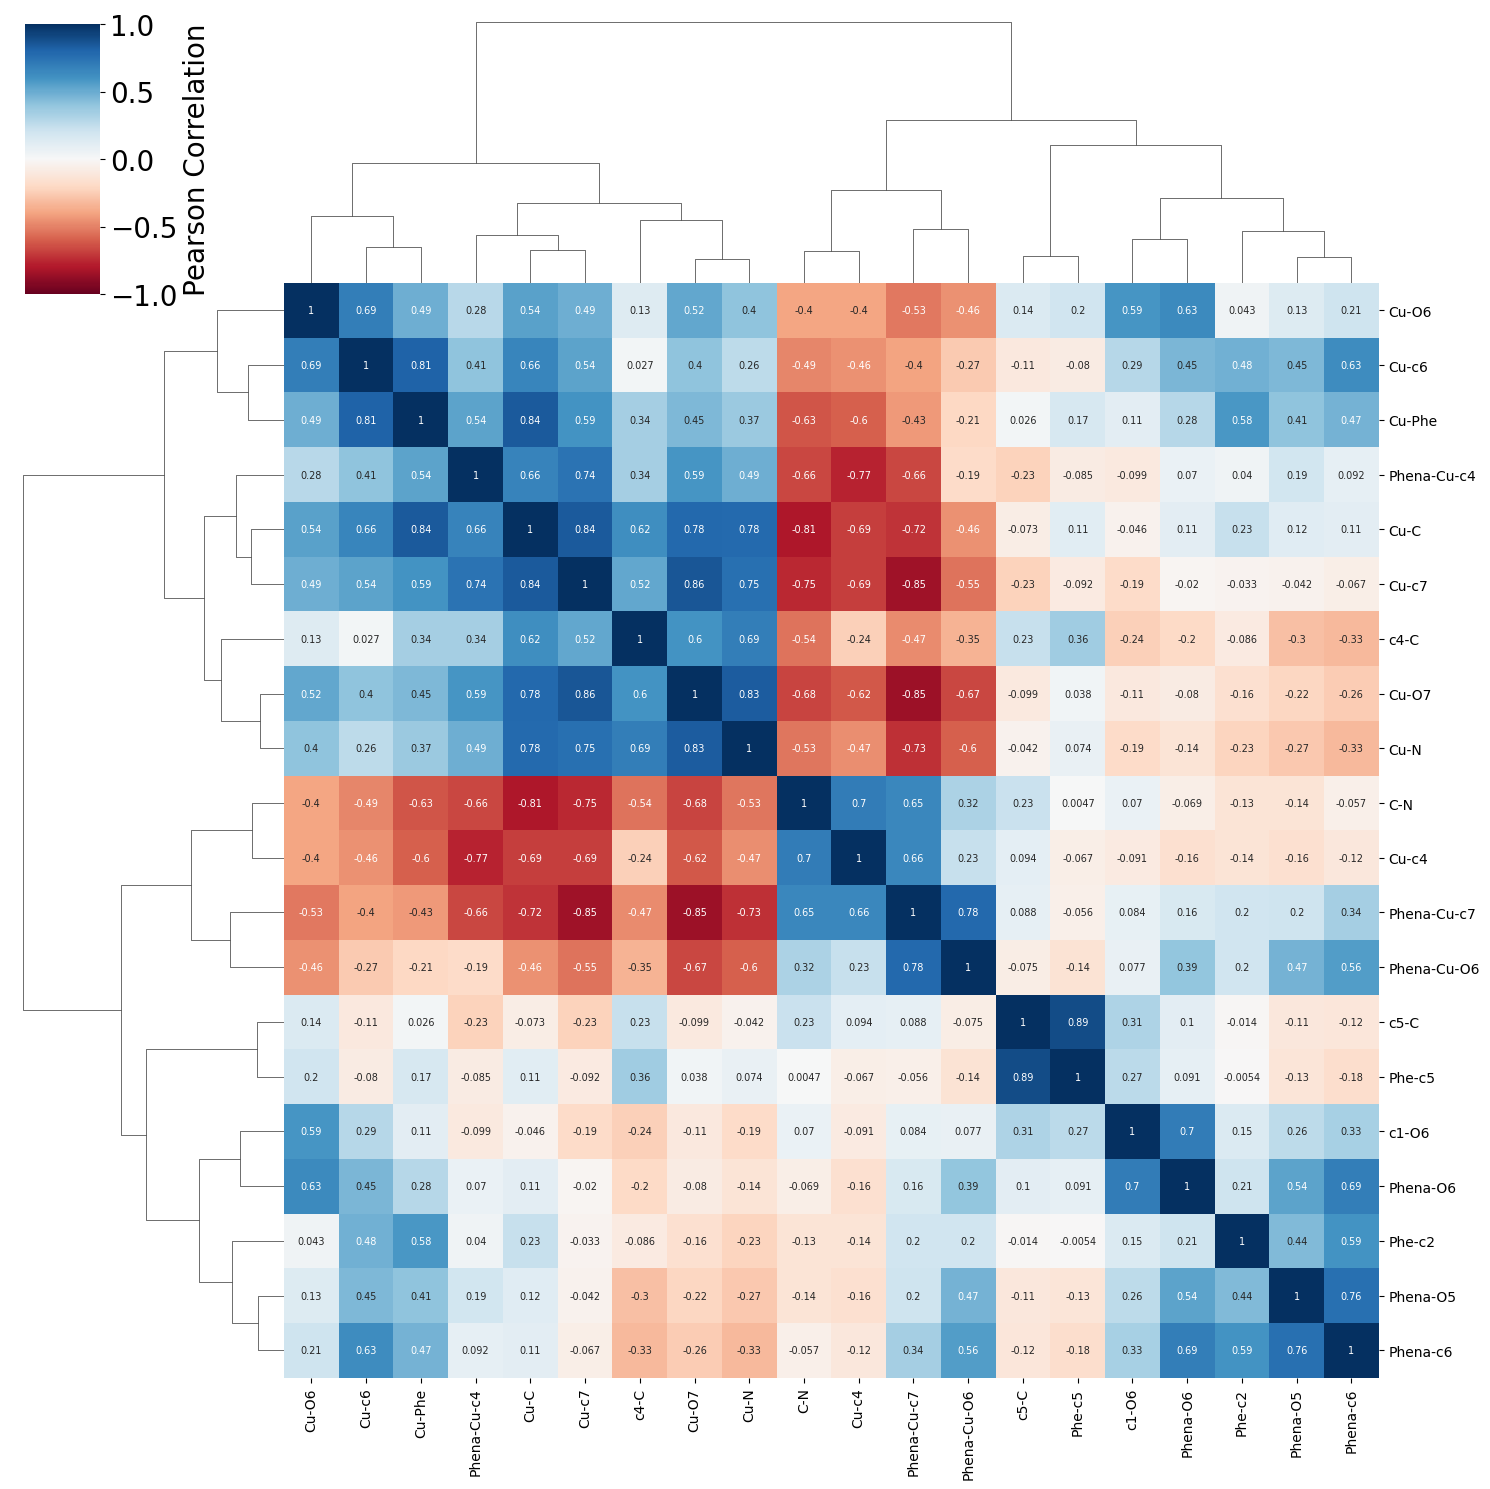

In [55]:
plt.figure(figsize=(30,30))
correlations = clustered.corr()
clm = sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,15),
                    cbar_kws={"label": "Pearson Correlation" ,
                          "ticks":[-1,-0.5,0,0.5,1] });
clm.ax_heatmap.set_xticklabels(clm.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
clm.ax_heatmap.set_yticklabels(clm.ax_heatmap.get_ymajorticklabels(), fontsize = 10)
clm.ax_cbar.set_ylabel("Pearson Correlation",size=20);
clm.ax_cbar.set_yticklabels(clm.ax_cbar.get_ymajorticklabels(),size=20);
# plt.tight_layout()

# Causality

Toda, H. Y and T. Yamamoto (1995). Statistical inferences in vector autoregressions with possibly integrated processes. Journal of Econometrics, 66, 225-250.

To infer Granger Causality (GC) we followed the protocol outlined by Toda, H. Y and T. Yamamoto63.

This involved performing the augmented Dickey-Fuller and Kwiatkowski–Phillips–Schmidt–Shin Tests to ascertain the stationarity of the various time series with respect to the mean and variance.

Non-stationary series, can be rendered stationary through differencing.

A multivariate vector autoregression model was constructed and fitted with lag times varying from 0 to 50, for each time series.

The appropriate lag time was chosen for each trajectory, based on the Akaike information criterion (AIC).

The correlated time series were checked for cointegration using the student t test.

Finally, a GC matrix (p <0.05) was calculated for each trajectory, using a VAM trained at the appropriate lag time. 

To account for the occurrence of false positives with repeated sampling of the reaction, we applied the false discovery rate (FDR) correction proposed by Benjamini and Hochberg, with a threshold of 10%.

In [56]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from pandas.plotting import lag_plot
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts 

from matplotlib.colors import ListedColormap

In [57]:
datasetC = df_PCA_consensus[:1000]
datasetC = datasetC[datasetC.columns[:10]] # reduce dataset as example

### The following steps are executed to infer causality`

# Step 1 -> verify the series are stationary using ADF and KPSS tests

## Augmented Dickey-Fuller Test

Dickey, D. A.; Fuller, W. A. Distribution of the Estimators for Autoregressive Time Series With a Unit Root. Journal of the American Statistical Association 1979, 74 (366), 427–431. https://doi.org/10.2307/2286348.	

In [58]:
def ADF_test(data, names,figsize = (16,10)):
    stationary_adful = []
    for element in names:
        stationary_adful.append(adfuller (data[element].values))
        if stationary_adful[-1][0] <stationary_adful[-1][4]['10%']:
            print(element)
        print('Test Statistic: %f' %stationary_adful[-1][0])
        print('p-value: %f' %stationary_adful[-1][1])
        print('Critical values:')
        for key, value in stationary_adful[-1][4].items ():
             print('\t%s: %.3f' %(key, value))
    
    stationary_adful = np.array(stationary_adful)
    
    fontsize = 20
    plt.figure(figsize=figsize)
    plt.bar(x = np.arange(stationary_adful[:,0].shape[0]), height = stationary_adful[:,0], label = 'Test Statistic')
    plt.hlines(xmin = -1, xmax = stationary_adful[:,0].shape[0]+1, y=stationary_adful[-1][4]['10%'], color='black', label = '10% Critical value')
    plt.hlines(xmin = -1, xmax = stationary_adful[:,0].shape[0]+1, y=stationary_adful[-1][4]['5%'], color='red', label = '5% Critical value')
    plt.hlines(xmin = -1, xmax = stationary_adful[:,0].shape[0]+1, y=stationary_adful[-1][4]['1%'], color='orange', label = '1% Critical value')
    plt.xticks(ticks =  np.arange(names.shape[0]),labels=names,rotation=90, fontsize = fontsize*0.8)
    plt.tight_layout()
    plt.xlim((-1,stationary_adful[:,0].shape[0]))
    plt.ylabel('Augmented Dickey-Fuller Test Statistic', fontsize = fontsize)
    plt.legend(fontsize = fontsize)
    plt.show()

#### Bars should be below the red line if a series is stationary

Test Statistic: -0.839730
p-value: 0.807172
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Test Statistic: -1.203997
p-value: 0.671874
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Phena-O5
Test Statistic: -3.775653
p-value: 0.003166
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Test Statistic: -1.818454
p-value: 0.371339
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Phena-O6
Test Statistic: -3.628828
p-value: 0.005233
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Test Statistic: -1.085570
p-value: 0.720792
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Test Statistic: -0.918599
p-value: 0.781786
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
c5-C
Test Statistic: -4.190773
p-value: 0.000683
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Test Statistic: -1.325166
p-value: 0.617582
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Phena-Cu-O6
Test Statistic: -4.008632
p-value: 0.001366
Critical values:
	1%: -3.437
	5%: -2.86

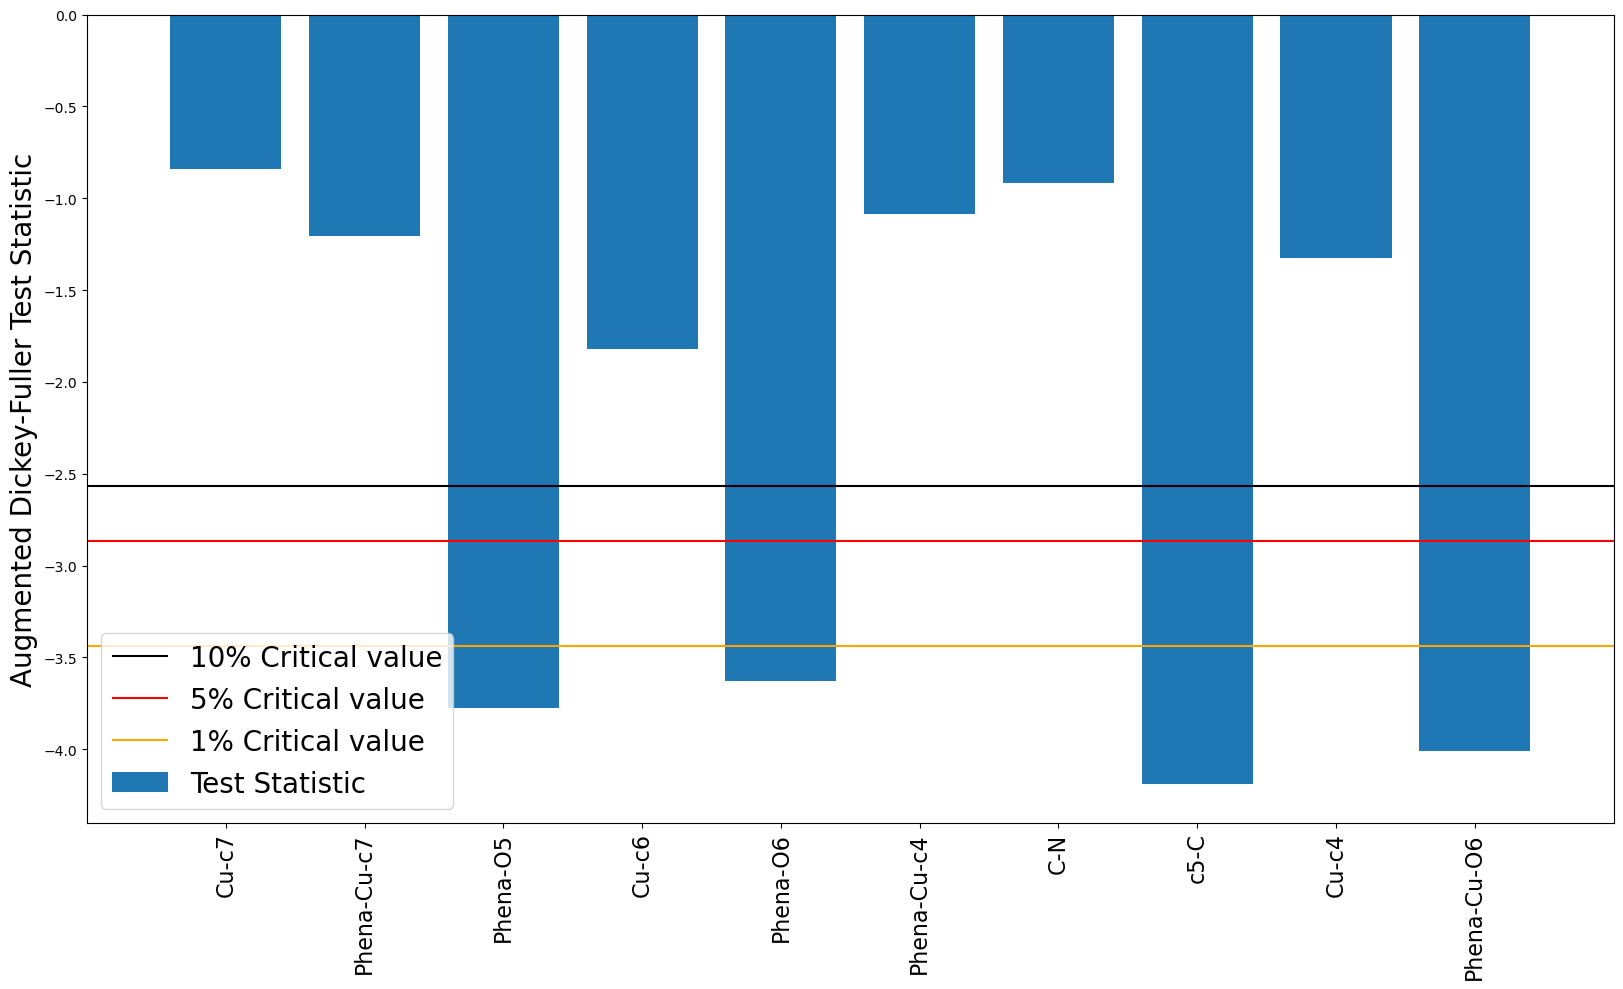

In [59]:
ADF_test(datasetC, names=datasetC.columns[:10])

## Kwiatkowski–Phillips–Schmidt–Shin Test

Kwiatkowski, D.; Phillips, P. C. B.; Schmidt, P.; Shin, Y. Testing the Null Hypothesis of Stationarity against the Alternative of a Unit Root: How Sure Are We That Economic Time Series Have a Unit Root? Journal of Econometrics 1992, 54 (1), 159–178. https://doi.org/10.1016/0304-4076(92)90104-Y

In [60]:
def KPSS_test(data, names,figsize = (16,10)):
    stationary= []
    for element in names:
        statistic, p_value, n_lags, critical_values = kpss(data[element])
        stationary.append(statistic)
    
    stationary = np.array(stationary)
    fontsize = 20
    plt.figure(figsize=figsize)
    plt.bar(x = np.arange(stationary.shape[0]), height = stationary, label = 'Test Statistic')
    plt.hlines(xmin = -1, xmax = stationary.shape[0]+1, y=critical_values['10%'], color='black', label = '10% Critical value')
    plt.hlines(xmin = -1, xmax = stationary.shape[0]+1, y=critical_values['5%'], color='red', label = '5% Critical value')
    plt.hlines(xmin = -1, xmax = stationary.shape[0]+1, y=critical_values['1%'], color='orange', label = '1% Critical value')
    plt.xticks(ticks =  np.arange(names.shape[0]),labels=names,rotation=90, fontsize = fontsize*0.8)
    plt.tight_layout()
    # plt.xlim((-1,stationary_adful[:,0].shape[0]))
    plt.ylabel('Kwiatkowski–Phillips–Schmidt–Shin Test Statistic', fontsize = fontsize)
    plt.legend(fontsize = fontsize)
    plt.show()

#### Bars should be above the red line if a series is stationary

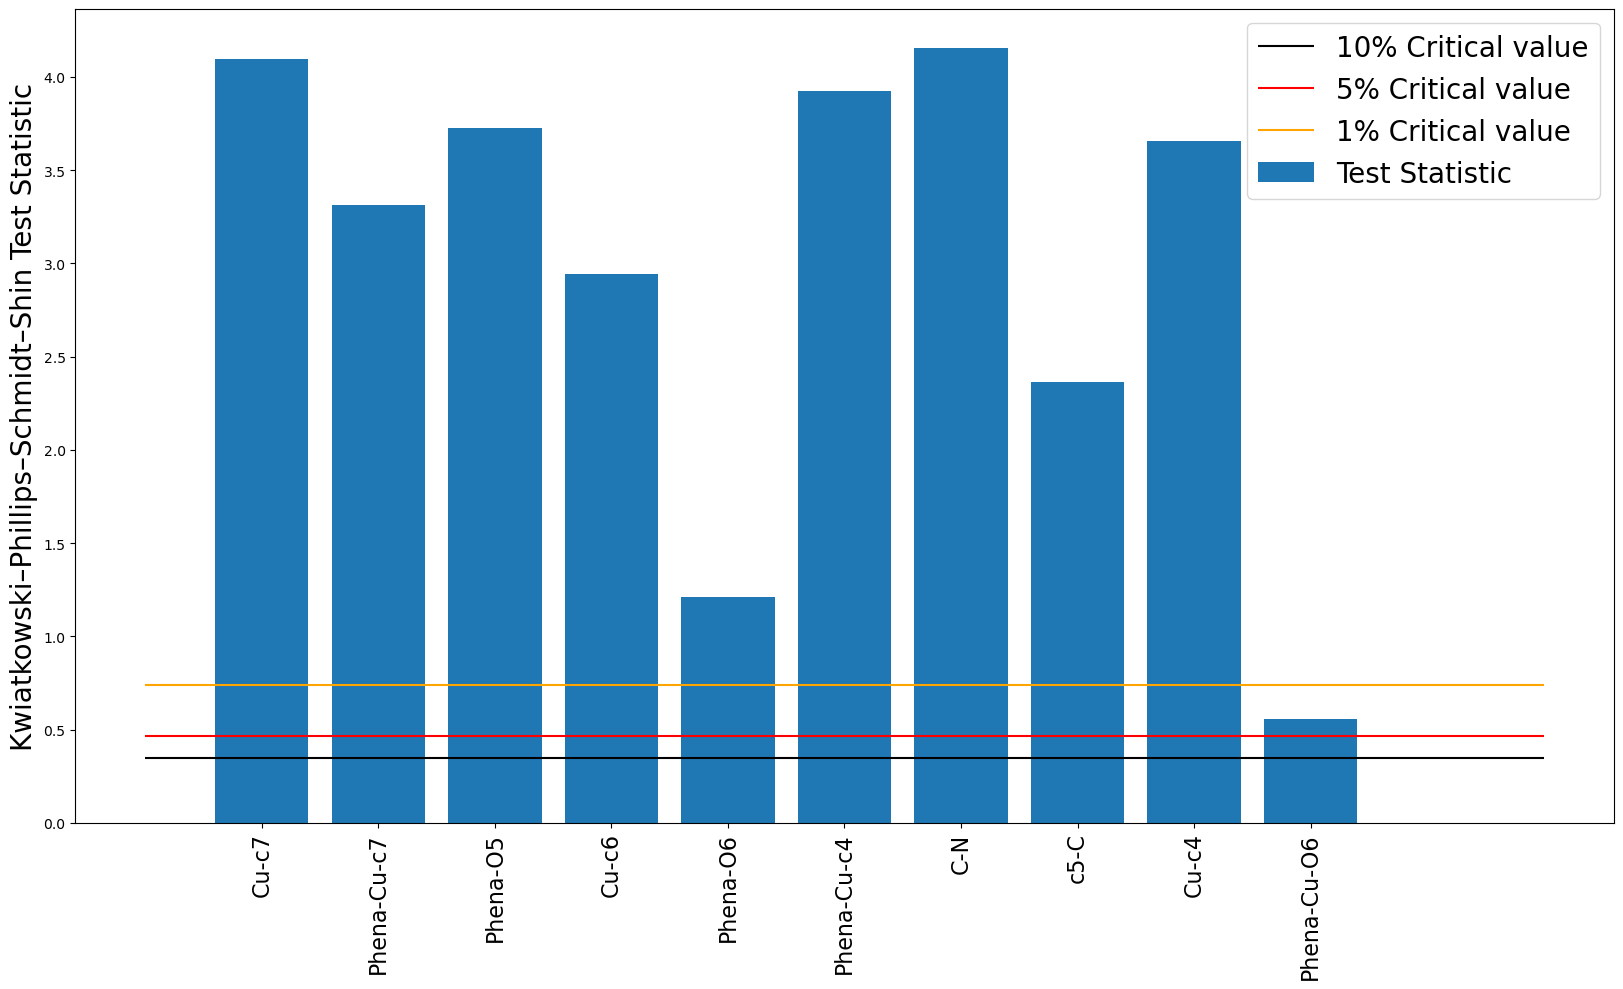

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    KPSS_test(datasetC, names=datasetC.columns[:10])

# Step 2 -> Determine the order of non-stationary series by differentiating the data, if they are not stationary

Cu-c7
Test Statistic: -8.814752
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Phena-Cu-c7
Test Statistic: -9.583347
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Phena-O5
Test Statistic: -9.819865
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Cu-c6
Test Statistic: -7.544812
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Phena-O6
Test Statistic: -8.098989
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Phena-Cu-c4
Test Statistic: -8.565423
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
C-N
Test Statistic: -6.981396
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
c5-C
Test Statistic: -11.073945
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Cu-c4
Test Statistic: -12.019370
p-value: 0.000000
Critical values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Phena-Cu-O6
Test Statistic: -11.830095
p-value:

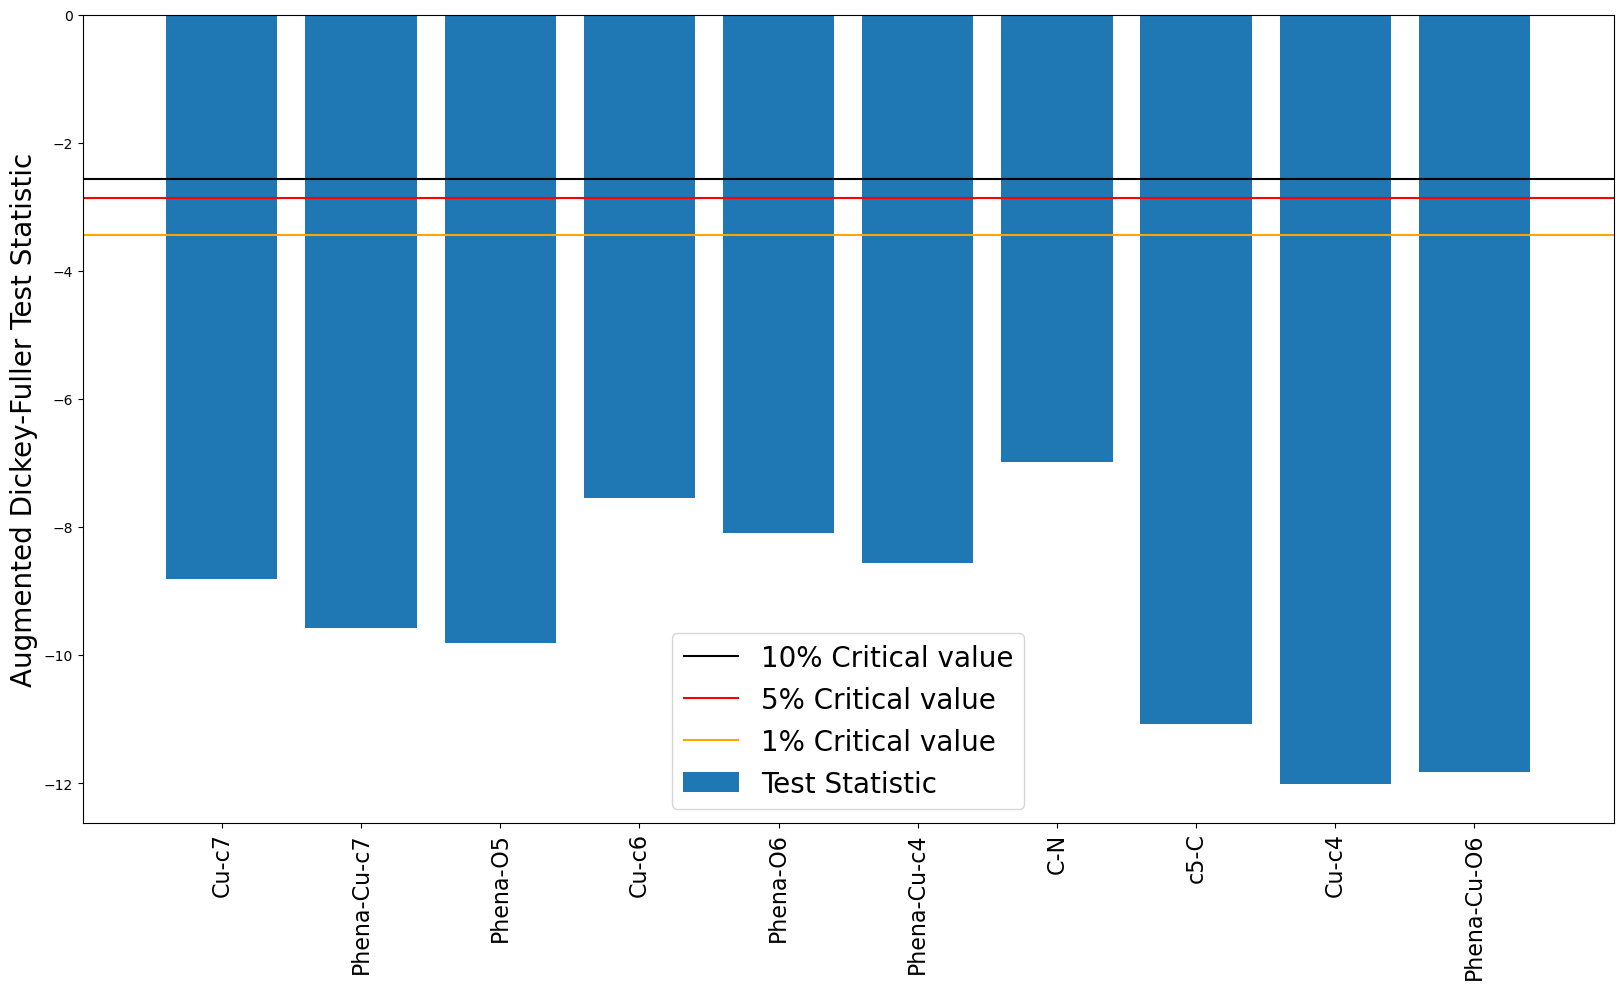

In [62]:
datasetC_diff = datasetC.diff().dropna()
ADF_test(datasetC_diff, names = datasetC_diff.columns)

Maximum order of integration of the series is 1, as there is only one difference to be computed in order for all series to be stationary, as shown by thests in step 1

# Step 4 -> prepare a VAR model

A Vector autoregression (VAR) model is a statistical model used to capture the relationship between multiple variables as they evolve over time.

Lütkepohl, H. Introduction to Multiple Time Series Analysis; Springer: Berlin, Heidelberg, 1991. https://doi.org/10.1007/978-3-662-02691-5.

Sims, C. A. Macroeconomics and Reality. Econometrica 1980, 48 (1), 1–48. https://doi.org/10.2307/1912017.


In [63]:
model = VAR(datasetC)


In [64]:
Var_lags = []
for i in range(1,50):
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC: ', result.hqic, '\n')
        Var_lags.append([result.aic])
    except:
        continue
Var_lags = np.array(Var_lags)

Lag Order = 1
AIC:  -75.2354490491445 

Lag Order = 2
AIC:  -81.21622208474214 

Lag Order = 3
AIC:  -82.47418988636427 

Lag Order = 4
AIC:  -82.92035782374683 

Lag Order = 5
AIC:  -83.01556172837118 

Lag Order = 6
AIC:  -83.13648610153503 

Lag Order = 7
AIC:  -83.34721696381871 

Lag Order = 8
AIC:  -83.39251025968245 

Lag Order = 9
AIC:  -83.39779940566055 

Lag Order = 10
AIC:  -83.418296076395 

Lag Order = 11
AIC:  -83.34514335393877 

Lag Order = 12
AIC:  -83.14752869278347 

Lag Order = 13
AIC:  -82.93915239893776 

Lag Order = 14
AIC:  -82.78235684265309 

Lag Order = 15
AIC:  -82.6281188370707 

Lag Order = 16
AIC:  -82.45092946518704 

Lag Order = 17
AIC:  -82.25463261674747 

Lag Order = 18
AIC:  -82.07245638411955 

Lag Order = 19
AIC:  -81.907485249863 

Lag Order = 20
AIC:  -81.68344977283778 

Lag Order = 21
AIC:  -81.40940694147501 

Lag Order = 22
AIC:  -81.23914378971388 

Lag Order = 23
AIC:  -81.01163722787203 

Lag Order = 24
AIC:  -80.76918829769953 

Lag Ord

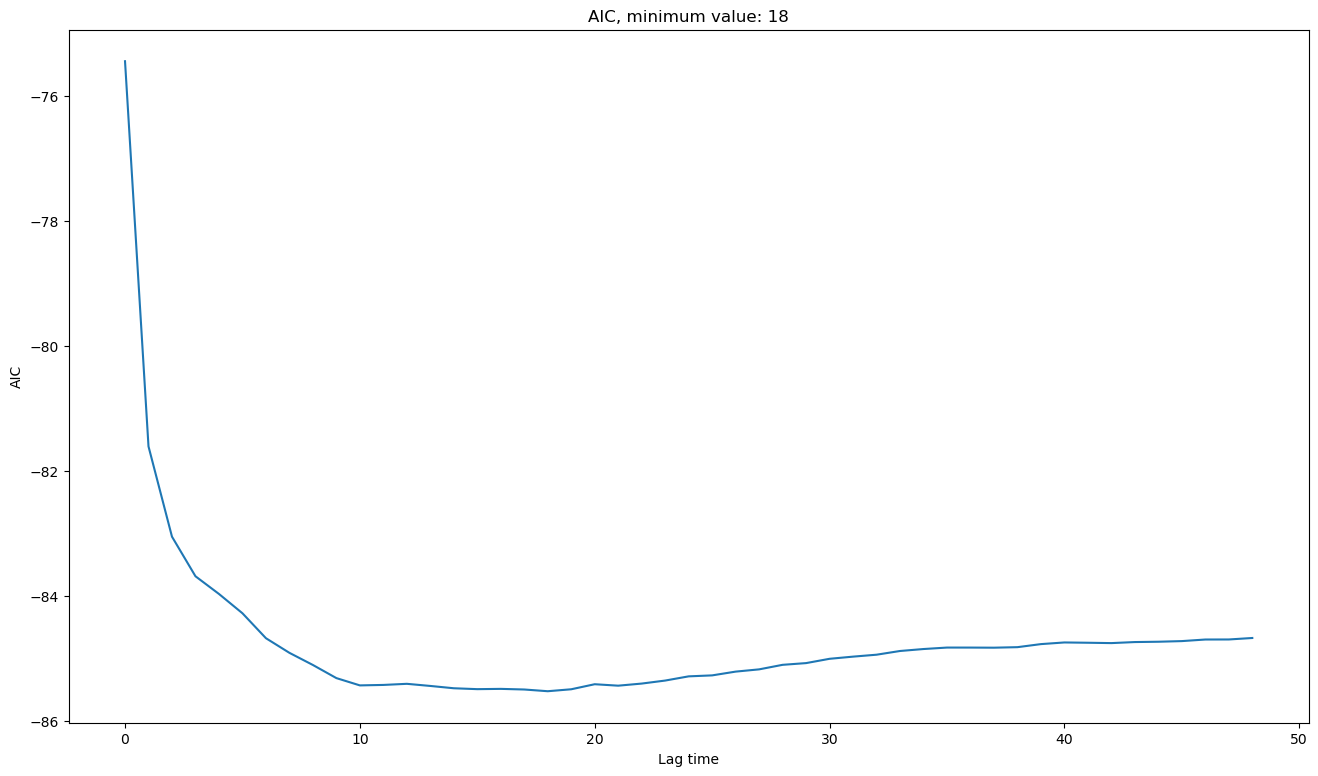

In [65]:

# Var_lags_normed = Var_lags / Var_lags.max(axis=0)
for element in Var_lags.T:
    plt.figure(figsize=(16,9))
    plt.plot(element)
plt.title('AIC, minimum value: {}'.format(np.argmin(element)))
plt.xlabel('Lag time')
plt.ylabel('AIC')
plt.show()

# Step 4 -> Choose lag order, according to Akaike Information Criterion

Akaike, H. A New Look at the Statistical Model Identification. IEEE Transactions on Automatic Control 1974, 19 (6), 716–723. https://doi.org/10.1109/TAC.1974.1100705.

Baguley, Thomas. Serious stats: A guide to advanced statistics for the behavioral sciences. Palgrave Macmillan, 2012. (page 402) -> AIC values meaning

In [66]:
true_lag = 18 #The Lag time should be chosen for the minimum value of AIC

# Step 5 -> Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

The value of this statistic can vary between 0 and 4. 

The closer it is to the value 2, then there is no significant serial correlation. 

The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

/home/rat/.envs/scikit_PCA/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


Text(0.5, 0, 'Internal coordinate')

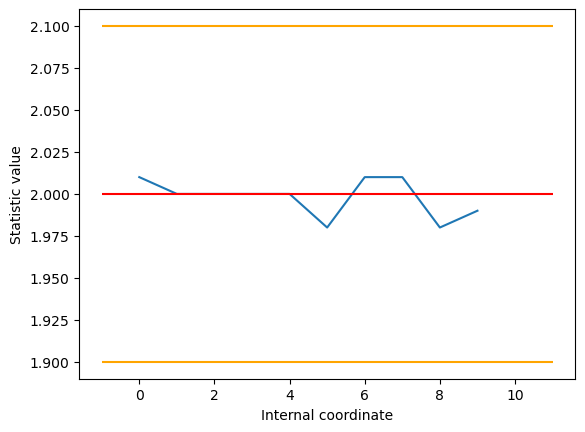

In [67]:
train, test = train_test_split(datasetC_diff, test_size=0.2)
model = VAR(train)
model_fitted = model.fit(3)
DW_stat = []
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(datasetC_diff.columns, out):
    DW_stat.append(round(val, 2))
plt.plot(DW_stat)
plt.hlines(xmin = -1, xmax = len(DW_stat)+1, y=2, color='red')
plt.hlines(xmin = -1, xmax = len(DW_stat)+1, y=2*1.05, color='orange')
plt.hlines(xmin = -1, xmax = len(DW_stat)+1, y=2*0.95, color='orange')
plt.ylabel('Statistic value')
plt.xlabel('Internal coordinate')

# Step 6 -> Check for co-integration using t-statistics

In [68]:
#if nothing is printed, series are cointegrated

import statsmodels.tsa.stattools as ts 

for elementi in datasetC.columns:
    for elementj in datasetC.columns:
        result=ts.coint(datasetC['C-N'], datasetC['Cu-c4'])
        if result[1]> 0.05:
            print('{}-{}: {}'.format(elementi, elementj,result[1]))

All features seem to be cointegrated per above test

# Step 7 -> train VAR at appropriate lagtime as decided by AIC

In [69]:
model = VAR(train)
model_fitted = model.fit(true_lag)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

18


/home/rat/.envs/scikit_PCA/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.


# Steps 8 -> determine Granger Causality

The Granger Causality allows one to determine the relationship between time series, thus defining a sequence of events, with one time series influencing the other.

In [70]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#### The granger matrix represents a plot of X causes Y, which means that the column labels cause the row labels, when the square is not white. The test statistic is 0.05

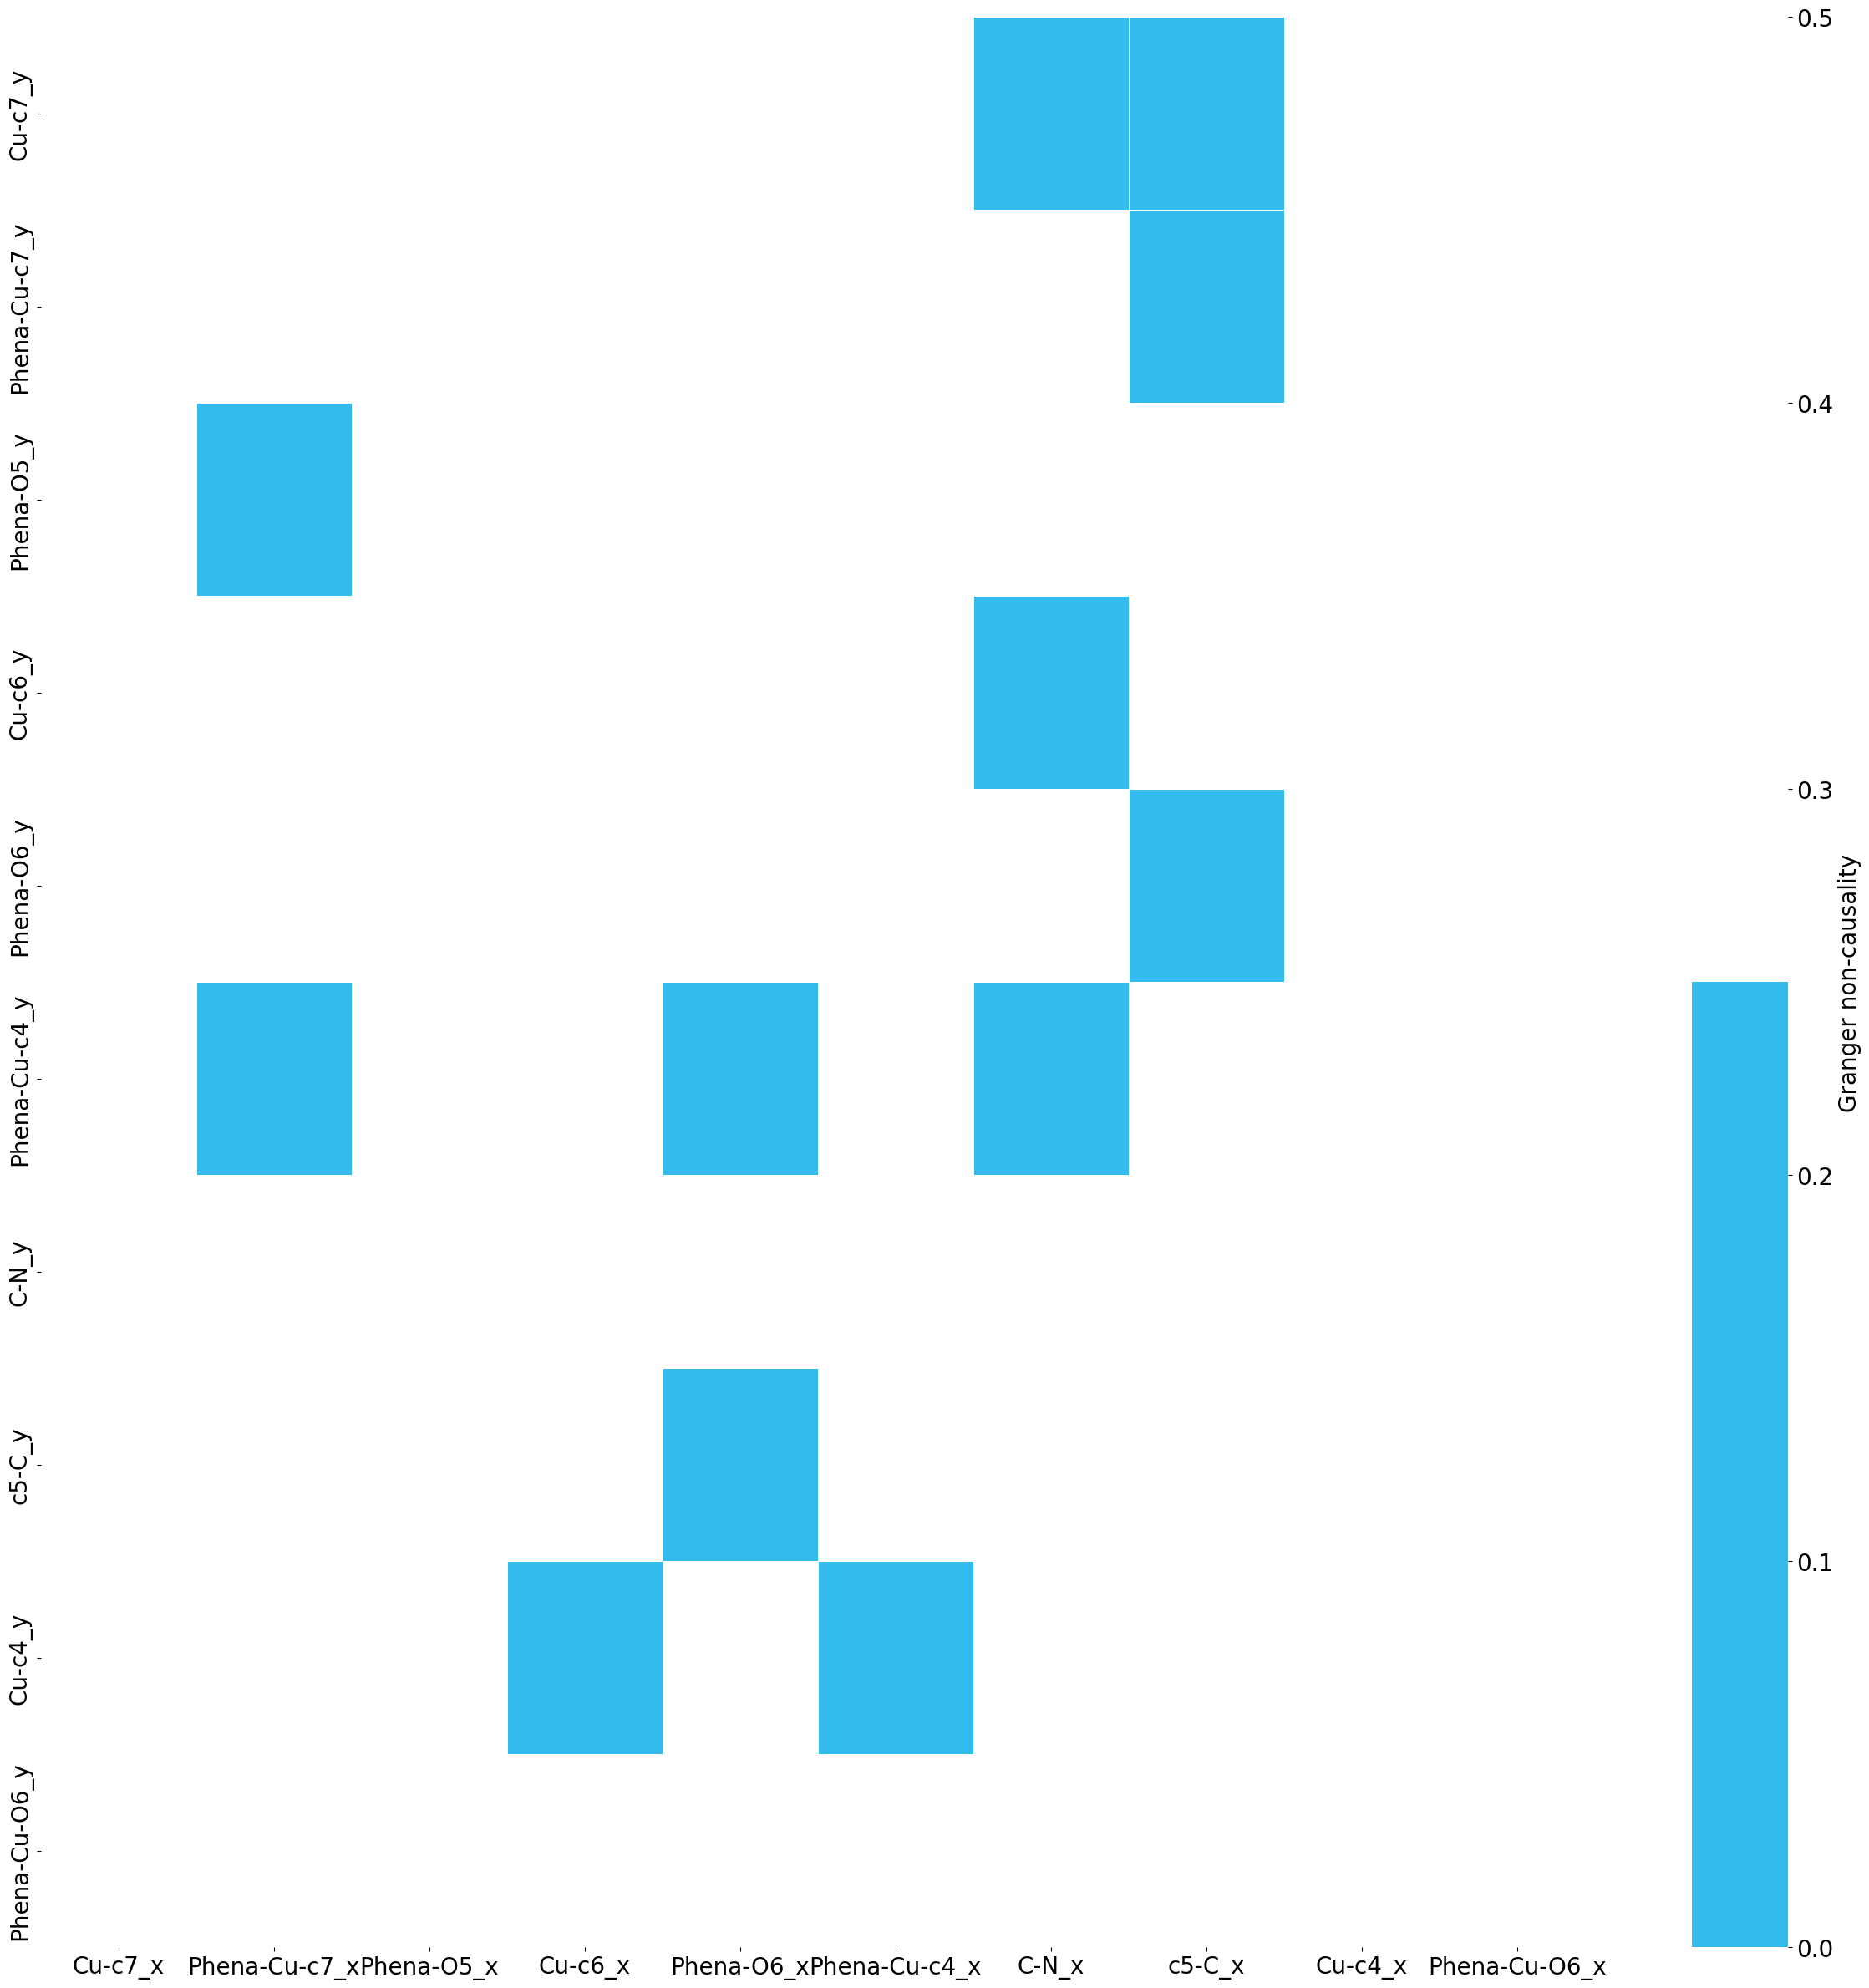

In [71]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ox = granger_causation_matrix(train, train.columns, true_lag)
ox_check = copy.deepcopy(ox.values)
ox_check[ox_check>=0.05]=0.5
ox_check[ox_check<0.05]=0
from matplotlib.colors import ListedColormap
cmap_dict = {1: '#FFFFFF', 0: '#33BBEE'}
cmap = ListedColormap([cmap_dict[i] for i in range(2)])

fontsize = 20
fig, ax = plt.subplots(figsize=(30,30))
sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(ox_check, ax = ax, annot=False, linewidth=0.5,
            # cmap = sns.color_palette("coolwarm", as_cmap=True),
            
            cmap = cmap,
            xticklabels = ox.columns , yticklabels=ox.index)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = fontsize)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = fontsize)
ax.figure.axes[-1].set_ylabel('Granger non-causality', size=20)
ax.figure.axes[-1].tick_params(labelsize=20)
plt.show()

# Implement False Discovery Rate and Restriction

False Discovery Rate (FDR) corrections are implemented using the Benjamini and Hochberg:

Benjamini, Y.; Hochberg, Y. Controlling the False Discovery Rate: A Practical and Powerful Approach to Multiple Testing. Journal of the Royal Statistical Society. Series B (Methodological) 1995, 57 (1), 289–300.

This limits the false detection rate for repeated observations and is essential to not overinterpret causality results

In [72]:
from statsmodels.stats.multitest import fdrcorrection
import statsmodels
from statsmodels.sandbox.stats.multicomp import multipletests

In [73]:
#mock dataset to show FDR corrections to p_values. For proper FDR, the Causality analysis is run for each simulation trajectory
orbs_educt = [ox,ox,ox]
CN_pvalues = np.empty((3,10))
fdr_ms_pvalues_bool = np.empty((3,10))
for i,df_orbs in enumerate(orbs_educt):
    CN_pvalues[i] = df_orbs.values[6]

for i,el in enumerate(CN_pvalues.T):
    fdr_ms_pvalues_bool[:,i] = multipletests(el, alpha = 0.1, method = "fdr_tsbh")[0]
df_fdr_ms_bool = pd.DataFrame(fdr_ms_pvalues_bool, columns=ox.columns)

df_fdr_ms_bool contains the C-N coupling causality results. 1 means the respective column presents causality with regards the C-N distance. Each row represents a simulation